In [6]:
# libs
%config Completer.use_jedi = False

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import os
import datetime
import xarray as xr
from netCDF4 import Dataset
import xesmf as xe
import sys
import warnings
import cmaps
warnings.filterwarnings('ignore')
import glob
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.cm as cm
import pytz

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl


mpl.rcParams['font.sans-serif'] = ""
mpl.rcParams['font.family'] = ""
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18

In [2]:
def wrap_label(label, width=20):
    return '\n'.join(textwrap.wrap(label, width))

In [3]:
import timezonefinder

In [7]:
jndir = "/import/GREENING/tzhao/jndata/TROPOMI_HCHO/"
jndirGC = "/import/GREENING/tzhao/jndata/GEOS-Chem/"

jndir_HCHOdiurnal_data = "/import/GREENING/tzhao/jndata/HCHOdiurnal_data/"

ap_gc = xr.open_dataarray(jndirGC+"ap_gc.nc", engine="netcdf4")
b_gc = xr.open_dataarray(jndirGC+"b_gc.nc", engine="netcdf4")
H_b_gc = xr.open_dataarray(jndirGC+"H_b_gc.nc", engine="netcdf4")
P_geoscf = [
    [1, 0.0100], [2, 0.0200], [3, 0.0327], [4, 0.0476], [5, 0.0660], [6, 0.0893], [7, 0.1197], [8, 0.1595], [9, 0.2113], [10, 0.2785], 
    [11, 0.3650], [12, 0.4758], [13, 0.6168], [14, 0.7951], [15, 1.0194], [16, 1.3005], [17, 1.6508], [18, 2.0850], [19, 2.6202], 
    [20, 3.2764], [21, 4.0766], [22, 5.0468], [23, 6.2168], [24, 7.6198], [25, 9.2929], [26, 11.2769], [27, 13.6434], [28, 16.4571], 
    [29, 19.7916], [30, 23.7304], [31, 28.3678], [32, 33.8100], [33, 40.1754], [34, 47.6439], [35, 56.3879], [36, 66.6034], 
    [37, 78.5123], [38, 92.3657], [39, 108.663], [40, 127.837], [41, 150.393], [42, 176.930], [43, 208.152], [44, 244.875], 
    [45, 288.083], [46, 337.500], [47, 375.000], [48, 412.500], [49, 450.000], [50, 487.500], [51, 525.000], [52, 562.500], 
    [53, 600.000], [54, 637.500], [55, 675.000], [56, 700.000], [57, 725.000], [58, 750.000], [59, 775.000], [60, 800.000], 
    [61, 820.000], [62, 835.000], [63, 850.000], [64, 865.000], [65, 880.000], [66, 895.000], [67, 910.000], [68, 925.000], 
    [69, 940.000], [70, 955.000], [71, 970.000], [72, 985.000]
]

# Convert to numpy array
P_geoscf = np.array(P_geoscf)[36:72,1]

H_geoscf = 153.8 * (20+273.2)* (1- (P_geoscf / 1000) ** 0.1902 )   * 1e-3   # km

In [8]:
def get_land(da):
    import regionmask
    land = regionmask.defined_regions.natural_earth_v4_1_0.land_110
    da_land = da.where(land.mask_3D(da)).squeeze()
    return da_land

In [9]:
def get_directory_list(path):
    # Get a list of all entries in the directory
    entries = os.listdir(path)
    # Filter the list to only include directories
    directories = [e for e in entries if os.path.isdir(os.path.join(path, e))]
    return directories


def count_txt_endlines(filename):
    import codecs
    with codecs.open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
        num_lines = len(lines)
    return num_lines


def extract_values_from_line(filename, line_number):
    import re

    # Open the file in read-only mode
    with open(filename, 'r', encoding='utf-8', errors='ignore') as file:
        # Read the specified line from the file
        line = file.readlines()[line_number - 1]

        # Use a regular expression to extract the values
        # The regular expression looks for a pattern of one or more non-whitespace characters, followed by ": ", followed by one or more non-whitespace characters
        match = re.search(r'(.*): (.*)', line)
        if match:
            # If the pattern is found, return the two groups of characters
            # If the second group is empty, set the value to "None"
            key = match.group(1)
            value = match.group(2)
            if value:
                return key, value
            else:
                return key, "None"
        else:
            # If the pattern is not found, return None
            return None

def calculate_diurnal_cycle(data, lat, lon, group=None):
    import timezonefinder
    import pytz
    
    # Determine the time zone based on the latitude and longitude
    tf = timezonefinder.TimezoneFinder()
    tz = pytz.timezone(tf.certain_timezone_at(lat=lat, lng=lon))

    hour_LT_list = list( data['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).hour )
    hour_LT_da = xr.DataArray( hour_LT_list, coords=[data.time], dims=['time'])
    diurnal_cycle = data.groupby(hour_LT_da).mean(dim='time')
    if group:
        del(diurnal_cycle)
        diurnal_cycle = data.groupby(hour_LT_da)
    return diurnal_cycle




def calculate_diurnal_cycle_GC(data, lat, lon):
    
    import timezonefinder
    import pytz

    # Determine the time zone based on the latitude and longitude
    tf = timezonefinder.TimezoneFinder()
    tz = pytz.timezone(tf.certain_timezone_at(lat=lat, lng=lon))


    
#     yearlist = np.unique( data.time.dt.year )
    yearlist = np.array([2021,2022,2023])
    yearnum = yearlist.shape[0]
    
    # Create datetime array for 2021
    start_date_2021 = '2021-05-01 00:00:00'
    end_date_2021 = '2021-08-31 00:00:00'
    datetime_array_2021 = pd.date_range(start=start_date_2021, end=end_date_2021, freq='D')
    # Create datetime array for 2022
    start_date_2022 = '2022-05-01 00:00:00'
    end_date_2022 = '2022-08-31 00:00:00'
    datetime_array_2022 = pd.date_range(start=start_date_2022, end=end_date_2022, freq='D')
    # Create datetime array for 2023
    start_date_2023 = '2023-05-01 00:00:00'
    end_date_2023 = '2023-08-31 00:00:00'
    datetime_array_2023 = pd.date_range(start=start_date_2023, end=end_date_2023, freq='D')
    # Combine the two datetime arrays
    datetime_array_combined = datetime_array_2021.union(datetime_array_2022)
    datetime_array_combined = datetime_array_combined.union(datetime_array_2023).copy()
    
    
    
    if len(data.shape)==1:
        data_hour_day = np.full((24, 123*yearnum), np.nan)

        iyear = 0
        for YYYY in yearlist:

            data_YYYY = data[ data.time.dt.year==YYYY ]
            data_YYYY = data_YYYY.where(np.abs(data_YYYY)<1e50 )
            data_YYYY = data_YYYY.resample(time='1H').mean(dim='time').copy()

            hour_LT_list = list( data_YYYY['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).hour )
            hour_LT_da = xr.DataArray( hour_LT_list, coords=[data_YYYY.time], dims=['time'])
            day_LT_list = list( data_YYYY['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).dayofyear )
            day_LT_da = xr.DataArray( day_LT_list, coords=[data_YYYY.time], dims=['time'])
            data_YYYY['hour_local'] = hour_LT_da
            data_YYYY['day_local'] = day_LT_da

            # # Group by date and local hour, then aggregate (mean, sum, etc., based on your data)
            grouped = data_YYYY.groupby(day_LT_da)

            for iday in range(121,244):
                try:
                    hour_local = grouped[iday].hour_local.values
                    data_hour_day[:,iday-121+123*iyear][hour_local] = grouped[iday]
                except:
                    print('missed 1 day')
                    continue

            iyear+=1

    if len(data.shape)==2:
        data_hour_day = np.full((24, 123*yearnum, data.shape[1]), np.nan)

        iyear = 0
        for YYYY in yearlist:

            data_YYYY = data[ data.time.dt.year==YYYY ]
            data_YYYY = data_YYYY.where( np.abs(data_YYYY)<1e50 )
            data_YYYY = data_YYYY.resample(time='1H').mean(dim='time').copy()

            hour_LT_list = list( data_YYYY['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).hour )
            hour_LT_da = xr.DataArray( hour_LT_list, coords=[data_YYYY.time], dims=['time'])
            day_LT_list = list( data_YYYY['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).dayofyear )
            day_LT_da = xr.DataArray( day_LT_list, coords=[data_YYYY.time], dims=['time'])
            data_YYYY['hour_local'] = hour_LT_da
            data_YYYY['day_local'] = day_LT_da

            # # Group by date and local hour, then aggregate (mean, sum, etc., based on your data)
            grouped = data_YYYY.groupby(day_LT_da)

            for iday in range(121,244):
                try:
                    hour_local = grouped[iday].hour_local.values
                    data_hour_day[:,121-iday+123*iyear,:][hour_local] = grouped[iday]
                except:
                    print('missed 1 day')
                    continue

            iyear+=1


    # Set rows with less than 10 non-NaN values to NaN
#     criteria_hours = 7    # if for a day have < 10 non-nan values, abandon that day
#     data_hour_day[ :, np.sum(~np.isnan(data_hour_day), axis=0) <= criteria_hours] = np.nan

    # Calculate the mean and standard deviation for each hour
    hourly_means = np.nanmedian(data_hour_day, axis=1)
    hourly_stds = np.nanstd(data_hour_day, axis=1)
    data_points_count = np.sum(~np.isnan(data_hour_day), axis=1)

    if len(data.shape)==1:
        diurnal_means = xr.DataArray( hourly_means, coords=[np.arange(0,24)], dims=['hour_local'])
        diurnal_stds = xr.DataArray( hourly_stds, coords=[np.arange(0,24)], dims=['hour_local'])
        diurnal_amounts = xr.DataArray( data_points_count, coords=[np.arange(0,24)], dims=['hour_local'])
        diurnal_arrays = xr.DataArray( data_hour_day, coords=[ np.arange(0,24), datetime_array_combined ], dims=['hour_local','day'])
    if len(data.shape)==2:
        if data.shape[1]==12:
            diurnal_means = xr.DataArray( hourly_means, coords=[np.arange(0,24), PGN_fuh_HCHOdVCDprofile_2021to2023_warm.layer_center_height_bins.values], dims=['hour_local','layer_center_height_bins'])
            diurnal_stds = xr.DataArray( hourly_stds, coords=[np.arange(0,24), PGN_fuh_HCHOdVCDprofile_2021to2023_warm.layer_center_height_bins.values], dims=['hour_local','layer_center_height_bins'])
            diurnal_amounts = xr.DataArray( data_points_count, coords=[np.arange(0,24), PGN_fuh_HCHOdVCDprofile_2021to2023_warm.layer_center_height_bins.values], dims=['hour_local','layer_center_height_bins'])
            diurnal_arrays = xr.DataArray( data_hour_day, coords=[np.arange(0,24), datetime_array_combined , PGN_fuh_HCHOdVCDprofile_2021to2023_warm.layer_center_height_bins.values], dims=['hour_local','day','layer_center_height_bins'])
        elif data.shape[1]==36:
            diurnal_means = xr.DataArray( hourly_means, coords=[np.arange(0,24), GEOSCF_HCHO_v36_2021to2023_warm_diurnal.lev], dims=['hour_local','lev'])
            diurnal_stds = xr.DataArray( hourly_stds, coords=[np.arange(0,24), GEOSCF_HCHO_v36_2021to2023_warm_diurnal.lev], dims=['hour_local','lev'])
            diurnal_amounts = xr.DataArray( data_points_count, coords=[np.arange(0,24), GEOSCF_HCHO_v36_2021to2023_warm_diurnal.lev], dims=['hour_local','lev'])
            diurnal_arrays = xr.DataArray( data_hour_day, coords=[np.arange(0,24), datetime_array_combined , GEOSCF_HCHO_v36_2021to2023_warm_diurnal.lev], dims=['hour_local','day','lev'])
        elif data.shape[1]==47:
            diurnal_means = xr.DataArray( hourly_means, coords=[np.arange(0,24), GC_HCHOdVCD_202205_08_sites.lev], dims=['hour_local','lev'])
            diurnal_stds = xr.DataArray( hourly_stds, coords=[np.arange(0,24), GC_HCHOdVCD_202205_08_sites.lev], dims=['hour_local','lev'])
            diurnal_amounts = xr.DataArray( data_points_count, coords=[np.arange(0,24), GC_HCHOdVCD_202205_08_sites.lev], dims=['hour_local','lev'])
            diurnal_arrays = xr.DataArray( data_hour_day, coords=[np.arange(0,24), datetime_array_combined , GC_HCHOdVCD_202205_08_sites.lev], dims=['hour_local','day','lev'])

    return diurnal_means, diurnal_stds, diurnal_amounts, diurnal_arrays






def calculate_diurnal_cycle_GC_cold(data, lat, lon):
    
    import timezonefinder
    import pytz

    # Determine the time zone based on the latitude and longitude
    tf = timezonefinder.TimezoneFinder()
    tz = pytz.timezone(tf.certain_timezone_at(lat=lat, lng=lon))


    
#     yearlist = np.unique( data.time.dt.year )
    yearlist = np.array([2021,2022,2023])
    yearnum = yearlist.shape[0]
    
    # Create datetime array for 2021
    start_date_2021 = '2021-01-01 00:00:00'
    end_date_2021 = '2021-02-28 00:00:00'
    datetime_array_2021 = pd.date_range(start=start_date_2021, end=end_date_2021, freq='D')
    start_date_2021_part2 = '2021-11-01 00:00:00'
    end_date_2021_part2 = '2021-12-31 00:00:00'
    datetime_array_2021_part2 = pd.date_range(start=start_date_2021_part2, end=end_date_2021_part2, freq='D')
    # Combine the two datetime arrays
    datetime_array_2021_combined = datetime_array_2021.union(datetime_array_2021_part2)
    
    
    # Create datetime array for 2022
    start_date_2022 = '2022-01-01 00:00:00'
    end_date_2022 = '2022-02-28 00:00:00'
    datetime_array_2022 = pd.date_range(start=start_date_2022, end=end_date_2022, freq='D')
    start_date_2022_part2 = '2022-11-01 00:00:00'
    end_date_2022_part2 = '2022-12-31 00:00:00'
    datetime_array_2022_part2 = pd.date_range(start=start_date_2022_part2, end=end_date_2022_part2, freq='D')
    # Combine the two datetime arrays
    datetime_array_2022_combined = datetime_array_2022.union(datetime_array_2022_part2)
    
    # Create datetime array for 2023
    start_date_2023 = '2023-01-01 00:00:00'
    end_date_2023 = '2023-02-28 00:00:00'
    datetime_array_2023 = pd.date_range(start=start_date_2023, end=end_date_2023, freq='D')
    start_date_2023_part2 = '2023-11-01 00:00:00'
    end_date_2023_part2 = '2023-12-31 00:00:00'
    datetime_array_2023_part2 = pd.date_range(start=start_date_2023_part2, end=end_date_2023_part2, freq='D')
    # Combine the two datetime arrays
    datetime_array_2023_combined = datetime_array_2023.union(datetime_array_2023_part2)

    
    # Combine the two datetime arrays
    datetime_array_combined = datetime_array_2021_combined.union(datetime_array_2022_combined)
    datetime_array_combined = datetime_array_combined.union(datetime_array_2023_combined).copy()

    
    
    
    if len(data.shape)==1:
        data_hour_day = np.full((24, 120*yearnum), np.nan)

        iyear = 0
        for YYYY in yearlist:
            
            # Generate date ranges for January 1st to February 28th and November 1st to December 31st
            jan_feb_dates = pd.date_range(start=f'{YYYY}-01-01', end=f'{YYYY}-02-28')
            nov_dec_dates = pd.date_range(start=f'{YYYY}-11-01', end=f'{YYYY}-12-31')
            # Extract the day of the year for each date
            jan_feb_dayofyear = jan_feb_dates.dayofyear
            nov_dec_dayofyear = nov_dec_dates.dayofyear
            # Combine the day of the year arrays
            dayofyear_list = np.concatenate([jan_feb_dayofyear, nov_dec_dayofyear])

            # --------  start --------------------------------

            data_YYYY = data[ data.time.dt.year==YYYY ]
            data_YYYY = data_YYYY.where(np.abs(data_YYYY)<1e50 )
            data_YYYY = data_YYYY.resample(time='1H').mean(dim='time').copy()

            hour_LT_list = list( data_YYYY['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).hour )
            hour_LT_da = xr.DataArray( hour_LT_list, coords=[data_YYYY.time], dims=['time'])
            day_LT_list = list( data_YYYY['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).dayofyear )
            day_LT_da = xr.DataArray( day_LT_list, coords=[data_YYYY.time], dims=['time'])
            data_YYYY['hour_local'] = hour_LT_da
            data_YYYY['day_local'] = day_LT_da

            # # Group by date and local hour, then aggregate (mean, sum, etc., based on your data)
            grouped = data_YYYY.groupby(day_LT_da)

            for iday in dayofyear_list:
                try:
                    hour_local = grouped[iday].hour_local.values
                    data_hour_day[:, np.where(dayofyear_list==iday)[0][0] + 120*iyear ][hour_local] = grouped[iday]
                except:
                    continue
            iyear+=1

    if len(data.shape)==2:
        data_hour_day = np.full((24, 120*yearnum, data.shape[1]), np.nan)

        iyear = 0
        for YYYY in yearlist:
            
            # Generate date ranges for January 1st to February 28th and November 1st to December 31st
            jan_feb_dates = pd.date_range(start=f'{YYYY}-01-01', end=f'{YYYY}-02-28')
            nov_dec_dates = pd.date_range(start=f'{YYYY}-11-01', end=f'{YYYY}-12-31')
            # Extract the day of the year for each date
            jan_feb_dayofyear = jan_feb_dates.dayofyear
            nov_dec_dayofyear = nov_dec_dates.dayofyear
            # Combine the day of the year arrays
            dayofyear_list = np.concatenate([jan_feb_dayofyear, nov_dec_dayofyear])

            # --------  start --------------------------------

            data_YYYY = data[ data.time.dt.year==YYYY ]
            data_YYYY = data_YYYY.where( np.abs(data_YYYY)<1e50 )
            data_YYYY = data_YYYY.resample(time='1H').mean(dim='time').copy()

            hour_LT_list = list( data_YYYY['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).hour )
            hour_LT_da = xr.DataArray( hour_LT_list, coords=[data_YYYY.time], dims=['time'])
            day_LT_list = list( data_YYYY['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).dayofyear )
            day_LT_da = xr.DataArray( day_LT_list, coords=[data_YYYY.time], dims=['time'])
            data_YYYY['hour_local'] = hour_LT_da
            data_YYYY['day_local'] = day_LT_da

            # # Group by date and local hour, then aggregate (mean, sum, etc., based on your data)
            grouped = data_YYYY.groupby(day_LT_da)

            for iday in dayofyear_list:
                try:
                    hour_local = grouped[iday].hour_local.values
                    data_hour_day[:, np.where(dayofyear_list==iday)[0][0] + 120*iyear,:][hour_local] = grouped[iday]
                except:
                    continue
            iyear+=1


    # Set rows with less than 10 non-NaN values to NaN
#     criteria_hours = 7    # if for a day have < 10 non-nan values, abandon that day
#     data_hour_day[ :, np.sum(~np.isnan(data_hour_day), axis=0) <= criteria_hours] = np.nan
    
    # Calculate the mean and standard deviation for each hour
    hourly_means = np.nanmedian(data_hour_day, axis=1)
    hourly_stds = np.nanstd(data_hour_day, axis=1)
    data_points_count = np.sum(~np.isnan(data_hour_day), axis=1)

    if len(data.shape)==1:
        diurnal_means = xr.DataArray( hourly_means, coords=[np.arange(0,24)], dims=['hour_local'])
        diurnal_stds = xr.DataArray( hourly_stds, coords=[np.arange(0,24)], dims=['hour_local'])
        diurnal_amounts = xr.DataArray( data_points_count, coords=[np.arange(0,24)], dims=['hour_local'])
        diurnal_arrays = xr.DataArray( data_hour_day, coords=[ np.arange(0,24), datetime_array_combined ], dims=['hour_local','day'])
    if len(data.shape)==2:
        if data.shape[1]==12:
            diurnal_means = xr.DataArray( hourly_means, coords=[np.arange(0,24), PGN_fuh_HCHOdVCDprofile_2021to2023_warm.layer_center_height_bins.values], dims=['hour_local','layer_center_height_bins'])
            diurnal_stds = xr.DataArray( hourly_stds, coords=[np.arange(0,24), PGN_fuh_HCHOdVCDprofile_2021to2023_warm.layer_center_height_bins.values], dims=['hour_local','layer_center_height_bins'])
            diurnal_amounts = xr.DataArray( data_points_count, coords=[np.arange(0,24), PGN_fuh_HCHOdVCDprofile_2021to2023_warm.layer_center_height_bins.values], dims=['hour_local','layer_center_height_bins'])
            diurnal_arrays = xr.DataArray( data_hour_day, coords=[np.arange(0,24), datetime_array_combined , PGN_fuh_HCHOdVCDprofile_2021to2023_warm.layer_center_height_bins.values], dims=['hour_local','day','layer_center_height_bins'])
        elif data.shape[1]==36:
            diurnal_means = xr.DataArray( hourly_means, coords=[np.arange(0,24), GEOSCF_HCHO_v36_2021_warm.lev], dims=['hour_local','lev'])
            diurnal_stds = xr.DataArray( hourly_stds, coords=[np.arange(0,24), GEOSCF_HCHO_v36_2021_warm.lev], dims=['hour_local','lev'])
            diurnal_amounts = xr.DataArray( data_points_count, coords=[np.arange(0,24), GEOSCF_HCHO_v36_2021_warm.lev], dims=['hour_local','lev'])
            diurnal_arrays = xr.DataArray( data_hour_day, coords=[np.arange(0,24), datetime_array_combined , GEOSCF_HCHO_v36_2021_warm.lev], dims=['hour_local','day','lev'])

    return diurnal_means, diurnal_stds, diurnal_amounts, diurnal_arrays







def find_index_in_strlist(input_str, my_list):
    for i in range(len(my_list)):
        if input_str in my_list[i]:
            return i
    return -1

def sep_sitename_ID(sitename_ID):
    
    import re
    # Your input string
    input_string = sitename_ID
    # Define a regular expression pattern to match the sitename and number
    pattern = r'^(.*?)_P(\d+)$'
    # Use re.search to find the match in the input string
    match = re.search(pattern, input_string)
    
    sitename = match.group(1)
    YY = match.group(2)
    
    return sitename, YY

def lookup_info_fush(info_list, short_sitename):
    for info in info_list:
        if short_sitename in info[2]:
            return info
    return None  # Return None if the short sitename is not found in any sub-list


def ez_cal_diurnal_GC( ds , sitenamelist):
    sitename_datasets = {}
    for sitename in sitenamelist:
        lat = float( lookup_info_fush( info_fush_union, sitename )[0] )
        lon = float( lookup_info_fush( info_fush_union, sitename )[1] )
        ds_diurnal = calculate_diurnal_cycle_GC( ds[sitename], lat, lon )

        # Store the selected data in the dictionary using the sitename as the key
        sitename_datasets[sitename] = ds_diurnal
        
    # Merge all the datasets into a single xarray dataset
    merged_dataset = xr.Dataset(sitename_datasets)
    return merged_dataset


def filter_sites_in_region(info_array, region):
    def is_within_region(lat, lon, region):
        if region =='Global':
            # Define the bounds of North America
            region_bounds = {
                'min_lat': -90.0,    # Minimum latitude
                'max_lat': 90.0,    # Maximum latitude
                'min_lon': -180.0,  # Minimum longitude
                'max_lon': 180.0    # Maximum longitude
            }
        if region =='NA':
            # Define the bounds of North America
            region_bounds = {
                'min_lat': 10.0,    # Minimum latitude
                'max_lat': 80.0,    # Maximum latitude
                'min_lon': -180.0,  # Minimum longitude
                'max_lon': -35.0    # Maximum longitude
#                 'min_lat': 10.0,    # Minimum latitude
#                 'max_lat': 50.0,    # Maximum latitude
#                 'min_lon': -125.0,  # Minimum longitude
#                 'max_lon': -70.0    # Maximum longitude
            }
        elif region =='EUS':
            # Define the bounds of North America
            region_bounds = {
                'min_lat': 30.0,    # Minimum latitude
                'max_lat': 47.0,    # Maximum latitude
                'min_lon': -78.0,  # Minimum longitude
                'max_lon': -60.0    # Maximum longitude
            }
        elif region =='SEUS':
            # Define the bounds of North America
            region_bounds = {
                'min_lat': 25.0,    # Minimum latitude
                'max_lat': 36,    # Maximum latitude
                'min_lon': -90.0,  # Minimum longitude
                'max_lon': -75.0    # Maximum longitude
            }
        elif region =='NEUS':
            # Define the bounds of North America
            region_bounds = {
                'min_lat': 40.0,    # Minimum latitude
                'max_lat': 50,    # Maximum latitude
                'min_lon': -85.0,  # Minimum longitude
                'max_lon': -75.0    # Maximum longitude
            }
        elif region =='SUS':
            # Define the bounds of North America
            region_bounds = {
                'min_lat': 20.0,    # Minimum latitude
#                 'min_lat': 10.0,    # Minimum latitude
                'max_lat': 30,    # Maximum latitude
                'min_lon': -110.0,  # Minimum longitude
                'max_lon': -90.0    # Maximum longitude
            }
        elif region =='MWUS':
            # Define the bounds of North America
            region_bounds = {
                'min_lat': 20.0,    # Minimum latitude
                'max_lat': 50,    # Maximum latitude
                'min_lon': -125.0,  # Minimum longitude
                'max_lon': -105.0    # Maximum longitude
            }
            
            
        elif region == 'EU':
            # Define the bounds of North America
            region_bounds = {
                'min_lat': 25.0,    # Minimum latitude
                'max_lat': 85.0,    # Maximum latitude
                'min_lon': -15.0,   # Minimum longitude
                'max_lon': 50.0     # Maximum longitude
#                 'min_lat': 35.0,    # Minimum latitude
#                 'max_lat': 71.0,    # Maximum latitude
#                 'min_lon': -35.0,   # Minimum longitude
#                 'max_lon': 42.0     # Maximum longitude
                
            }
        elif region == 'AS':
            # Define the bounds of North America
            region_bounds = {
                'min_lat': -10.0,    # Minimum latitude
                'max_lat': 60.0,    # Maximum latitude
                'min_lon': 90.0,  # Minimum longitude
                'max_lon': 180.0    # Maximum longitude
            }
  
        # Check if the coordinates are within the North America bounds
        if (region_bounds['min_lat'] <= lat <= region_bounds['max_lat'] and
            region_bounds['min_lon'] <= lon <= region_bounds['max_lon']):
            return True
        else:
            return False

    # Create a mask to filter sites within ???
    mask = [is_within_region(float(lat), float(lon), region) for lat, lon, _, _, _ in info_array]

    # Use the mask to select sites within North America
    region_sites = info_array[mask]

    return region_sites


# Define a custom function for calculating the mean
def custom_mean(arr, axis=None):

    # Calculate the fraction of NaNs in each variable
    nan_fraction = arr.isnull().mean(dim='group')

    # Filter out variables where more than 50% of values are NaN
    filtered_data_array = arr.sel(variable=nan_fraction <= 0.7)

    # Where the count of non-NaN values is greater than the threshold, calculate the mean
    # Otherwise, return NaN
    return filtered_data_array.mean(dim='variable')


def concat_dataset_2021_2022(ds1, ds2):
    # Step 1: Align the datasets
    # Find the union of all variable names
    all_vars = set(ds1.data_vars).union(set(ds2.data_vars))

    # Add missing variables as NaNs
    for var in all_vars:
        if var not in ds1:
            ds1[var] = xr.full_like(ds1[list(ds1.data_vars)[0]], np.nan)
        if var not in ds2:
            ds2[var] = xr.full_like(ds2[list(ds2.data_vars)[0]], np.nan)

    # Step 3: Concatenate the datasets
    ds12 = xr.concat([ds1, ds2], dim='time')
    return ds12


def relative_amplitude(arr, axis=1):
    # Calculate max, min, and mean along axis=1
    max_values = np.nanmax(arr, axis=axis)
    min_values = np.nanmin(arr, axis=axis)
    mean_values = np.nanmean(arr[12:15], axis=axis)

    # Calculate relative amplitude
    relative_amplitudes = (max_values - min_values) / mean_values
#     relative_amplitudes = (max_values - min_values)
#     relative_amplitudes = (arr)
    return relative_amplitudes

def local_noon(arr, axis=1):
    
    mean_values = np.nanmean(arr[12:15,:], axis=axis)
    return mean_values


def lighten_color(color, amount=0.5):
    import matplotlib.colors as mcolors
    """
    Lightens the given color by mixing it with white.

    Args:
    color (str): The name of the original color.
    amount (float): A value between 0 and 1, where 0 is the original color and 1 is white.

    Returns:
    tuple: The lightened color in RGB.
    """
    # Convert the color name to RGB
    try:
        base_color = mcolors.to_rgb(color)
    except ValueError:
        print(f"Color '{color}' is not recognized. Returning white.")
        return (1, 1, 1)

    # Mix the color with white
    white = np.array([1, 1, 1])
    original = np.array(base_color)
    new_color = original + (white - original) * amount
    return tuple(new_color)


def desaturate_color(color_name, desaturation_factor=0.5):
    """
    Reduce the saturation of a given color name.
    
    :param color_name: The name of the color (e.g., 'red', 'blue')
    :param desaturation_factor: Factor to reduce saturation (between 0 and 1)
    :return: The color with reduced saturation (in RGB format)
    """
    import matplotlib.colors as mcolors
    import colorsys
    
    # Convert the color name to RGB
    rgb = mcolors.to_rgb(color_name)
    
    # Convert RGB to HSL
    h, l, s = colorsys.rgb_to_hls(*rgb)
    
    # Reduce saturation
    s *= desaturation_factor
    
    # Convert HSL back to RGB
    desaturated_rgb = colorsys.hls_to_rgb(h, l, s)
    
    return desaturated_rgb

In [10]:
def calculate_diurnal_cycle_GC_YYYYMM(data, lat, lon, year, months):
    import timezonefinder
    import pytz
    import numpy as np
    import pandas as pd
    import xarray as xr

    # Determine the time zone based on the latitude and longitude
    tf = timezonefinder.TimezoneFinder()
    tz = pytz.timezone(tf.certain_timezone_at(lat=lat, lng=lon))

    # Determine the date range for the specified months in 2022
    start_date = f'{year}-{months[0]:02d}-01'
    end_date = pd.to_datetime(f'{year}-{months[-1]:02d}-01') + pd.offsets.MonthEnd(0)
    datetime_array = pd.date_range(  start=start_date, end=end_date, freq='D'  )

    # Calculate day of the year for the specified months
    day_of_years = datetime_array.dayofyear

    if len(data.shape) == 1:
        data_hour_day = np.full((24, len(datetime_array)), np.nan)

        # Resample data to hourly means
        data = data.where(np.abs(data) < 1e50)
        data = data.resample(time='1H').mean(dim='time')

        # Convert UTC to local time
        hour_LT_list = list(data['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).hour)
        hour_LT_da = xr.DataArray(hour_LT_list, coords=[data.time], dims=['time'])
        day_LT_list = list(data['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).dayofyear)
        day_LT_da = xr.DataArray(day_LT_list, coords=[data.time], dims=['time'])
        data['hour_local'] = hour_LT_da
        data['day_local'] = day_LT_da

        # Group by local day and hour
        grouped = data.groupby(day_LT_da)

        for i, day in enumerate(day_of_years):
            try:
                data_hour_day[:, i] = grouped[day].values
            except:
                print('missed 1 day')
                continue

    elif len(data.shape) == 2:
        data_hour_day = np.full((24, len(datetime_array), data.shape[1]), np.nan)

        # Resample data to hourly means
        data = data.where(np.abs(data) < 1e50)
        data = data.resample(time='1H').mean(dim='time')

        # Convert UTC to local time
        hour_LT_list = list(data['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).hour)
        hour_LT_da = xr.DataArray(hour_LT_list, coords=[data.time], dims=['time'])
        day_LT_list = list(data['time'].to_index().tz_localize(pytz.utc).tz_convert(tz).dayofyear)
        day_LT_da = xr.DataArray(day_LT_list, coords=[data.time], dims=['time'])
        data['hour_local'] = hour_LT_da
        data['day_local'] = day_LT_da

        # Group by local day and hour
        grouped = data.groupby(day_LT_da)

        for i, day in enumerate(day_of_years):
            try:
                data_hour_day[:, i, :] = grouped[day].values
            except:
#                 print('missed 1 day: ' + str(day))
                continue

    # Calculate the mean and standard deviation for each hour
    hourly_means = np.nanmedian(data_hour_day, axis=1)
    hourly_stds = np.nanstd(data_hour_day, axis=1)
    data_points_count = np.sum(~np.isnan(data_hour_day), axis=1)

    if len(data.shape) == 1:
        diurnal_means = xr.DataArray(hourly_means, coords=[np.arange(0, 24)], dims=['hour_local'])
        diurnal_stds = xr.DataArray(hourly_stds, coords=[np.arange(0, 24)], dims=['hour_local'])
        diurnal_amounts = xr.DataArray(data_points_count, coords=[np.arange(0, 24)], dims=['hour_local'])
        diurnal_arrays = xr.DataArray(data_hour_day, coords=[np.arange(0, 24), datetime_array], dims=['hour_local', 'day'])
    elif len(data.shape) == 2:
        diurnal_means = xr.DataArray(hourly_means, coords=[np.arange(0, 24), data.lev], dims=['hour_local', 'lev'])
        diurnal_stds = xr.DataArray(hourly_stds, coords=[np.arange(0, 24), data.lev], dims=['hour_local', 'lev'])
        diurnal_amounts = xr.DataArray(data_points_count, coords=[np.arange(0, 24), data.lev], dims=['hour_local', 'lev'])
        diurnal_arrays = xr.DataArray(data_hour_day, coords=[np.arange(0, 24), datetime_array, data.lev], dims=['hour_local', 'day', 'lev'])

    return diurnal_means, diurnal_stds, diurnal_amounts, diurnal_arrays


In [11]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
from statsmodels.api import OLS, add_constant



fontnum = 22

from pylib.smafit import smafit
import statsmodels.formula.api as smf
def LR_SMA(x,y):
    import xarray as xr
    """
    Input two xarray timeseries (x and y),
    first do an inner aligh, then use SMA fitting to get the slope and intercept
    
    x,y: xarray 1D array
        
    """
#     x_align, y_align = xr.align( x, y, join="inner")
    x_align, y_align = x, y
    s,i,stds,stdi,cis,cii = smafit( x_align, y_align, cl=0.95,robust=True)
    return s,i


def binscatter(x,y,bins):
    import pandas as pd

    df = pd.DataFrame({'X':x, 'Y':y})
    my_bins = pd.cut(x, bins=bins)
    data = df[['X', 'Y']].groupby(my_bins).agg(['mean', 'median', 'size','std'])
#     data.plot.scatter(x=('x', 'mean'), y=('y', 'mean'))
    return data



def add_text(ax, x, y, x_position=0.05, color=None):
    
    # Remove NaN values
    valid_data = ~np.isnan(x) & ~np.isnan(y)
    x_clean, y_clean = x[valid_data], y[valid_data]

    # Perform SMA regression
#     slope_sma, intercept_sma = LR_SMA(x_clean, y_clean)
    slope_sma, _, _, _ = np.linalg.lstsq(x_clean[:,np.newaxis], y_clean[:,np.newaxis]);
    slope_sma = slope_sma.squeeze()
    intercept_sma = np.zeros((slope_sma.shape))
    
    print( slope_sma )
    
    # Calculate correlation coefficient
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    rmse = np.sqrt(np.mean((y_clean - (slope_sma * x_clean + intercept_sma))**2))

#     sma_equation = f"Y = {slope_sma:.2f}X + {intercept_sma:.2f}"
    sma_equation = f"Y = {slope_sma:.2f}X"
    n_points = f"N = {len(x_clean)}"
    rmse_text = f"RMSE = {rmse:.2f}"
    
    # Add text to the top left corner of each panel
    ax.text(x_position, 0.95, sma_equation, transform=ax.transAxes, fontsize=20, verticalalignment='top', color=color)
    ax.text(x_position, 0.88, n_points, transform=ax.transAxes, fontsize=20, verticalalignment='top', color=color)
    ax.text(x_position, 0.81, f"R = {r:.3f}", transform=ax.transAxes, fontsize=20, verticalalignment='top', color=color)
    ax.text(x_position, 0.73, rmse_text, transform=ax.transAxes, fontsize=20, verticalalignment='top', color=color)

    # Plot SMA regression line
    line_color = color if color is not None else 'k'
    ax.plot(x_clean, slope_sma * x_clean + intercept_sma,\
            linewidth=2, color=line_color, linestyle='-', zorder=10)



def remove_outliers(x_values, y_values):
    # Convert to numpy arrays if they aren't already
    x = np.array(x_values)
    y = np.array(y_values)

    # Calculate Q1 and Q3 for y_values
    Q1 = np.nanpercentile(y, 25)
    Q3 = np.nanpercentile(y, 75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(Q1)

    # Identify outlier indices
    outlier_indices = (y < lower_bound) | (y > upper_bound)

    # Set outliers to NaN
    x[outlier_indices] = np.nan
    y[outlier_indices] = np.nan

    return x, y


def LR_zerointercept(x,y):
    # Remove NaN values
    valid_data = ~np.isnan(x) & ~np.isnan(y)
    x_clean, y_clean = x[valid_data], y[valid_data]

    # Perform SMA regression
    slope, _, _, _ = np.linalg.lstsq(x_clean[:,np.newaxis], y_clean[:,np.newaxis]);
    slope = float(slope.squeeze())
    
    return slope


def fill_vars(ds1, namestr):
    
    variableslist = info_fush_union[:,2]
    # Items to remove
    items_to_remove = {'time', 'lev', 'layer_center_height_bins'}
    # New list excluding the items to remove
    filtered_variableslist = [var for var in variableslist if var not in items_to_remove]
    
    if namestr == 'sitename_PID':
        ds2 = ds1.copy()
        # Add missing variables as NaNs
        for var in filtered_variableslist:
            if var not in list(ds2.variables):
                ds2[var] = xr.full_like(ds2[list(ds2.data_vars)[0]], np.nan)

    if namestr == 'sitename':
        ds2 = {}
        for var in filtered_variableslist:
            if sep_sitename_ID(var)[0] in list(ds1.variables):
                ds2[var] = ds1[ sep_sitename_ID(var)[0] ]
            if sep_sitename_ID(var)[0] not in list(ds1.variables):
                ds2[var] = xr.full_like(ds1[list(ds1.data_vars)[0]], np.nan)        
        
        ds2 = xr.Dataset(ds2)
        
    return ds2

In [12]:
import ee

# Initialize Earth Engine
ee.Initialize()

def classify_area(latitude, longitude, radius_km):
    # Define the center point as a geometry
    center_point = ee.Geometry.Point(longitude, latitude)

    # Define a circular region of interest (ROI) around the center point
    roi = center_point.buffer(radius_km * 1000)  # Convert radius from km to meters

    # Load the land cover dataset (Copernicus Global Land Cover)
    land_cover = ee.Image('COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019')\
        .select('urban-coverfraction')  # Select the 'urban-coverfraction' band

    # Clip the land cover dataset to the ROI
    clipped_land_cover = land_cover.clip(roi)

    # Get the mean value of the 'urban-coverfraction' band within the circular ROI
    mean_cover_fraction = clipped_land_cover.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=100
    ).get('urban-coverfraction')

    # Evaluate the server-side computation to get the actual result
    mean_cover_fraction = mean_cover_fraction.getInfo()

    # Classify as 'Urban' if the mean cover fraction exceeds a certain threshold (50), otherwise 'Rural'
    if mean_cover_fraction >= 50:
        land_class = 'Urban'
    else:
        land_class = 'Rural'

    return land_class

# # Example usage
# latitude = 64  # Example latitude
# longitude = -147.0060  # Example longitude
# radius_km = 10  # Example radius in kilometers
# classification = classify_area(latitude, longitude, radius_km)
# print('Area classification:', classification)



# Load the population density image
population_density = ee.ImageCollection('CIESIN/GPWv411/GPW_Population_Density').first()

# Define a function to calculate population within a radius circle
def calculate_population(lat, lon, radius_meters):
    # Create a point geometry
    point = ee.Geometry.Point(lon, lat)
    
    # Buffer the point to create a circle with the specified radius
    circle = point.buffer(radius_meters)
    
    # Clip the population density image to the circle
    population_density_clip = population_density.clip(circle)
    
    # Calculate the total population within the circle
    population_stats = population_density_clip.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=circle,
        scale=1000  # Resolution in meters
    )
    
    # Extract the population count from the result
    population_count = population_stats.get('population_density')
    
    return population_count.getInfo()


# # Example usage: Calculate population within a 1 km radius circle at a specific location
# latitude = 40.730610  # Example latitude (New York City)
# longitude = -73.935242  # Example longitude (New York City)
# radius_meters = 1000  # 1 km radius

# population_within_circle = calculate_population(latitude, longitude, radius_meters)
# print("Population within the circle:", population_within_circle)

In [13]:
def find_nearest(array, value):
    """
    Find the index of the nearest value in the array.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def convert_to_dataset(site_data):
    """
    Convert a list of DataArrays into a single xarray Dataset.
    
    Parameters:
    site_data (list of xarray.DataArray): List of DataArrays to be merged.
    
    Returns:
    xarray.Dataset: A Dataset containing all the DataArrays.
    """
    # Prepare the list to store DataArrays with renamed coordinates
    renamed_site_data = []

    for dataarray in site_data:
        # Extract the sitename from the DataArray's name
        sitename = dataarray.name
        
        # Rename lat and lon to avoid conflicts
        dataarray = dataarray.rename({'lat': f'lat_{sitename}', 'lon': f'lon_{sitename}'})
        
        # Assign the sitename to the DataArray's variable name
        dataarray.name = sitename
        
        # Append the renamed DataArray to the list
        renamed_site_data.append(dataarray)
    
    # Merge all the renamed DataArrays into a single Dataset
    combined_dataset = xr.merge(renamed_site_data)
    
    return combined_dataset


def extract_site_data(merged_dataarray, site_info_df):
    """
    Extract the closest pixel data for each site and merge them into a single Dataset.
    
    Parameters:
    merged_dataarray (xarray.DataArray): The merged data array with dims (time, lat, lon).
    site_info_df (pd.DataFrame): DataFrame containing site information with columns ['lat', 'lon', 'sitename_PID', 'alt_m', 'landtype_region', 'population_5kmcircle'].
    
    Returns:
    xarray.Dataset: Dataset containing data for all sites.
    """
    # Extract lat and lon from merged_dataarray
    lats = merged_dataarray['lat'].values
    lons = merged_dataarray['lon'].values
    
    site_data = []
    
    for _, row in site_info_df.iterrows():
        site_lat = row['lat']
        site_lon = row['lon']
        sitename = row['sitename_PID']
        
        # Find nearest lat and lon indices
        lat_idx = find_nearest(lats, site_lat)
        lon_idx = find_nearest(lons, site_lon)
        
        # Extract data for the nearest grid point
        site_variable = merged_dataarray.isel(lat=lat_idx, lon=lon_idx).rename(sitename)
        site_data.append(site_variable)
    
    # Merge all site variables into a single Dataset
    combined_sites_dataset = convert_to_dataset(site_data)
    
    return combined_sites_dataset

In [14]:
# New PGN data, more sites available!  ( Globally     107    sites that have both fuh and fus data in all time periods)

info_fush_union = np.array([['-0.2046', '100.3195', 'Agam_P211', '865.0'],
       ['-27.3493', '30.1438', 'Wakkerstroom_P159', '1760.0'],
       ['-45.7833', '-67.45', 'ComodoroRivadavia_P124', '46.0'],
       ['-6.8948', '107.5865', 'Bandung_P210', '752.0'],
       ['1.299', '103.771', 'Singapore-NUS_P77', '77.0'],
       ['13.7847', '100.54', 'Bangkok_P190', '60.0'],
       ['18.3797', '-65.6184', 'Fajardo_P60', '66.0'],
       ['19.1187', '-98.6552', 'Altzomoni_P65', '3985.0'],
       ['19.3262', '-99.1761', 'MexicoCity-UNAM_P142', '2280.0'],
       ['19.483', '-99.147', 'MexicoCity-Vallejo_P157', '2255.0'],
       ['23.7284', '90.3982', 'Dhaka_P76', '34.0'],
       ['28.309', '-16.4994', 'Izana_P121', '2360.0'],
       ['28.309', '-16.4994', 'Izana_P209', '2360.0'],
       ['29.6721', '-95.0647', 'LaPorteTX_P11', '22.0'],
       ['29.6721', '-95.0647', 'LaPorteTX_P58', '22.0'],
       ['29.6721', '-95.0647', 'LaPorteTX_P63', '22.0'],
       ['29.72', '-95.34', 'HoustonTX_P25', '19.0'],
       ['29.9011', '-95.3262', 'AldineTX_P61', '8.0'],
       ['30.0965', '-94.7635', 'LibertyTX_P143', '3.0'],
       ['32.1129', '34.8062', 'Tel-Aviv_P182', '76.0'],
       ['32.7316', '-97.1142', 'ArlingtonTX_P207', '15.0'],
       ['33.5491', '130.366', 'Fukuoka_P199', '55.0'],
       ['33.6479', '72.9896', 'Islamabad-NUST_P73', '555.0'],
       # ['33.779', '-84.3958', 'AtlantaGA-SouthDeKalb_P237', '310.0'],
       ['33.779', '-84.3958', 'AtlantaGA_P173', '310.0'],
       ['34.3819', '-117.6813', 'WrightwoodCA_P68', '2207.0'],
       ['34.719', '135.29', 'Kobe_P198', '23.0'],
       ['34.7252', '-86.6464', 'HuntsvilleAL_P66', '221.0'],
       ['34.96', '-117.8811', 'EdwardsCA_P74', '692.0'],
       ['35.1517', '136.9721', 'Nagoya_P197', '117.0'],
       ['35.2353', '129.0825', 'Busan_P20', '71.0'],
       ['35.3207', '139.6508', 'Yokosuka_P146', '5.0'],
       ['35.5745', '129.1896', 'Ulsan_P150', '38.0'],
       ['35.62', '139.3834', 'Tokyo-TMU_P194', '135.0'],
       ['35.9708', '-79.0933', 'ChapelHillNC_P70', '50.0'],
       ['36.0506', '140.1202', 'Tsukuba-NIES-West_P163', '30.0'],
       ['36.0513', '140.121', 'Tsukuba-NIES_P176', '45.0'],
       ['36.0661', '140.1244', 'Tsukuba_P193', '51.0'],
       ['36.7769', '126.4938', 'Seosan_P164', '25.0'],
       ['37.0203', '-76.3366', 'HamptonVA-HU_P156', '19.0'],
       ['37.164', '-3.605', 'Granada_P238', '680.0'],
       ['37.326', '-77.2057', 'CharlesCityVA_P31', '6.0'],
       ['37.3325', '-121.8821', 'SanJoseCA_P181', '69.0'],
       ['37.42', '-122.0568', 'MountainViewCA_P34', '50.0'],
       ['37.458', '126.951', 'Seoul-SNU_P149', '116.0'],
       ['37.5644', '126.934', 'Seoul_P54', '86.0'],
       ['37.5689', '126.6375', 'Incheon-ESC_P189', '6.0'],
       ['37.8439', '-75.4775', 'WallopsIslandVA_P40', '11.0'],
       ['37.913', '-122.336', 'RichmondCA_P52', '5.0'],
       ['37.9878', '23.775', 'Athens-NOA_P119', '130.0'],
       ['38.9218', '-77.0124', 'WashingtonDC_P140', '58.0'],
       ['38.9926', '-76.8396', 'GreenbeltMD_P2', '90.0'],
       ['38.9926', '-76.8396', 'GreenbeltMD_P32', '90.0'],
       # ['39.0553', '-76.8783', 'BeltsvilleMD_P80', '73.0'],
       ['39.1022', '-96.6096', 'ManhattanKS_P165', '346.0'],
       ['39.99', '-105.26', 'BoulderCO_P57', '1660.0'],
       ['39.9919', '-75.0811', 'PhiladelphiaPA_P166', '6.0'],
       ['40.0048', '116.3786', 'Beijing-RADI_P171', '59.0'],
       ['40.0375', '-105.242', 'BoulderCO-NCAR_P204', '1616.0'],
       ['40.1074', '-74.8824', 'BristolPA_P134', '10.0'],
       ['40.4622', '-74.4294', 'NewBrunswickNJ_P69', '19.0'],
       ['40.4655', '-79.9608', 'PittsburghPA_P187', '265.0'],
       ['40.548', '-112.07', 'SouthJordanUT_P139', '1582.0'],
       ['40.6336', '22.9561', 'Thessaloniki_P240', '60.0'],
       ['40.6703', '-74.1261', 'BayonneNJ_P38', '3.0'],
       ['40.7344', '-111.8722', 'SaltLakeCityUT-Hawthorne_P72', '1306.0'],
       ['40.7361', '-73.8215', 'QueensNY_P55', '25.0'],
       ['40.7663', '-111.8478', 'SaltLakeCityUT_P154', '1455.0'],
       ['40.8153', '-73.9505', 'ManhattanNY-CCNY_P135', '34.0'],
       ['40.8679', '-73.8781', 'BronxNY_P180', '31.0'],
       ['40.9635', '-73.1402', 'OldFieldNY_P51', '3.0'],
       ['41.1183', '-73.3367', 'WestportCT_P177', '4.0'],
       ['41.2568', '-72.5533', 'MadisonCT_P186', '3.0'],
       ['41.3014', '-72.9029', 'NewHavenCT_P64', '4.0'],
       ['41.3758', '-72.1004', 'NewLondonCT_P236', '30.0'],
       ['41.8213', '-73.2973', 'CornwallCT_P179', '505.0'],
       ['41.8403', '12.6475', 'Rome-ISAC_P115', '117.0'],
       ['41.841', '-71.361', 'EastProvidenceRI_P185', '15.0'],
       ['41.9017', '12.5158', 'Rome-SAP_P117', '75.0'],
       ['41.9017', '12.5158', 'Rome-SAP_P138', '75.0'],
       ['42.1057', '12.6402', 'Rome-IIA_P138', '92.0'],
       ['42.2929', '-83.0731', 'Windsor-West_P208', '180.0'],
       ['42.3026', '-83.1068', 'SWDetroitMI_P147', '178.0'],
       ['42.3067', '-83.1488', 'DearbornMI_P39', '181.0'],
       ['42.38', '-71.11', 'CambridgeMA_P26', '60.0'],
       ['42.4746', '-70.9708', 'LynnMA_P153', '52.0'],
       ['42.8625', '-71.3801', 'LondonderryNH_P183', '108.0'],
       ['43.0727', '141.3459', 'Sapporo_P196', '46.0'],
       ['43.561', '-70.2073', 'CapeElizabethME_P184', '24.0'],
       ['43.5773', '104.4191', 'Dalanzadgad_P217', '1466.0'],
       ['43.7094', '-79.5435', 'Toronto-West_P108', '141.0'],
       ['43.781', '-79.468', 'Downsview_P104', '187.0'],
       ['43.781', '-79.468', 'Downsview_P170', '187.0'],
       ['43.7843', '-79.1874', 'Toronto-Scarborough_P145', '137.0'],
       ['44.23', '-79.78', 'Egbert_P108', '251.0'],
       ['46.8', '9.83', 'Davos_P120', '1590.0'],
       ['47.2643', '11.3852', 'Innsbruck_P106', '616.0'],
       ['47.2643', '11.3852', 'Innsbruck_P110', '616.0'],
       ['47.9188', '106.848', 'Ulaanbaatar_P216', '1305.0'],
       ['50.798', '4.358', 'Brussels-Uccle_P162', '107.0'],
       ['50.908', '6.413', 'Juelich_P30', '94.0'],
       ['50.9389', '6.9787', 'Cologne_P67', '50.0'],
       ['53.0813', '8.8126', 'Bremen_P21', '50.0'],
       ['60.2037', '24.9612', 'Helsinki_P105', '97.0'],
       ['64.8594', '-147.8499', 'FairbanksAK_P174', '227.0'],
       ['7.342', '134.4722', 'Palau_P131', '23.0'],
       ['78.9233', '11.9299', 'NyAlesund_P152', '18.0']], dtype='<U32')

info_fush_union = np.append(info_fush_union, np.empty((len(info_fush_union), 1), dtype=object), axis=1)

In [15]:
info_fush_union[:, 4] = ""
radius_km = 5

#  reprocess info array if needed
for i, site_info in enumerate(info_fush_union):
    lat = float(site_info[0])
    lon = float(site_info[1])
    landclass = classify_area(lat, lon, radius_km)
    info_fush_union[i, 4] += landclass


urban_rows = info_fush_union[(info_fush_union[:, 4] == 'Urban') ]
rural_rows = info_fush_union[(info_fush_union[:, 4] == 'Rural') ]

urban_rows_NA = filter_sites_in_region( urban_rows , "NA" )
rural_rows_NA = filter_sites_in_region( rural_rows , "NA" )
urbanrural_rows_NA = filter_sites_in_region( info_fush_union , "NA" )

urban_rows_EU = filter_sites_in_region( urban_rows , "EU" )
rural_rows_EU = filter_sites_in_region( rural_rows , "EU" )
urbanrural_rows_EU = filter_sites_in_region( info_fush_union , "EU" )

urban_rows_AS = filter_sites_in_region( urban_rows , "AS" )
rural_rows_AS = filter_sites_in_region( rural_rows , "AS" )
urbanrural_rows_AS = filter_sites_in_region( info_fush_union , "AS" )

urban_rows_Global = filter_sites_in_region( urban_rows , "Global" )
rural_rows_Global = filter_sites_in_region( rural_rows , "Global" )
urbanrural_rows_Global = filter_sites_in_region( info_fush_union , "Global" )

#   reprocess info array if needed
for i, site_info in enumerate(info_fush_union):
    site_name = site_info[2]
    if any(urbanrural_rows_AS[:, 2] == site_name):
        info_fush_union[i, 4] += " AS"
    elif any(urbanrural_rows_EU[:, 2] == site_name):
        info_fush_union[i, 4] += " EU"
    elif any(urbanrural_rows_NA[:, 2] == site_name):
        info_fush_union[i, 4] += " NA" 


In [16]:
#  detailed regions of NA

urban_rows_EUS = filter_sites_in_region( urban_rows , "EUS" )
rural_rows_EUS = filter_sites_in_region( rural_rows , "EUS" )
urbanrural_rows_EUS = filter_sites_in_region( info_fush_union , "EUS" )

urban_rows_SEUS = filter_sites_in_region( urban_rows , "SEUS" )
rural_rows_SEUS = filter_sites_in_region( rural_rows , "SEUS" )
urbanrural_rows_SEUS = filter_sites_in_region( info_fush_union , "SEUS" )

urban_rows_NEUS = filter_sites_in_region( urban_rows , "NEUS" )
rural_rows_NEUS = filter_sites_in_region( rural_rows , "NEUS" )
urbanrural_rows_NEUS = filter_sites_in_region( info_fush_union , "NEUS" )

urban_rows_SUS = filter_sites_in_region( urban_rows , "SUS" )
rural_rows_SUS = filter_sites_in_region( rural_rows , "SUS" )
urbanrural_rows_SUS = filter_sites_in_region( info_fush_union , "SUS" )

urban_rows_MWUS = filter_sites_in_region( urban_rows , "MWUS" )
rural_rows_MWUS = filter_sites_in_region( rural_rows , "MWUS" )
urbanrural_rows_MWUS = filter_sites_in_region( info_fush_union , "MWUS" )


In [17]:
# add population density (people per km2)
if info_fush_union.shape[1] <= 5:
    info_fush_union = np.insert(info_fush_union, 5, values="", axis=1)
    
radius_meter = 5*1000     # function uses meter

#  reprocess info array if needed
for i, site_info in enumerate(info_fush_union):
    lat = float(site_info[0])
    lon = float(site_info[1])
    populationdensity = calculate_population(lat, lon, radius_meter)
    info_fush_union[i, 5] += str(populationdensity)
    info_fush_union[i, 5] = float(info_fush_union[i, 5])

In [18]:
# Convert info_fush_union to dataframe

info_fush_union_df = pd.DataFrame(info_fush_union)
column_names = ['lat', 'lon', 'sitename_PID', 'alt_m', 'landtype_region','population_5kmcircle']
# Convert to DataFrame with column names
info_fush_union_df = pd.DataFrame(info_fush_union, columns=column_names)

# Convert specific columns from string to float
columns_to_convert = ['lat', 'lon', 'alt_m', 'population_5kmcircle']
for col_idx in columns_to_convert:
    info_fush_union_df[col_idx] = info_fush_union_df[col_idx].astype(float)

In [19]:
urban_rows_EUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(urban_rows_EUS[:, 2])]
rural_rows_EUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(rural_rows_EUS[:, 2])]
urbanrural_rows_EUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(urbanrural_rows_EUS[:, 2])]

urban_rows_SEUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(urban_rows_SEUS[:, 2])]
rural_rows_SEUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(rural_rows_SEUS[:, 2])]
urbanrural_rows_SEUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(urbanrural_rows_SEUS[:, 2])]

urban_rows_NEUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(urban_rows_NEUS[:, 2])]
rural_rows_NEUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(rural_rows_NEUS[:, 2])]
urbanrural_rows_NEUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(urbanrural_rows_NEUS[:, 2])]

urban_rows_SUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(urban_rows_SUS[:, 2])]
rural_rows_SUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(rural_rows_SUS[:, 2])]
urbanrural_rows_SUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(urbanrural_rows_SUS[:, 2])]

urban_rows_WUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(urban_rows_MWUS[:, 2])]
rural_rows_WUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(rural_rows_MWUS[:, 2])]
urbanrural_rows_WUS_df = info_fush_union_df[info_fush_union_df.sitename_PID.isin(urbanrural_rows_MWUS[:, 2])]


In [99]:
def calculate_angle(vector1, vector2):
    # Calculate the dot product and the cross product
    dot_product = np.dot(vector1, vector2)
    cross_product = np.cross(vector1, vector2)
    
    # Calculate the angle in radians
    angle_rad = np.arctan2(cross_product, dot_product)
    
    # Convert angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    # Ensure the angle is between 0 and 360 degrees
    if angle_deg < 0:
        angle_deg += 360
    
    return angle_deg



urban_rows_lat_NA = np.array( list( map( lambda x:float(x), urban_rows_NA[:,0] ) ) )
rural_rows_lat_NA = np.array( list( map( lambda x:float(x), rural_rows_NA[:,0] ) ) )

urban_rows_lon_NA = np.array( list( map( lambda x:float(x), urban_rows_NA[:,1] ) ) )
rural_rows_lon_NA = np.array( list( map( lambda x:float(x), rural_rows_NA[:,1] ) ) )

urban_rows_sitename_NA = urban_rows_NA[:,2]
rural_rows_sitename_NA = rural_rows_NA[:,2]

# Define the center of the continental US and the control vector (pointing west)
# center_US_lat = 39.8283+2  # Example latitude of the center of the US
# center_US_lon = -98.5795  # Example longitude of the center of the US

center_US_lat = 38.099584  # Example latitude of the center of the US    for Urban
center_US_lon = -81.124456  # Example longitude of the center of the US

center_US_lat = 50.575032  # Example latitude of the center of the US    for Rural
center_US_lon = -93.616569  # Example longitude of the center of the US


control_vector = np.array([-1,0])  # Control vector pointing west

# Calculate angles for urban rows
urban_rows_angle_NA = []
for lat, lon in zip(urban_rows_lat_NA, urban_rows_lon_NA):
    # Calculate the vector from the center of the US to the location
    vector_to_location = np.array([lon - center_US_lon, lat - center_US_lat])
    # Calculate the angle between the vector and the control vector
    angle = calculate_angle(vector_to_location, control_vector)
    urban_rows_angle_NA.append(angle)

# Calculate angles for rural rows
rural_rows_angle_NA = []
for lat, lon in zip(rural_rows_lat_NA, rural_rows_lon_NA):
    # Calculate the vector from the center of the US to the location
    vector_to_location = np.array([lon - center_US_lon, lat - center_US_lat])
    # Calculate the angle between the vector and the control vector
    angle = calculate_angle(vector_to_location, control_vector)
    rural_rows_angle_NA.append(angle)




# sort
sorted_xy = sorted(zip(urban_rows_angle_NA, urban_rows_lon_NA, urban_rows_lat_NA, urban_rows_sitename_NA))
try:
    urban_rows_angle_NA, urban_rows_lon_NA_sorted,urban_rows_lat_NA_sorted, urban_rows_sitename_NA_sorted = zip(*sorted_xy)
except:
    urban_rows_angle_NA, urban_rows_lon_NA_sorted,urban_rows_lat_NA_sorted, urban_rows_sitename_NA_sorted = (),(),(),()
    
# sorted_xy = sorted(zip(rural_rows_angle_NA, rural_rows_lon_NA, rural_rows_lat_NA, rural_rows_sitename_NA), reverse=True)
sorted_xy = sorted(zip(rural_rows_angle_NA, rural_rows_lon_NA, rural_rows_lat_NA, rural_rows_sitename_NA), reverse=False)

try:
    rural_rows_angle_NA, rural_rows_lon_NA_sorted,rural_rows_lat_NA_sorted, rural_rows_sitename_NA_sorted = zip(*sorted_xy)
except:
    rural_rows_angle_NA, rural_rows_lon_NA_sorted,rural_rows_lat_NA_sorted, rural_rows_sitename_NA_sorted = (),(),()

# concat
urbanrural_rows_sitename_NA_sorted  =  list( urban_rows_sitename_NA_sorted + rural_rows_sitename_NA_sorted )
urbanrural_rows_lon_NA_sorted       =  list( urban_rows_lon_NA_sorted + rural_rows_lon_NA_sorted )
urbanrural_rows_lat_NA_sorted       =  list( urban_rows_lat_NA_sorted + rural_rows_lat_NA_sorted )

In [19]:
dir_merged_GCHiR_fiveUSdomains = '/import/GREENING/tzhao/PGN_Global_02503125_v1411_fiveUSdomains/data_merged_by_cdo/'

In [20]:
# Define the lists
regionlist = ['EUS', 'NEUS', 'SEUS', 'SUS', 'WUS']
timelist = ['202205_08']
directory = "/import/GREENING/tzhao/PGN_Global_02503125_v1411_fiveUSdomains/data_merged_by_cdo"  # Replace with your directory
variable_namelist = [
    'SpeciesConc_NO2','SpeciesConc_NO','SpeciesConc_CH2O',\
    'SpeciesConc_O3',
    'Met_BXHEIGHT','Met_AIRDEN',\
    'Met_T'
                    ]


# Loop over the lists
for variable_name in variable_namelist:
    for itime in timelist:

        wholeUS_datasets = []

        for iregion in regionlist:
        

            file_pattern = f"{variable_name}_{iregion}_{itime}.nc"
            file_path = f"{directory}/{file_pattern}"
            
            
            # Step 1: read the merged file
            merged_dataarray = xr.open_dataset(file_path, engine='netcdf4')[variable_name]
            
            # Define the region-specific dataframe (you need to replace this with the actual dataframes for each region)
            if iregion == "EUS":
                region_df = urbanrural_rows_EUS_df
            elif iregion == "NEUS":
                region_df = urbanrural_rows_NEUS_df
            elif iregion == "SEUS":
                region_df = urbanrural_rows_SEUS_df
            elif iregion == "SUS":
                region_df = urbanrural_rows_SUS_df
            elif iregion == "WUS":
                region_df = urbanrural_rows_WUS_df
            
            # Step 2: Extract and combine site data
            extracted_data = extract_site_data(merged_dataarray, region_df)
            
            # Save the dataset with a unique name
            dataset_name = f"{variable_name}_{iregion}_{itime}"
            locals()[dataset_name] = extracted_data
            
            wholeUS_datasets.append(extracted_data)
            
        wholeUS_datasets_merged =  xr.merge(wholeUS_datasets, compat='override')
        locals()[f"{variable_name}_{itime}_sites"] = wholeUS_datasets_merged.copy()

In [23]:
# #   VCD

# GC_HCHOVCD_202205_08_sites = ( SpeciesConc_CH2O_202205_08_sites * Met_AIRDEN_202205_08_sites * Met_BXHEIGHT_202205_08_sites ).sum(dim='lev')*6.02e23*1e3/29/1e4
# GC_HCHOdVCD_202205_08_sites = ( SpeciesConc_CH2O_202205_08_sites * Met_AIRDEN_202205_08_sites * Met_BXHEIGHT_202205_08_sites )*6.02e23*1e3/29/1e4

In [ ]:
# GC_HCHOdVCD_202205_08_sites.to_netcdf( '/import/GREENING/tzhao/jndata/PGN_GEOSCHEM/02503125/GC_HCHOdVCD_202205_08_sites.nc' ,engine='netcdf4')

In [21]:
# load GC HCHO dVCD

GC_HCHOdVCD_202205_08_sites = xr.open_dataset( '/import/GREENING/tzhao/jndata/PGN_GEOSCHEM/02503125/GC_HCHOdVCD_202205_08_sites.nc' ,engine='netcdf4' )
GC_HCHOVCD_202205_08_sites = GC_HCHOdVCD_202205_08_sites.sum(dim='lev')
GC_HCHOTropVCD_202205_08_sites = GC_HCHOdVCD_202205_08_sites.isel(lev=slice(0,34)).sum(dim='lev')

In [22]:
GC_HCHOTropVCD3km_202205_08_sites = GC_HCHOdVCD_202205_08_sites.isel(lev=slice(0,17)).sum(dim='lev')

In [23]:
GC_HCHOTropVCD_202205_08_sites = GC_HCHOdVCD_202205_08_sites.isel(lev=slice(0,34)).sum(dim='lev')

In [24]:
GC_HCHOSurfConc_202205_08_sites = SpeciesConc_CH2O_202205_08_sites.isel(lev=0)

In [25]:
# calculate the NOx VCD

tmp_ADxBH = Met_AIRDEN_202205_08_sites * Met_BXHEIGHT_202205_08_sites

GC_NO2TropVCD_202205_08_sites = ( SpeciesConc_NO2_202205_08_sites * tmp_ADxBH ).isel(lev=np.arange(34) ).sum(dim='lev')*6.02e23*1e3/29/1e4
GC_NOTropVCD_202205_08_sites = ( SpeciesConc_NO_202205_08_sites * tmp_ADxBH ).isel(lev=np.arange(34) ).sum(dim='lev')*6.02e23*1e3/29/1e4
GC_NOxTropVCD_202205_08_sites = GC_NO2TropVCD_202205_08_sites + GC_NOTropVCD_202205_08_sites

In [21]:
OMIHCHOVCD_V3_201907_mm = xr.open_dataset( '/import/GREENING/tzhao/OMIHCHOVCD_V3/OMIHCHOVCD_V3_201907_mm.nc', engine='netcdf4' )['key_science_data_column_amount']
OMIHCHOVCD_V3_201907_mm = OMIHCHOVCD_V3_201907_mm.rename({'latitude': 'lat'})
OMIHCHOVCD_V3_201907_mm = OMIHCHOVCD_V3_201907_mm.rename({'longitude': 'lon'})


################        regrid to model grid         ######################
GCgrid = xr.Dataset({'lat': (['lat'], np.arange(-90,90,0.25)),
                     'lon': (['lon'], np.arange(-180,180,0.25)),
                    })

def zero2nan(da):
    da_z2nan = da.where(da != 0)
    return da_z2nan

regridder = xe.Regridder(OMIHCHOVCD_V3_201907_mm, GCgrid, 'bilinear')
OMIHCHOVCD_V3_201907_mm_regrid  = zero2nan( regridder(  OMIHCHOVCD_V3_201907_mm  ) )

In [27]:
# Export to netcdf files for the processed diurnal data 
processed_variable_names = [
    # "PGN_fus_HCHOVCD_2021to2023_warm",
    # "GEOSCF_TOTCOL_HCHO_2021to2023_warm",
    # "PGN_fus_HCHOVCD_2021to2023_warm_diurnal",
    # "GEOSCF_TOTCOL_HCHO_2021to2023_warm_diurnal",
    # "PGN_fus_HCHOVCD_2021to2023_warm_diurnal_count",
    # "GEOSCF_TOTCOL_HCHO_2021to2023_warm_diurnal_count",
    # "PGN_fus_HCHOVCD_2021to2023_warm_diurnal_2d",
    # "GEOSCF_TOTCOL_HCHO_2021to2023_warm_diurnal_2d",
    # "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal",
    # "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal",
    # "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_std",
    # "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_std",
    # "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_count",
    # "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_count",
    # "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d",
    # "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_2d",
    # "PGN_fuh_HCHOSurfConc_2021to2023_warm",
    # "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal",
    # "GEOSCF_HCHO_2021to2023_warm",
    # "GEOSCF_HCHO_2021to2023_warm_diurnal",
    # "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal_std",
    # "GEOSCF_HCHO_2021to2023_warm_diurnal_std",
    # "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal_count",
    # "GEOSCF_HCHO_2021to2023_warm_diurnal_count",
    # "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal_2d",
    # "GEOSCF_HCHO_2021to2023_warm_diurnal_2d",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal",
    # "GEOSCF_HCHO_v36_2021to2023_warm",
    # "GEOSCF_HCHO_v36_2021to2023_warm_diurnal",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_std",
    # "GEOSCF_HCHO_v36_2021to2023_warm_diurnal_std",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_count",
    # "GEOSCF_HCHO_v36_2021to2023_warm_diurnal_count",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d",
    # "GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d",
    # "GEOSCF_T_v36_2021to2023_warm",
    # "GEOSCF_T_v36_2021to2023_warm_diurnal",
    # "GEOSCF_T_v36_2021to2023_warm_diurnal_2d"

    "PGN_fuh_HCHOTropVCD_2021to2023_warm",
    "GEOSCF_TROPCOL_HCHO_2021to2023_warm",
    "PGN_fuh_HCHOSurfConc_2021to2023_warm",
    "GEOSCF_HCHO_2021to2023_warm",
    "GEOSCF_HCHO_v36_2021to2023_warm",
    "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv",

]


In [28]:
# --------------------------------------------------
#                 Import diurnal data
# --------------------------------------------------

# Loop over each file name
for filename in processed_variable_names:
    # Load the dataset from the NetCDF file
    data = xr.open_dataset(f"/import/GREENING/tzhao/jndata/paper4_data/{filename}.nc")

    # Assign the loaded data to a variable with the same name as the file (without the ".nc" extension)
    locals()[filename] = data

    # Print confirmation
    print(f"Loaded variable   {filename}")

    # Close the dataset
    data.close()

Loaded variable   PGN_fuh_HCHOTropVCD_2021to2023_warm
Loaded variable   GEOSCF_TROPCOL_HCHO_2021to2023_warm
Loaded variable   PGN_fuh_HCHOSurfConc_2021to2023_warm
Loaded variable   GEOSCF_HCHO_2021to2023_warm
Loaded variable   GEOSCF_HCHO_v36_2021to2023_warm
Loaded variable   PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv


In [23]:
processed_variable_names = [
    "OHconcAfterChem_202205_08_diurnal",
    "OHconcAfterChem_202205_08_diurnal_std",
    "OHconcAfterChem_202205_08_diurnal_2d",
    "Loss_CH2O_202205_08_diurnal",
    "Loss_CH2O_202205_08_diurnal_std",
    "Loss_CH2O_202205_08_diurnal_2d",
    "Prod_CH2O_202205_08_diurnal",
    "Prod_CH2O_202205_08_diurnal_std",
    "Prod_CH2O_202205_08_diurnal_2d",
    "BudgetConvectionPBL_CH2O_202205_08_diurnal",
    "BudgetTransportPBL_CH2O_202205_08_diurnal",
    "BudgetChemistryPBL_CH2O_202205_08_diurnal",
    "BudgetEmisDryDepPBL_CH2O_202205_08_diurnal",
    "BudgetMixingPBL_CH2O_202205_08_diurnal",
    "BudgetWetDepPBL_CH2O_202205_08_diurnal",
    "BudgetConvectionPBL_CH2O_202205_08_diurnal_2d",
    "BudgetTransportPBL_CH2O_202205_08_diurnal_2d",
    "BudgetChemistryPBL_CH2O_202205_08_diurnal_2d",
    "BudgetEmisDryDepPBL_CH2O_202205_08_diurnal_2d",
    "BudgetMixingPBL_CH2O_202205_08_diurnal_2d",
    "BudgetWetDepPBL_CH2O_202205_08_diurnal_2d",
    "GC_SpeciesConc_CH2O_202205_08_vp_diurnal",
    "GC_SpeciesConc_CH2O_202205_08_vp_diurnal_2d",
    "GC_HCHOTropVCD3km_202205_08_sites_diurnal",
    "GC_HCHOTropVCD3km_202205_08_sites_diurnal_2d",
    "GC_HCHOTropVCD_202205_08_sites_diurnal",
    "GC_HCHOTropVCD_202205_08_sites_diurnal_2d",
    "GC_HCHOVCD_202205_08_sites_diurnal",
    "GC_HCHOVCD_202205_08_sites_diurnal_2d",
]


    
# --------------------------------------------------
#                 Import diurnal data
# --------------------------------------------------

# Loop over each file name
for filename in processed_variable_names:
    # Load the dataset from the NetCDF file
    data = xr.open_dataset(f"/import/GREENING/tzhao/jndata/PGN_GEOSCHEM/02503125/{filename}.nc")

    # Assign the loaded data to a variable with the same name as the file (without the ".nc" extension)
    locals()[filename] = data

    # Print confirmation
    print(f"Loaded variable   {filename}")

    # Close the dataset
    data.close()


Loaded variable   OHconcAfterChem_202205_08_diurnal
Loaded variable   OHconcAfterChem_202205_08_diurnal_std
Loaded variable   OHconcAfterChem_202205_08_diurnal_2d
Loaded variable   Loss_CH2O_202205_08_diurnal
Loaded variable   Loss_CH2O_202205_08_diurnal_std
Loaded variable   Loss_CH2O_202205_08_diurnal_2d
Loaded variable   Prod_CH2O_202205_08_diurnal
Loaded variable   Prod_CH2O_202205_08_diurnal_std
Loaded variable   Prod_CH2O_202205_08_diurnal_2d
Loaded variable   BudgetConvectionPBL_CH2O_202205_08_diurnal
Loaded variable   BudgetTransportPBL_CH2O_202205_08_diurnal
Loaded variable   BudgetChemistryPBL_CH2O_202205_08_diurnal
Loaded variable   BudgetEmisDryDepPBL_CH2O_202205_08_diurnal
Loaded variable   BudgetMixingPBL_CH2O_202205_08_diurnal
Loaded variable   BudgetWetDepPBL_CH2O_202205_08_diurnal
Loaded variable   BudgetConvectionPBL_CH2O_202205_08_diurnal_2d
Loaded variable   BudgetTransportPBL_CH2O_202205_08_diurnal_2d
Loaded variable   BudgetChemistryPBL_CH2O_202205_08_diurnal_2d
L

In [30]:
GC_HCHOdVCD_202205_08_sites=xr.open_dataset( f'/import/GREENING/tzhao/jndata/PGN_GEOSCHEM/02503125/GC_HCHOdVCD_202205_08_sites.nc' ,engine='netcdf4')
GEOSCF_HCHO_v36_2021to2023_warm = xr.open_dataset(f"/import/GREENING/tzhao/jndata/paper4_data/GEOSCF_HCHO_v36_2021to2023_warm.nc",engine='netcdf4')
PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv = xr.open_dataset(f"/import/GREENING/tzhao/jndata/paper4_data/PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv.nc",engine='netcdf4')
GEOSCF_TROPCOL_HCHO_2021to2023_warm= xr.open_dataset(f"/import/GREENING/tzhao/jndata/paper4_data/GEOSCF_TROPCOL_HCHO_2021to2023_warm.nc",engine='netcdf4')
GEOSCF_TOTCOL_HCHO_2021to2023_warm= xr.open_dataset(f"/import/GREENING/tzhao/jndata/paper4_data/GEOSCF_TOTCOL_HCHO_2021to2023_warm.nc",engine='netcdf4')
PGN_fuh_HCHOdVCDprofile_2021to2023_warm = xr.open_dataset(f"/import/GREENING/tzhao/jndata/paper4_data/PGN_fuh_HCHOdVCDprofile_2021to2023_warm.nc",engine='netcdf4')
PGN_fuh_HCHOTropVCD_2021to2023_warm = xr.open_dataset(f"/import/GREENING/tzhao/jndata/paper4_data/PGN_fuh_HCHOTropVCD_2021to2023_warm.nc",engine='netcdf4')

In [31]:
GC_HCHOSurfConc_202205_08_diurnal = GC_SpeciesConc_CH2O_202205_08_vp_diurnal.isel(lev=0)
GC_HCHOSurfConc_202205_08_diurnal_2d = GC_SpeciesConc_CH2O_202205_08_vp_diurnal_2d.isel(lev=0)

In [32]:
year = 2022
months = [5,8]

GC_SpeciesConc_O3_202205_08_vp_diurnal = {}
GC_SpeciesConc_O3_202205_08_vp_diurnal_2d = {}

info_fush_union_CONUS_df = pd.concat([urbanrural_rows_EUS_df,\
                                      urbanrural_rows_SUS_df,\
                                      urbanrural_rows_NEUS_df,\
                                      urbanrural_rows_SEUS_df,\
                                      urbanrural_rows_WUS_df])

for i, (lat, lon, sitename) in enumerate(info_fush_union_CONUS_df[['lat','lon','sitename_PID']].values ):

    lat = float(lat)
    lon = float(lon)

    # Select the data for the current site from the datasets
    try:
        gc_data = SpeciesConc_O3_202205_08_sites[ sitename ]
    except:
        gc_data = SpeciesConc_O3_202205_08_sites[ 'BronxNY_P180' ]
#         gc_data[~np.isnan(gc_data)]=np.nan
        gc_data = gc_data.where(np.isnan(gc_data))
    # -------------------------------------------
    # calculate the diurnal variation
    gc_data_diurnal,gc_data_diurnal_std, gc_data_diurnal_count, gc_data_diurnal_2d = calculate_diurnal_cycle_GC_YYYYMM(  gc_data, lat, lon, year, months )[0:4]
    
    GC_SpeciesConc_O3_202205_08_vp_diurnal[sitename] = gc_data_diurnal
    GC_SpeciesConc_O3_202205_08_vp_diurnal_2d[sitename] =  gc_data_diurnal_2d

GC_SpeciesConc_O3_202205_08_vp_diurnal = xr.Dataset(GC_SpeciesConc_O3_202205_08_vp_diurnal)
GC_SpeciesConc_O3_202205_08_vp_diurnal_2d = xr.Dataset(GC_SpeciesConc_O3_202205_08_vp_diurnal_2d)

In [104]:
# Export to netcdf files for the processed diurnal data 
processed_variable_names = [
    "GEOSCF_HCHO_2021to2023_warm",
    "GEOSCF_TROPCOL_HCHO_2021to2023_warm",
    "GEOSCF_TOTCOL_HCHO_2021to2023_warm",
    # "GEOSCF_HCHO_v36_2021to2023_warm",
    "PGN_fuh_HCHOTropVCD_2021to2023_warm",
    "PGN_fuh_HCHOSurfConc_2021to2023_warm",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm",
    "PGN_fus_HCHOVCD_2021to2023_warm",
    # "GEOSCF_T_v36_2021to2023_warm",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv",
    "PGN_fus_HCHOVCD_2021to2023_warm_diurnal",
    "GEOSCF_TOTCOL_HCHO_2021to2023_warm_diurnal",
    "PGN_fus_HCHOVCD_2021to2023_warm_diurnal_std",
    "GEOSCF_TOTCOL_HCHO_2021to2023_warm_diurnal_std",
    "PGN_fus_HCHOVCD_2021to2023_warm_diurnal_count",
    "GEOSCF_TOTCOL_HCHO_2021to2023_warm_diurnal_count",
    "PGN_fus_HCHOVCD_2021to2023_warm_diurnal_2d",
    "GEOSCF_TOTCOL_HCHO_2021to2023_warm_diurnal_2d",
    "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal",
    "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal",
    "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_std",
    "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_std",
    "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_count",
    "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_count",
    "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d",
    "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_2d",
    "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal",
    "GEOSCF_HCHO_2021to2023_warm_diurnal",
    "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal_std",
    "GEOSCF_HCHO_2021to2023_warm_diurnal_std",
    "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal_count",
    "GEOSCF_HCHO_2021to2023_warm_diurnal_count",
    "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal_2d",
    "GEOSCF_HCHO_2021to2023_warm_diurnal_2d",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal",
    # "GEOSCF_HCHO_v36_2021to2023_warm_diurnal",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_std",
    # "GEOSCF_HCHO_v36_2021to2023_warm_diurnal_std",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_count",
    # "GEOSCF_HCHO_v36_2021to2023_warm_diurnal_count",
    # "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d",
    # "GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d",

]


processed_variable_names = [

    "GEOSCF_HCHO_v36_2021to2023_warm",
    "PGN_fuh_HCHOdVCDprofile_2021to2023_warm",
    "GEOSCF_T_v36_2021to2023_warm",
    "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv",
    "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv",
    "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal",
    "GEOSCF_HCHO_v36_2021to2023_warm_diurnal",
    "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_std",
    "GEOSCF_HCHO_v36_2021to2023_warm_diurnal_std",
    "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_count",
    "GEOSCF_HCHO_v36_2021to2023_warm_diurnal_count",
    "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d",
    "GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d",

]


# processed_variable_names = [
#     "PGN_fuh_HCHOTropVCD_2021to2023_warm",
#     "GEOSCF_TROPCOL_HCHO_2021to2023_warm",
#     "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal",
#     "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal",
#     "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_std",
#     "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_std",
#     "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_count",
#     "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_count",
#     "PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d",
#     "GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_2d",
# ]


# processed_variable_names = [
#     "PGN_fuh_HCHOSurfConc_2021to2023_warm",
#     "GEOSCF_HCHO_2021to2023_warm",
#     "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal",
#     "GEOSCF_HCHO_2021to2023_warm_diurnal",
#     "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal_std",
#     "GEOSCF_HCHO_2021to2023_warm_diurnal_std",
#     "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal_count",
#     "GEOSCF_HCHO_2021to2023_warm_diurnal_count",
#     "PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal_2d",
#     "GEOSCF_HCHO_2021to2023_warm_diurnal_2d",
# ]


# processed_variable_names = [
#     "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal",
#     "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal_std",
#     "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal_count",
#     "PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal_2d",
# ]

# processed_variable_names = [
#     "GEOSCF_T_v36_2021to2023_warm_diurnal",
#     # "GEOSCF_T_v36_2021to2023_warm_diurnal_std",
#     # "GEOSCF_T_v36_2021to2023_warm_diurnal_count",
#     "GEOSCF_T_v36_2021to2023_warm_diurnal_2d",
# ]

processed_variable_names = [
    "PGN_fuh_profile_count_raw_df_2021to2023_warm_diurnal",
    "PGN_fuh_profile_count_raw_df_2021to2023_warm_diurnal_2d",
    "PGN_fuh_profile_count_QC1_df_2021to2023_warm_diurnal",
    "PGN_fuh_profile_count_QC1_df_2021to2023_warm_diurnal_2d",
    "PGN_fuh_profile_count_QC2_df_2021to2023_warm_diurnal",
    "PGN_fuh_profile_count_QC2_df_2021to2023_warm_diurnal_2d",
]


# --------------------------------------------------
#                 Import diurnal data
# --------------------------------------------------

# Loop over each file name
for filename in processed_variable_names:
    # Load the dataset from the NetCDF file
    data = xr.open_dataset(f"/import/GREENING/tzhao/jndata/paper4_data/{filename}.nc")

    # Assign the loaded data to a variable with the same name as the file (without the ".nc" extension)
    locals()[filename] = data

    # Print confirmation
    print(f"Loaded variable   {filename}")

    # Close the dataset
    data.close()


Loaded variable   PGN_fuh_profile_count_raw_df_2021to2023_warm_diurnal
Loaded variable   PGN_fuh_profile_count_raw_df_2021to2023_warm_diurnal_2d
Loaded variable   PGN_fuh_profile_count_QC1_df_2021to2023_warm_diurnal
Loaded variable   PGN_fuh_profile_count_QC1_df_2021to2023_warm_diurnal_2d
Loaded variable   PGN_fuh_profile_count_QC2_df_2021to2023_warm_diurnal
Loaded variable   PGN_fuh_profile_count_QC2_df_2021to2023_warm_diurnal_2d


In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.patches as mpatches
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import textwrap


def plot_PGNdiurnal_on_map( domain_info, site_row_info,\
                           PGN_fuh_HCHOTropVCD_2021to2023_warm,\
                           GEOSCF_TROPCOL_HCHO_2021to2023_warm,\
                           GC_HCHOTropVCD_2021to2023_warm,\
                           PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal,\
                           GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal,\
                           GC_HCHOTropVCD_2021to2023_warm_diurnal,\
                           xlims, ylims, scatter_center,\
                           xticks, yticks, xticklabels, yticklabels,\
                           xlabels, ylabels
                          ):
    
    # Function to wrap long text
    def wrap_label(label, width=20):
        return '\n'.join(textwrap.wrap(label, width))
    
    domain = domain_info['domain']
    lat_bnd = domain_info['lat_bnd']
    lon_bnd = domain_info['lon_bnd']
    ipanel_addtick = domain_info['ipanel_addtick']
    ipanel_density_addtick = domain_info['ipanel_density_addtick']

    #------------------------------------------------------
    color_pgn = desaturate_color('blue', 1.0)
    color_geoscf = desaturate_color('red', 1.0)
    color_gc = desaturate_color('pink', 1.0)
    #------------------------------------------------------

    panel_dw = 0.091
    panel_dh = 0.12

    panel_w = 0.076 *1.2
    panel_h = 0.1 *1.2

#     # number of timeseries to plot
#     N = len(urban_rows_sitename_NA_sorted)

    #  -------------  Calculate the position and size of the map  -----------------
    map_x = 0.3
    map_y = 0.2
    map_width = 0.7
    map_height = 0.6

    # Calculate the number of rows and columns for subpanels
    num_rows = 7
    num_cols = 8

    positions = [

        # [(0.2 + i * panel_dw, 0.9) for i in range(num_cols + 1)],\
        [(0.2+panel_dw*(num_cols+1),  0.9-panel_dh*i) for i in range(num_rows + 1)],\
        [(0.2+panel_dw*(num_cols+1-i),  0.9-panel_dh*(num_rows+1)) for i in range(num_cols + 1)],\
        [(0.2,  0.9-panel_dh*(num_rows+1-i)) for i in range(num_rows + 1)]
    ]
    positions_hist = [

        # [(0.2 + i * panel_dw, 0.9+panel_h) for i in range(num_cols + 1)],\
        [(0.2+panel_dw*(num_cols+1)+panel_w,  0.9-panel_dh*i) for i in range(num_rows + 1)],\
        [(0.2+panel_dw*(num_cols+1-i),  0.9-panel_dh*(num_rows+1)-panel_h) for i in range(num_cols + 1)],\
        [(0.2-panel_w,  0.9-panel_dh*(num_rows+1-i)) for i in range(num_rows + 1)]
    ]

    positions = [item for sublist in positions for item in sublist]
    positions_hist = [item for sublist in positions_hist for item in sublist]

    #  -----------------------------------------------------------------------------

    



    #create the figure
    fig = plt.figure(figsize=(15, 10))

   # Create the map
    ax_m = fig.add_axes([map_x, map_y, map_width, map_height], projection=ccrs.PlateCarree(), aspect='auto', frameon=False)
    land_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                            edgecolor='White',
                                            facecolor='White', alpha=1.0)  # Set facecolor to gray
    
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax_m.xaxis.set_major_formatter(lon_formatter)
    ax_m.yaxis.set_major_formatter(lat_formatter)
    ax_m.add_feature(land_50m, edgecolor='white', alpha=0.2)
    ax_m.add_feature(cfeature.BORDERS, edgecolor='white', alpha=1, linewidth=2.2,zorder=11)
    ax_m.add_feature(cfeature.STATES, edgecolor='white', alpha=1, linewidth=2.2,zorder=10)  # You can adjust edge color as needed
    ax_m.set_extent([lon_bnd[0], lon_bnd[1], lat_bnd[0], lat_bnd[1]], crs=ccrs.PlateCarree())
    # plt.gca().outline_patch.set_visible(False)
    
    
    #   add OMI data
    lon, lat = np.meshgrid(OMIHCHOVCD_V3_201907_mm_regrid.lon, OMIHCHOVCD_V3_201907_mm_regrid.lat)
    data = get_land(OMIHCHOVCD_V3_201907_mm_regrid).values  # Sample random data
    # Plot the pcolormesh
    # ax_m.pcolormesh(lon, lat, data, cmap=cmaps.NCV_jaisnd, transform=ccrs.PlateCarree(), alpha=0.6, edgecolors=None, linewidth=0)
    pcol = ax_m.pcolormesh(lon, lat, data, cmap=cmaps.NCV_jaisnd, transform=ccrs.PlateCarree(), alpha=0.8 ,antialiased=True, linewidth=0.0,\
                 vmin=0, vmax=1.6e16)
    pcol.set_edgecolor('face')

    
    # # Add a colorbar
    # from matplotlib.ticker import ScalarFormatter
    # cbar = plt.colorbar(pcol, ax=ax_m, orientation='vertical', shrink=0.3, pad=0.1, format=ScalarFormatter(useMathText=True))
    # cbar.set_label('OMI HCHO VCD (molec cm$^{-2}$)')

    # # Adjust tick and tick label fontsize
    # cbar.ax.tick_params(labelsize=25)

    # # Set the position of the colorbar
    # cbar.ax.set_position([0.3, 0.25, 0.015, 0.3]) 


    # --------------------------------------

    
    
    subpanels = []
    ipanel_pos=0

    for ipanel in range(0,len(site_row_info["urban_rows_lon_NA_sorted"])):

        isitename = site_row_info["urban_rows_sitename_NA_sorted"][ipanel]    
        lon = site_row_info["urban_rows_lon_NA_sorted"][ipanel]
        lat = site_row_info["urban_rows_lat_NA_sorted"][ipanel]


        ###############   data               #################
        pgn_data = fill_vars(PGN_fuh_HCHOTropVCD_2021to2023_warm, 'sitename_PID')[isitename]
        
        try:
            geoscf_data = fill_vars(GEOSCF_TROPCOL_HCHO_2021to2023_warm, 'sitename_PID')[isitename]
#             gc_data = fill_vars(GC_HCHOTropVCD_2021to2023_warm, 'sitename_PID')[isitename]
        except:
            continue
        # -------------------------------------------
        # Align time and nan values
#         geoscf_data, pgn_data, gc_data = xr.align( geoscf_data, pgn_data, gc_data, join='outer' )
        geoscf_data, pgn_data = xr.align( geoscf_data, pgn_data, join='outer' )
        nan_positions = np.isnan(pgn_data)
        # Set NaN at those positions in each variable
        pgn_data = pgn_data.where(~nan_positions, np.nan)
        geoscf_data = geoscf_data.where(~nan_positions, np.nan)
#         gc_data = gc_data.where(~nan_positions, np.nan)


        ###############   diurnal pattern    #################
        pgn_data_diurnal = PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal[isitename]
        
        try:
            geoscf_data_diurnal = GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal[isitename]
#             gc_data_diurnal = GC_HCHOTropVCD_2021to2023_warm_diurnal[isitename]
        except:
            continue
        #########################################################

        # ----------Start to plot map ------------------------------------
        landcode = site_row_info['landcode']
        if landcode == 'Urban':
            c_point = 'k'
            linestyle_site = '-'
            markerstyle_site = 'o'
            markersize_site = 50
        elif landcode == 'Rural':
            c_point = 'k'
#             linestyle_site = (0,(5,7))
            linestyle_site = '-'
            markerstyle_site = 'x'
            markersize_site = 100

        scatter = ax_m.scatter( lon , lat ,\
                        c=c_point,\
                        marker = markerstyle_site  ,lw=2, s = markersize_site,\
                        alpha=1,
                        zorder=101,
                        transform=ccrs.PlateCarree()
                       )

        # ----------------------------------------------------------------

        x = positions[ipanel_pos][0]
        y = positions[ipanel_pos][1]
        x_hist = positions_hist[ipanel_pos][0]
        y_hist = positions_hist[ipanel_pos][1]

        if lat>0:
            ax = fig.add_axes([x, y, panel_w, panel_h])
            subpanels.append(ax)

            ax.plot(pgn_data_diurnal.hour_local, pgn_data_diurnal, color=color_pgn, linewidth=3)
            ax.plot(geoscf_data_diurnal.hour_local, geoscf_data_diurnal, color=color_geoscf, linewidth=3)
#             ax.plot(gc_data_diurnal.hour_local, gc_data_diurnal, color=color_gc, linewidth=3)

        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Wrapping the ylabel
#         wrapped_isitename = wrap_label( sep_sitename_ID( isitename.split("/")[0])[0] , width=12)
        wrapped_isitename = wrap_label( isitename , width=10)
        # title = ax.set_title( wrapped_isitename , fontsize=15.5, color=c_point)

        #----------  adjust the y of a title if multiple lines --------------
        # Count the number of lines in the wrapped title
        num_lines = wrapped_isitename.count('\n') + 1
        max_y = 0.80
        line_height = 0.23  # Approximate height of each line, adjust as needed
        adjusted_y = max_y - (num_lines - 1) * line_height
        # ----------------------------------------------------------
        # title.set_y( adjusted_y )
        plt.title(wrapped_isitename, x=0.5, y=adjusted_y, fontsize=15.5, color=c_point) 

        if ipanel<len(site_row_info["urban_rows_lon_NA_sorted"]):        
            ax.spines['bottom'].set_color('k')
            ax.spines['top'].set_color('k')
            ax.spines['left'].set_color('k')
            ax.spines['right'].set_color('k')

            ax.spines['bottom'].set_linewidth(2)
            ax.spines['top'].set_linewidth(2)
            ax.spines['left'].set_linewidth(2)
            ax.spines['right'].set_linewidth(2)

        else:

            ax.spines['bottom'].set_linestyle( linestyle_site )
            ax.spines['top'].set_linestyle( linestyle_site )
            ax.spines['left'].set_linestyle( linestyle_site )
            ax.spines['right'].set_linestyle( linestyle_site )

            ax.spines['bottom'].set_linewidth(0.5)
            ax.spines['top'].set_linewidth(0.5)
            ax.spines['left'].set_linewidth(0.5)
            ax.spines['right'].set_linewidth(0.5)



    #     # Add arrows pointing from each panel to its paired point on the map    
        im = ax.scatter(scatter_center[0], scatter_center[1], color='white', alpha=0, zorder=100)
        panel_x, panel_y = im.get_offsets()[0]
        scatter_x, scatter_y = scatter.get_offsets()[0]

        # Add line from one subplot to the other
        xyA = [panel_x, panel_y]
        xyB = [scatter_x, scatter_y]
        transFigure = fig.transFigure.inverted()
        coord1 = transFigure.transform(ax.transData.transform(xyA))
        coord2 = transFigure.transform(ax_m.transData.transform(xyB))
        arrow = patches.FancyArrowPatch(
            coord1,  # posA
            coord2,  # posB
            shrinkA=0,  # so tail is exactly on posA (default shrink is 2)
            shrinkB=0,  # so head is exactly on posB (default shrink is 2)
            transform=fig.transFigure,
            color=c_point,
            arrowstyle="->",  # "normal" arrow
            mutation_scale=5,  # controls arrow head size
            linewidth=1,
            linestyle=linestyle_site,
            zorder=0
        )

        fig.patches.append(arrow)


        # --------------------------------------
        
        # Determine if the panel is on the outer edge
        #    Urban
        is_top_edge = ipanel in [0,1,2,3,4,5,6,7,8,9]
        is_right_edge = ipanel in [9,10,11,12,13,14,15,16,17]
        is_bottom_edge = ipanel in [17,18,19,20,21,22,23,24,25,26]
        is_left_edge = ipanel in [0,26,27,28,29,30,31,32,33]
        # #    Rural
        # is_top_edge = ipanel in [0]
        # is_right_edge = ipanel in [0,1,2,3,4,5,6,7,8]
        # is_bottom_edge = ipanel in [8,9,10,11,12,13,14,15,16,17]
        # is_left_edge = ipanel in [17,18,19,20,21,22,23,24,25]
        
        # Add ticks for outer edges only
        if is_top_edge:
            ax.set_xticks(xticks)
            ax.tick_params(axis='x', direction='out', labelbottom=False)  # Ticks outside, no labels
            ax.set_xticklabels([])  # Hide tick labels
        if is_bottom_edge:
            ax.set_xticks(xticks)
            ax.tick_params(axis='x', direction='out', labeltop=False)  # Ticks outside, no labels
            ax.set_xticklabels([])  # Hide tick labels
        if is_left_edge:
            ax.set_yticks(yticks)
            ax.tick_params(axis='y', direction='out', labelright=False)  # Ticks outside, no labels
            ax.set_yticklabels([])  # Hide tick labels
        if is_right_edge:
            ax.set_yticks(yticks)
            ax.tick_params(axis='y', direction='out', labelleft=False)  # Ticks outside, no labels
            ax.set_yticklabels([])  # Hide tick labels

        # Add x y label when ipanel == 24
        if ipanel_pos==ipanel_addtick:
            ax.set_xticks(xticks)
            ax.set_yticks(yticks)
            ax.set_xticklabels(xticklabels, fontsize=18)
            ax.set_yticklabels(yticklabels, fontsize=18)
            ax.set_xlabel(xlabels, fontsize=18)
            ax.set_ylabel(wrap_label( ylabels , width=30), fontsize=18)
             

        ipanel_pos +=1


#     ax.legend(('PGN','GEOS-CF'), bbox_to_anchor=(3.0, 0.2), fontsize=20)

#     # Legend for Urban/rural
#     from matplotlib.lines import Line2D
#     legend_handles = [
#         Line2D([0], [0], marker='o', color='k', markerfacecolor='k', markersize=12, label='Urban', linestyle='None'),
#         Line2D([0], [0], marker='x', color='k', markerfacecolor='k', markersize=12, label='Rural', linestyle='None')
#     ]

#     # Add the legend to the ax
#     ax_m.legend(handles=legend_handles, loc='upper right', fontsize=20)  # You can change the location

    # -------------------------------------------
    
    # Add rectangular boxes for the regions
    region_bounds_list = [
    {
                'min_lat': 35.0,    # Minimum latitude
                'max_lat': 45.0,    # Maximum latitude
                'min_lon': -78.0,  # Minimum longitude
                'max_lon': -68.0    # Maximum longitude
    },
    {
                'min_lat': 30.0,    # Minimum latitude
                'max_lat': 37,    # Maximum latitude
                'min_lon': -90.0,  # Minimum longitude
                'max_lon': -78.0    # Maximum longitude
    },
    
    {
                'min_lat': 39.0,    # Minimum latitude
                'max_lat': 50,    # Maximum latitude
                'min_lon': -95.0,  # Minimum longitude
                'max_lon': -78.0    # Maximum longitude
    },
    
    {
                'min_lat': 25.0,    # Minimum latitude
#                 'min_lat': 10.0,    # Minimum latitude
                'max_lat': 35,    # Maximum latitude
                'min_lon': -102.0,  # Minimum longitude
                'max_lon': -90.0    # Maximum longitude
    },
    
    {
                'min_lat': 30.0,    # Minimum latitude
                'max_lat': 45,    # Maximum latitude
                'min_lon': -125.0,  # Minimum longitude
                'max_lon': -103.0    # Maximum longitude
    },
    
    ]
    for region_bounds in region_bounds_list:
        region_patch = mpatches.Rectangle((region_bounds['min_lon'], region_bounds['min_lat']), 
                                           region_bounds['max_lon'] - region_bounds['min_lon'], 
                                           region_bounds['max_lat'] - region_bounds['min_lat'], 
                                           edgecolor='k', facecolor='none', linewidth=3, transform=ccrs.PlateCarree(),zorder=99)
        ax_m.add_patch(region_patch)



    fig.tight_layout()#调整整体空白

    # plt.savefig("FINESST_Fig1.png", dpi=300 ,bbox_inches='tight' ,pad_inches=0.0)
    plt.show()

    
    

    
domain_info = {
    'domain': 'NA',
    'lat_bnd': [10, 80],
    'lon_bnd': [-180, -35],
    'ipanel_addtick': 26,
    'ipanel_density_addtick': 26
}

# domain='EU'
# lat_bnd = [30.0,72.0]
# lon_bnd = [-10.0,45.0 ]
# ipanel_addtick = 0
# ipanel_density_addtick = 26

# domain = "AS"
# lat_bnd = [0.0,60.0]
# lon_bnd = [90.0,150.0 ]
# ipanel_addtick = 0
# ipanel_density_addtick = 7

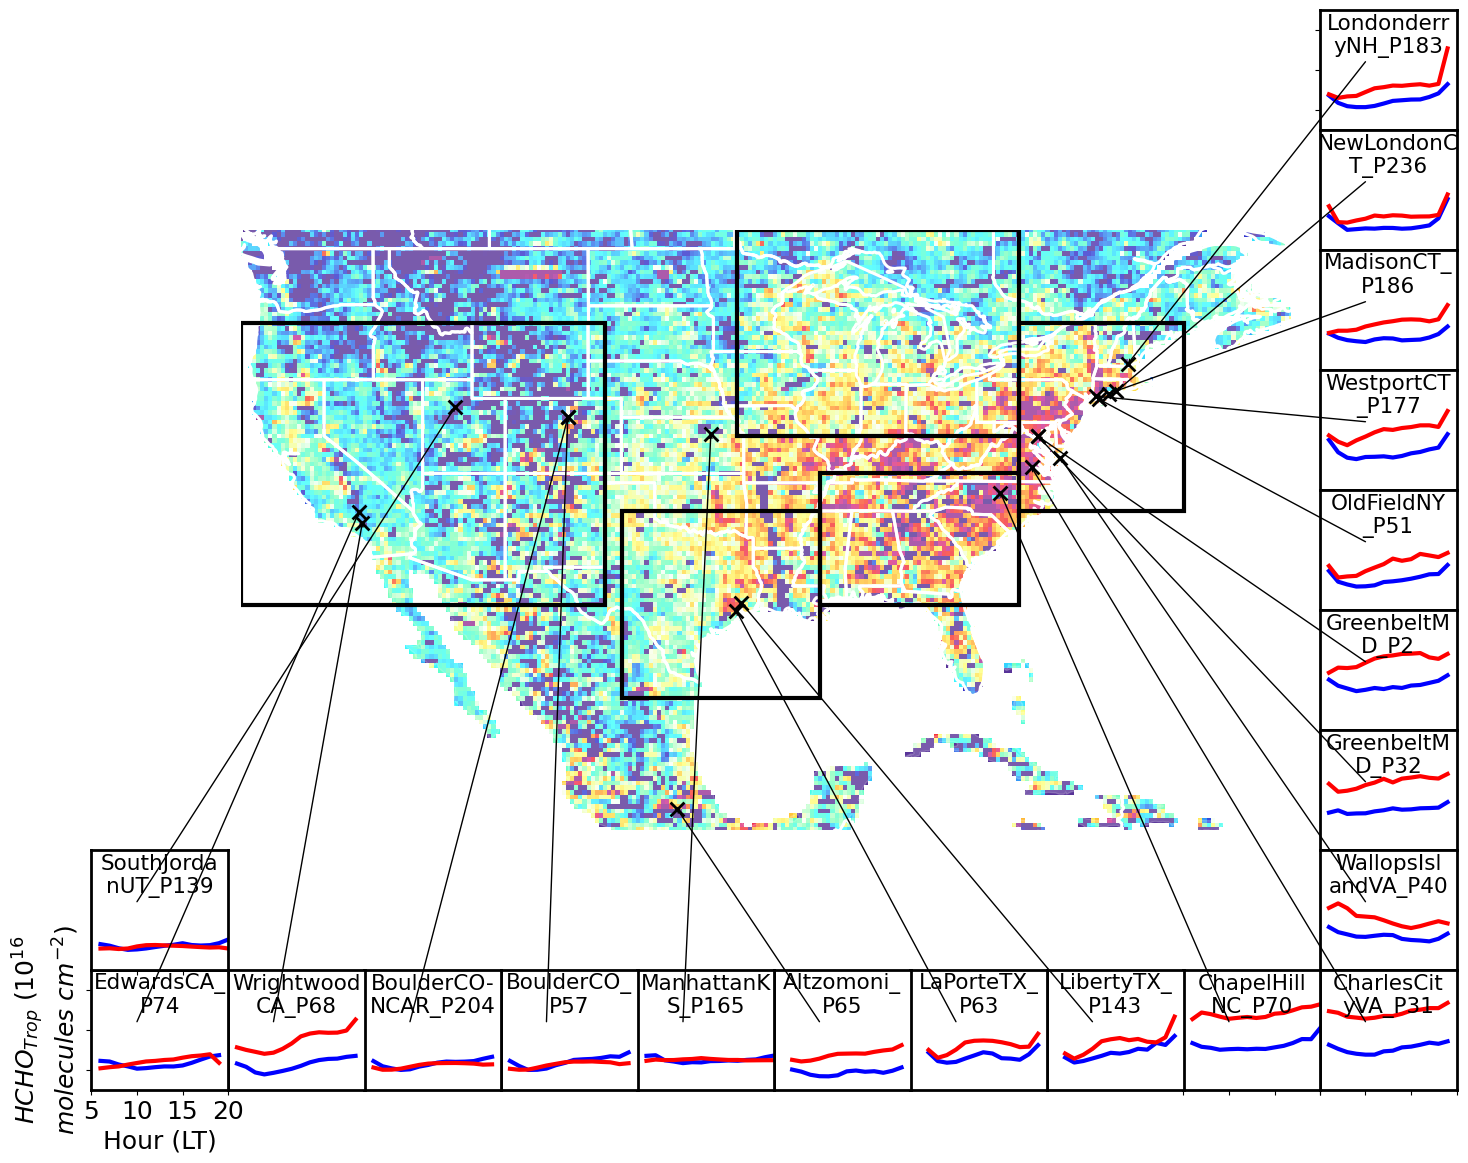

In [103]:
# domain_info = {
#     'domain': 'NA',
#     'lat_bnd': [10, 80],
#     'lon_bnd': [-180, -35],
#     'ipanel_addtick': 26,
#     'ipanel_density_addtick': 26
# }

def drop_elements_by_ref(input_tuple, ref_tuple, elements_to_remove):
    # 找到要删除的元素在 ref_tuple 中的索引
    indices_to_remove = {i for i, element in enumerate(ref_tuple) if element in elements_to_remove}
    # 在 input_tuple 中移除这些索引对应的元素
    return tuple(x for i, x in enumerate(input_tuple) if i not in indices_to_remove)

HCHOtrop_PGN_remove = {'FairbanksAK_P174','CapeElizabethME_P184','CornwallCT_P179','Egbert_P108','Fajardo_P60','LaPorteTX_P11','LaPorteTX_P58'}



xlims = [5, 20]
ylims = [0, 3e16]
scatter_center = [[10],[1.7e16]]
xticks = np.arange(5,23,5)
yticks = np.arange(0.5e16, 3e16,1e16)
xticklabels = np.arange(5,23,5)
yticklabels = ["0.5","1.5","2.5"]
xlabels = "Hour (LT)"
ylabels = "$HCHO_{Trop}$ $(10^{16}$ $molecules$ $cm^{-2})$"
# ylabels = "STD of $HCHO_{TROPCOL}$ $(10^{16}$ $molecules$ $cm^{-2})$"

# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# domain_info = {
#     'domain': 'CONUS',
#     'lat_bnd': [18, 50],
#     'lon_bnd': [-125, -61.5],
#     'ipanel_addtick': 26,
#     'ipanel_density_addtick': 26
# }
# site_row_info = {
#     "landcode" : 'Urban',
#     "urban_rows_sitename_NA_sorted":   drop_elements_by_ref( urban_rows_sitename_NA_sorted, urban_rows_sitename_NA_sorted, HCHOtrop_PGN_remove ),
#     "urban_rows_lon_NA_sorted":   drop_elements_by_ref( urban_rows_lon_NA_sorted, urban_rows_sitename_NA_sorted, HCHOtrop_PGN_remove ),
#     "urban_rows_lat_NA_sorted":   drop_elements_by_ref( urban_rows_lat_NA_sorted, urban_rows_sitename_NA_sorted, HCHOtrop_PGN_remove ),
# }

# plot_PGNdiurnal_on_map( domain_info, site_row_info,\
#                            PGN_fuh_HCHOTropVCD_2021to2023_warm,\
#                            GEOSCF_TROPCOL_HCHO_2021to2023_warm,\
#                            GEOSCF_TROPCOL_HCHO_2021to2023_warm,\
#                            PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal ,\
#                            GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal ,\
#                            GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal,\
#                            xlims, ylims, scatter_center,\
#                            xticks, yticks, xticklabels, yticklabels,\
#                            xlabels, ylabels
#                           )
# ----------------------------------------------------------------------

site_row_info = {
    "landcode" : 'Rural',
    "urban_rows_sitename_NA_sorted":  drop_elements_by_ref( rural_rows_sitename_NA_sorted, rural_rows_sitename_NA_sorted, HCHOtrop_PGN_remove ),
    "urban_rows_lon_NA_sorted":  drop_elements_by_ref( rural_rows_lon_NA_sorted, rural_rows_sitename_NA_sorted, HCHOtrop_PGN_remove ),
    "urban_rows_lat_NA_sorted":  drop_elements_by_ref( rural_rows_lat_NA_sorted, rural_rows_sitename_NA_sorted, HCHOtrop_PGN_remove ),
}

domain_info = {
    'domain': 'CONUS',
    'lat_bnd': [18, 50],
    'lon_bnd': [-125, -61.5],
    'ipanel_addtick': 17,
    'ipanel_density_addtick': 17
}

plot_PGNdiurnal_on_map( domain_info, site_row_info,\
                           PGN_fuh_HCHOTropVCD_2021to2023_warm,\
                           GEOSCF_TROPCOL_HCHO_2021to2023_warm,\
                           GEOSCF_TROPCOL_HCHO_2021to2023_warm,\
                           PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal,\
                           GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal,\
                           GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal,\
                           xlims, ylims, scatter_center,\
                           xticks, yticks, xticklabels, yticklabels,\
                           xlabels, ylabels
                          )



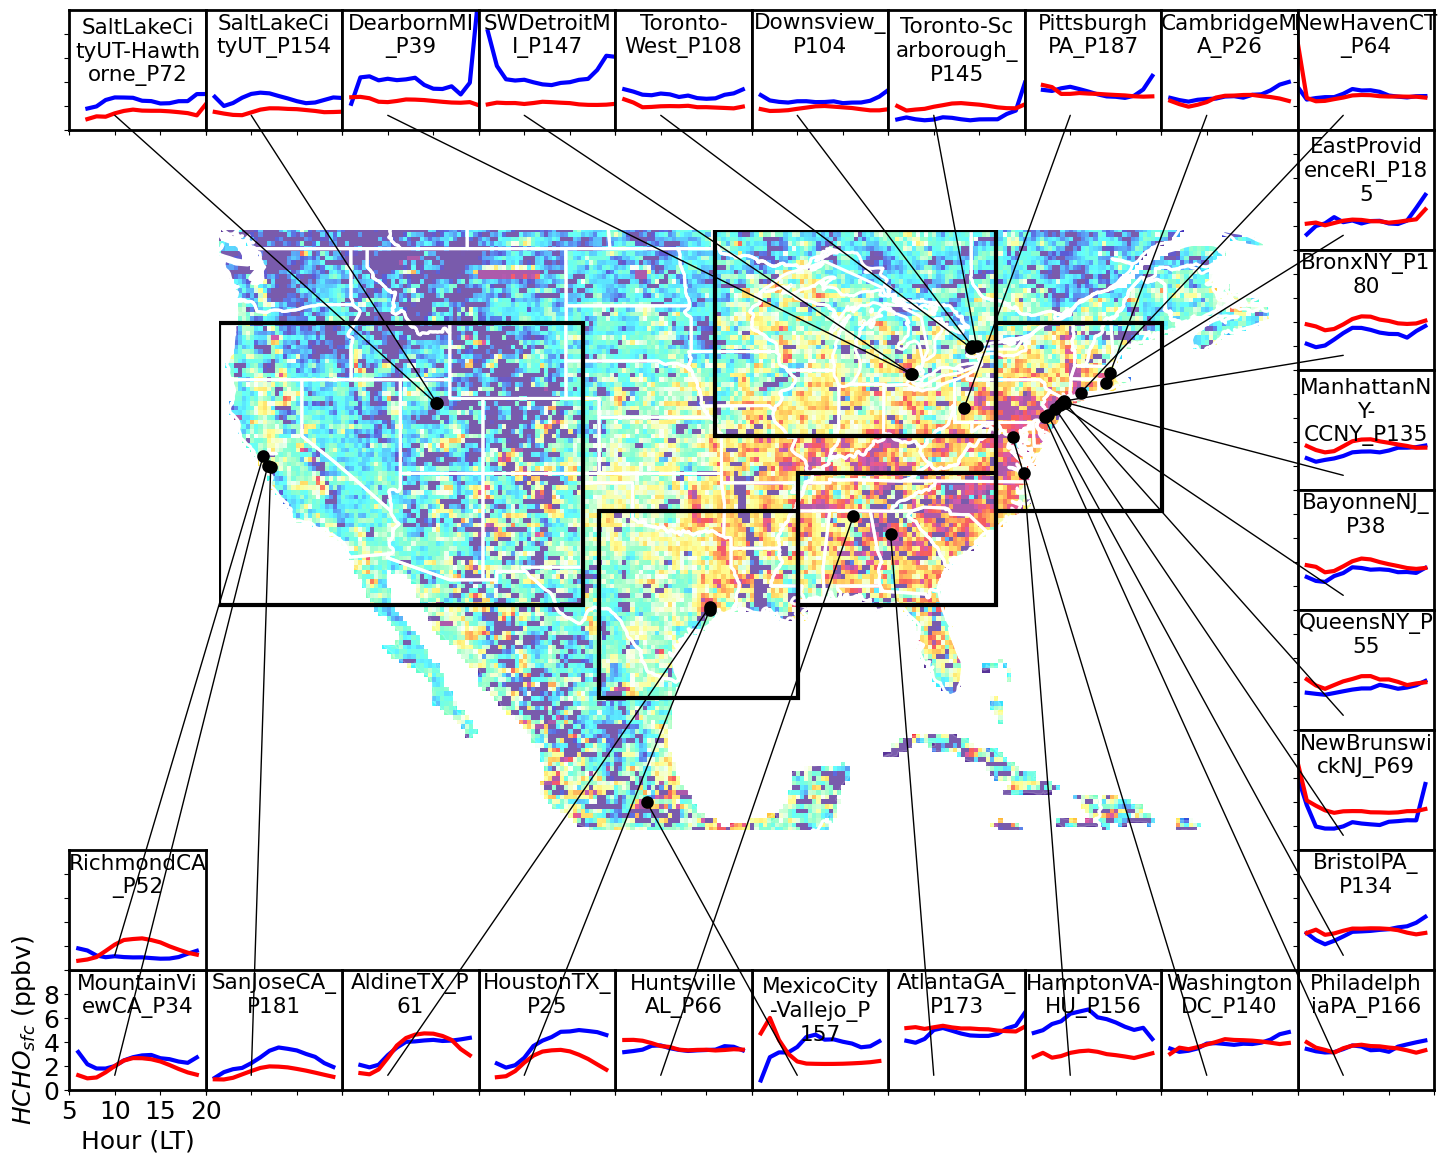

In [68]:
domain_info = {
    'domain': 'NA',
    'lat_bnd': [10, 80],
    'lon_bnd': [-180, -35],
    'ipanel_addtick': 26,
    'ipanel_density_addtick': 26
}
domain_info = {
    'domain': 'CONUS',
    'lat_bnd': [18, 50],
    'lon_bnd': [-125, -61.5],
    'ipanel_addtick': 26,
    'ipanel_density_addtick': 26
}

HCHOsfc_PGN_remove = {'FairbanksAK_P174','CapeElizabethME_P184','CornwallCT_P179','Egbert_P108',
                      'MexicoCity-UNAM_P142','Windsor-West_P208','Fajardo_P60',
                      'LaPorteTX_P11','LaPorteTX_P58','LynnMA_P153','LibertyTX_P143',
                      'NewLondonCT_P236','Downsview_P170','ArlingtonTX_P207'
                     }


xlims = [5, 20]
ylims = [0, 10]
scatter_center = [[10],[1.2]]
xticks = np.arange(5,23,5)
yticks = np.arange(0, 10, 2)
xticklabels = np.arange(5,23,5)
yticklabels = ["0","2","4",'6','8']
xlabels = "Hour (LT)"
ylabels = "$HCHO_{sfc}$ (ppbv)"


site_row_info = {
    "landcode" : 'Urban',
    "urban_rows_sitename_NA_sorted":  drop_elements_by_ref( urban_rows_sitename_NA_sorted, urban_rows_sitename_NA_sorted, HCHOsfc_PGN_remove ),
    "urban_rows_lon_NA_sorted":   drop_elements_by_ref( urban_rows_lon_NA_sorted, urban_rows_sitename_NA_sorted, HCHOsfc_PGN_remove ),
    "urban_rows_lat_NA_sorted":   drop_elements_by_ref( urban_rows_lat_NA_sorted, urban_rows_sitename_NA_sorted, HCHOsfc_PGN_remove ),
}

# tmp = PGN_fuh_HCHOTropVCD_2021to2023_warm / (PGN_fuh_HCHOdVCDprofile_2021to2023_warm.sum(dim='layer_center_height_bins') * 250 * 1e2)


plot_PGNdiurnal_on_map( domain_info, site_row_info,\
                           PGN_fuh_HCHOSurfConc_2021to2023_warm,\
                           GEOSCF_HCHO_2021to2023_warm * 1e-9,\
                           GEOSCF_HCHO_2021to2023_warm,\
                           PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal ,\
                           GEOSCF_HCHO_2021to2023_warm_diurnal * 1e-9 ,\
                           GEOSCF_HCHO_2021to2023_warm_diurnal,\
                           xlims, ylims, scatter_center,\
                           xticks, yticks, xticklabels, yticklabels,\
                           xlabels, ylabels
                          )


# -----------------------------------------------------------------

# domain_info = {
#     'domain': 'CONUS',
#     'lat_bnd': [18, 50],
#     'lon_bnd': [-125, -61.5],
#     'ipanel_addtick': 16,
#     'ipanel_density_addtick': 16
# }
# site_row_info = {
#     "landcode" : 'Rural',
#     "urban_rows_sitename_NA_sorted":  drop_elements_by_ref( rural_rows_sitename_NA_sorted, rural_rows_sitename_NA_sorted, HCHOsfc_PGN_remove ),
#     "urban_rows_lon_NA_sorted":   drop_elements_by_ref( rural_rows_lon_NA_sorted, rural_rows_sitename_NA_sorted, HCHOsfc_PGN_remove ),
#     "urban_rows_lat_NA_sorted":   drop_elements_by_ref( rural_rows_lat_NA_sorted, rural_rows_sitename_NA_sorted, HCHOsfc_PGN_remove ),
# }


# plot_PGNdiurnal_on_map( domain_info, site_row_info,\
#                            PGN_fuh_HCHOSurfConc_2021to2023_warm,\
#                            GEOSCF_HCHO_2021to2023_warm * 1e-9,\
#                            GC_HCHOTropVCD_202205_08_sites,\
#                            PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal ,\
#                            GEOSCF_HCHO_2021to2023_warm_diurnal * 1e-9 ,\
#                            GC_HCHOTropVCD_202205_08_sites_diurnal,\
#                            xlims, ylims, scatter_center,\
#                            xticks, yticks, xticklabels, yticklabels,\
#                            xlabels, ylabels
#                           )


xxx
xxx
xxx
xxx
xxx


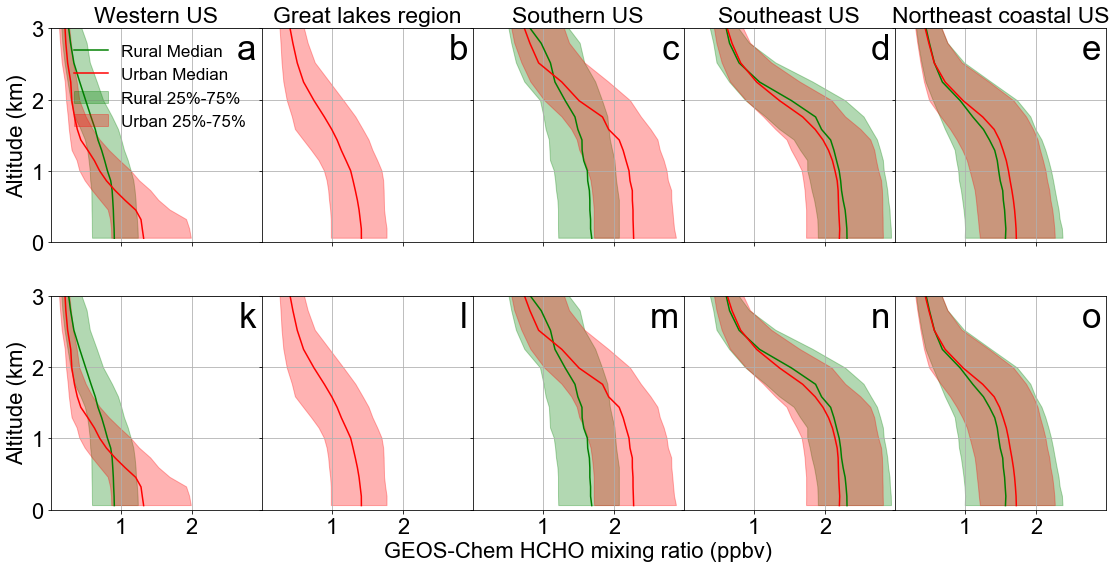

In [432]:
import matplotlib.pyplot as plt
import numpy as np

def transpose_func_vp(ds, landtype_list, LTlist, datacode):
    if datacode == 'PGN':
        levname = 'layer_center_height_bins'
    elif datacode == 'GEOSCF' or 'GC':
        levname = 'lev'

    sitelist = landtype_list[:,2]
    your_data_array = ds[sitelist].to_array()[:,  LTlist,  :,:]
    stacked_data = your_data_array.stack(concat_dim=['variable', 'hour_local', 'day' ])

    transposed_data = stacked_data.transpose(levname, 'concat_dim')
    transposed_data = transposed_data.drop('concat_dim')
#     transposed_data[transposed_data.layer_center_height_bins<2]=np.nan
    return transposed_data



def plot_vp_regions(data_codes, PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d,
#                     GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d,
                    GC_HCHO_v47_2021to2023_warm_diurnal_2d,
                    USregions, USregions_names, hourlist):
    
    # Function to wrap long text
    def wrap_label(label, width=20):
        return '\n'.join(textwrap.wrap(label, width))
    
    
    xlabels = 'GEOS-Chem HCHO mixing ratio (ppbv)'
#     ylabels = ['PGN, Altitude (km)','GEOS-CF, Altitude (km)', 'GC, Altitude (km)']
    ylabels = ['Altitude (km)','Altitude (km)', 'Altitude (km)']
    

    # Create a 2x3 subplot figure
    fig, axs = plt.subplots(2, 5, figsize=(16, 8))

    ipanel_pos = 0
#     panel_labels = 'afkbglchmdinejo'
    panel_labels = 'akblcmdneo'
    
    # Plot each dataset in a subplot and set site name as title
    for i, USregion in enumerate(USregions):
        
        try:
            var_pgn = PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d.copy()
#             var_geoscf = GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d.copy()
            var_gc = GC_HCHO_v47_2021to2023_warm_diurnal_2d.copy()
            print('xxx')
        except:
            continue


        ds_pgn = var_pgn.copy()
#         ds_geoscf = var_geoscf.copy()
        ds_gc = var_gc.copy()
        
        
        for j,ds in enumerate([ds_pgn,\
#                                ds_geoscf,\
                               ds_gc]):
            row = j
            col = i % 5
            
            data_code = data_codes[j]
            
            urban_data_pgn_noon = transpose_func_vp( ds, USregion[0], hourlist, data_code)
            rural_data_pgn_noon = transpose_func_vp( ds, USregion[1], hourlist, data_code)

            urban_median_pgn_noon = urban_data_pgn_noon.median(dim='concat_dim')
            urban_q25_pgn_noon = urban_data_pgn_noon.quantile(0.25, dim='concat_dim')
            urban_q75_pgn_noon = urban_data_pgn_noon.quantile(0.75, dim='concat_dim')
            
            rural_median_pgn_noon = rural_data_pgn_noon.median(dim='concat_dim')
            rural_q25_pgn_noon = rural_data_pgn_noon.quantile(0.25, dim='concat_dim')
            rural_q75_pgn_noon = rural_data_pgn_noon.quantile(0.75, dim='concat_dim')       


            if data_code == 'PGN':
                levname = 'layer_center_height_bins'
                Alt_urban = urban_median_pgn_noon[levname]
                Alt_rural = rural_median_pgn_noon[levname]
            elif data_code == 'GEOSCF':
                levname = 'lev'
                Alt_urban = urban_median_pgn_noon[levname]
                Alt_rural = rural_median_pgn_noon[levname]
            elif data_code == 'GC':
                levname = 'lev'
                Alt_urban = H_b_gc
                Alt_rural = H_b_gc

            axs[row, col].plot(rural_median_pgn_noon, Alt_rural, color='green', label='Rural Median')
            axs[row, col].fill_betweenx(Alt_rural,
                                 rural_q25_pgn_noon, rural_q75_pgn_noon, color='green', alpha=0.3, label='Rural 25%-75%')

            axs[row, col].plot(urban_median_pgn_noon, Alt_urban, color='red', label='Urban Median')    
            axs[row, col].fill_betweenx(Alt_urban,
                                 urban_q25_pgn_noon, urban_q75_pgn_noon, color='red', alpha=0.3, label='Urban 25%-75%')


            if j==0:
                axs[row, col].set_title(USregions_names[i], fontsize=20)
            axs[row, col].set_ylim([0, 3])
            axs[row, col].set_xlim([0.01, 2.98])
#             # Set aspect ratio individually for each subplot
#             axs[row, col].set_aspect('auto')  # You can change 'auto' to a specific aspect ratio if needed
#             # Set xlabel for only the most bottom panels
#             if row == 1:
#                 axs[row, col].set_xlabel(xlabels)            

#             # Set ylabel for only the most left-hand side panels
#             if col == 0:
#                 axs[row, col].set_ylabel(ylabels)
#                 if row == 0:
#                     axs[row, col].legend(('Rural','Urban','Rural 25-75%','Urban 25-75%'), fontsize=18)
                    
                    
                    

#             if ylims[1] > 1e5 and j == 0:
#                 axs[row, col].yaxis.get_major_formatter().set_powerlimits((0, 1))
#                 plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))
                
#                 # Replace the loop for setting scientific notation with custom formatter        
#                 import matplotlib.ticker as ticker
#                 formatter = ticker.ScalarFormatter(useMathText=True)
#                 formatter.set_powerlimits((-3, 3))  # Set the range for exponent display
#                 axs[row, col].yaxis.set_major_formatter(formatter)

            axs[row, col].set_aspect('auto')
    
            if row==0:
                axs[row, col].set_title(USregions_names[col], fontsize=23)    

            if j == 1 and i == 2:
                axs[row, col].set_xlabel(xlabels, fontsize=22)

            if i == 0:
                # Wrapping the ylabel
                wrapped_ylabel = wrap_label( ylabels[j] , width=20)
                axs[row, col].set_ylabel(wrapped_ylabel, fontsize=22)

            if i == 0 and j == 0:
                axs[row, col].legend(fontsize=17,  framealpha=0)
                

            if ipanel_pos in [0]:
                axs[row, col].set_xticklabels([], fontsize=17)
    #             ax.set_yticklabels([], fontsize=18)        
            if ipanel_pos in [2,4,6,8]:
                axs[row, col].set_xticklabels([], fontsize=17)
                axs[row, col].set_yticklabels([], fontsize=17)
            if ipanel_pos in [3,5,7,9]:
    #             ax.set_xticklabels([], fontsize=18)
                axs[row, col].set_yticklabels([], fontsize=17)
                
            # Add panel label
            axs[row, col].annotate(panel_labels[ipanel_pos], xy=(1, 1), xycoords='axes fraction', fontsize=35,
                               xytext=(-5, -5), textcoords='offset points',
                               ha='right', va='top', weight='bold')
            
            #  calculate RMSE:
            
            
            ipanel_pos+=1
                    
                    

    # Create a single colorbar for all subplots
#     cbar_ax = fig.add_axes([1.02, 0.04, 0.02, 0.9])  # [left, bottom, width, height]
#     cbar = fig.colorbar(axs[0, 0].collections[0], cax=cbar_ax, shrink=0.3, orientation='vertical')
#     cbar.set_label('HCHO mixing ratio (ppbv)')  # Set colorbar label

    for ax in axs.flat:
        ax.grid(True, which='both')  # Enable both vertical and horizontal gridlines
        
    # Adjust layout
    fig.tight_layout()#调整整体空白 
    plt.subplots_adjust(wspace =0.0, hspace =0.25)#调整子图间距

    # Show the plot
    plt.show()

    
    

# Example usage:

# Plot each dataset in a subplot and set site name as title
USregions = [[urban_rows_MWUS,rural_rows_MWUS],\
             [urban_rows_NEUS,rural_rows_NEUS],\
             [urban_rows_SUS,rural_rows_SUS],\
             [urban_rows_SEUS,rural_rows_SEUS],\
             [urban_rows_EUS,rural_rows_EUS],\
]

# USregions_names = ["Eastern coastal US, PGN", "Southeast US, PGN", "Southern US, PGN", "Western US, PGN", "Great lakes, PGN",\
#             "Eastern coastal US, GEOS-CF", "Southeast US, GEOS-CF", "Southern US, GEOS-CF", "Western US, GEOS-CF", "Great lakes, GEOS-CF"]
USregions_names = ["Western US","Great lakes region", "Southern US", "Southeast US", "Northeast coastal US"]


# plot_vp_regions(['PGN','GEOSCF','GC'], PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d,\
# #                 GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d* 1e9,\
#                 GC_SpeciesConc_CH2O_202205_08_vp_diurnal_2d* 1e9,\
#                 USregions, USregions_names, [12,13,14,15])


plot_vp_regions(['GC','GC','GC'], GC_SpeciesConc_CH2O_202205_08_vp_diurnal_2d* 1e9,\
#                 GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d* 1e9,\
                GC_SpeciesConc_CH2O_202205_08_vp_diurnal_2d* 1e9,\
                USregions, USregions_names, [12,13,14,15])

xxx
1.0
1.0
xxx
1.0
1.0
xxx
1.0
1.0
xxx
1.0
1.0
xxx
1.0
1.0


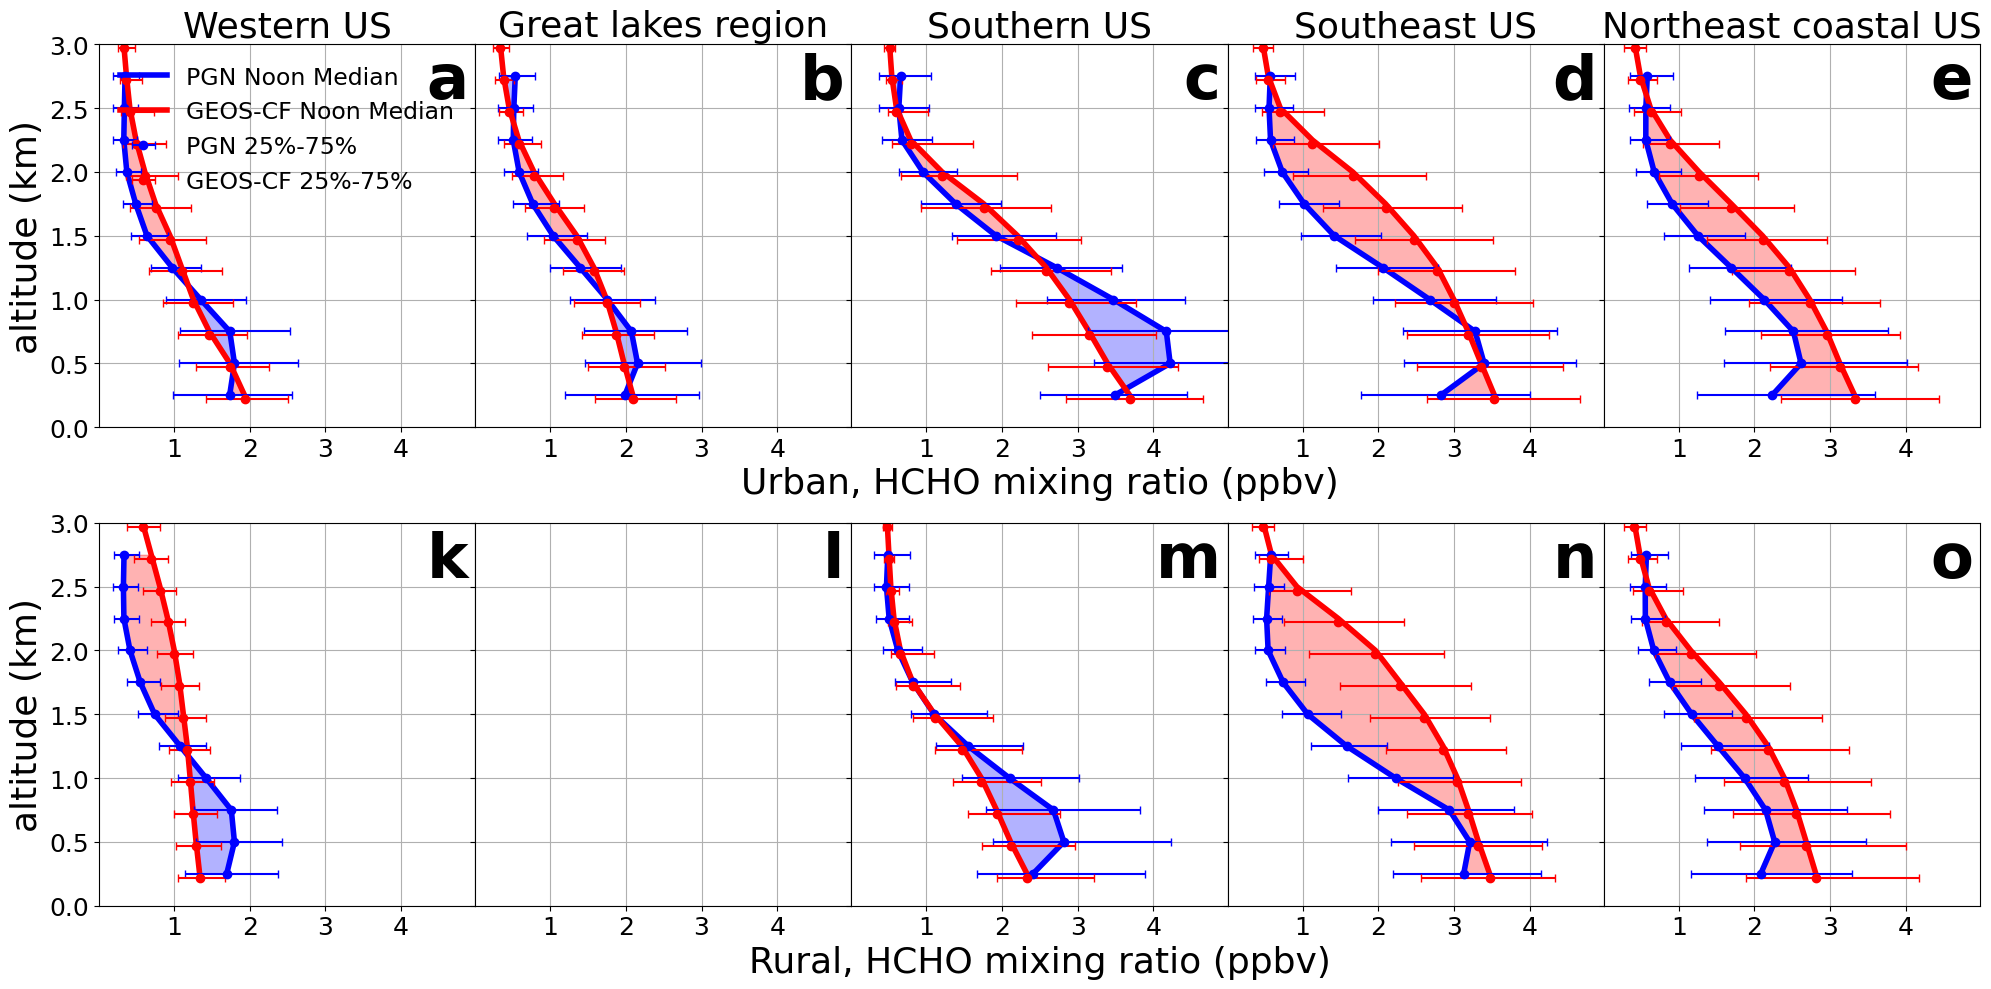

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def transpose_func_vp(ds, landtype_list, LTlist, datacode):
    if datacode == 'PGN':
        levname = 'layer_center_height_bins'
    elif datacode == 'GEOSCF' or 'GC':
        levname = 'lev'

    sitelist = landtype_list[:,2]
    your_data_array = ds[sitelist].to_array()[:,  LTlist,  :,:]
    stacked_data = your_data_array.stack(concat_dim=['variable', 'hour_local', 'day' ])

    transposed_data = stacked_data.transpose(levname, 'concat_dim')
    transposed_data = transposed_data.drop('concat_dim')
#     transposed_data[transposed_data.layer_center_height_bins<2]=np.nan
    return transposed_data




def plot_vp_regions_direct(PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d,
                    GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d,
                    GC_HCHO_v47_2021to2023_warm_diurnal_2d,
                    USregions, USregions_names, hourlist, data_codes):

    import textwrap
    # Function to wrap long text
    def wrap_label(label, width=20):
        return '\n'.join(textwrap.wrap(label, width))
    
    
    xlabels = ['Urban, HCHO mixing ratio (ppbv)','Rural, HCHO mixing ratio (ppbv)']
#     xlabels = ['Rural, HCHO mixing ratio (ppbv)','Rural, HCHO mixing ratio (ppbv)']
#     ylabels = ['PGN, Altitude (km)','GEOS-CF, Altitude (km)', 'GC, Altitude (km)']
    ylabels = ['altitude (km)','altitude (km)']
    

    # Create a 2x3 subplot figure
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))

    ipanel_pos = 0
#     panel_labels = 'afkbglchmdinejo'
    panel_labels = 'aabbccddee'
    panel_labels = 'afbgchdiej'
    panel_labels = 'akblcmdneo'
#     panel_labels = 'fegfhgihji'
#     panel_labels = 'kelfmgnhoi'
    
    # Plot each dataset in a subplot and set site name as title
    for i, USregion in enumerate(USregions):
        
        try:
            var_pgn = PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d.copy()
            var_geoscf = GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d.copy()
            var_gc = GC_HCHO_v47_2021to2023_warm_diurnal_2d.copy()
            print('xxx')
        except:
            continue


        ds_pgn = var_pgn.copy()
        ds_geoscf = var_geoscf.copy()
        ds_gc = var_gc.copy()
        
        ds_list = [ds_pgn,\
                   ds_geoscf,\
                   ds_gc,\
                  ]
#         data_codes = ['PGN','GEOSCF','GC']

        for j in range(0,2):
            row = j
            col = i % 5
            
            pgn_data_pgn_noon = transpose_func_vp( ds_list[0], USregion[j], hourlist, data_codes[0])
            geoscf_data_pgn_noon = transpose_func_vp( ds_list[1], USregion[j], hourlist, data_codes[1])
            gc_data_pgn_noon = transpose_func_vp( ds_list[2], USregion[j], hourlist, data_codes[2])

            pgn_median_pgn_noon = pgn_data_pgn_noon.median(dim='concat_dim')
            pgn_q25_pgn_noon = pgn_data_pgn_noon.quantile(0.25, dim='concat_dim')
            pgn_q75_pgn_noon = pgn_data_pgn_noon.quantile(0.75, dim='concat_dim')
            
            geoscf_median_pgn_noon = geoscf_data_pgn_noon.median(dim='concat_dim')
            geoscf_q25_pgn_noon = geoscf_data_pgn_noon.quantile(0.25, dim='concat_dim')
            geoscf_q75_pgn_noon = geoscf_data_pgn_noon.quantile(0.75, dim='concat_dim') 
            
            gc_median_pgn_noon = gc_data_pgn_noon.median(dim='concat_dim')
            gc_q25_pgn_noon = gc_data_pgn_noon.quantile(0.25, dim='concat_dim')
            gc_q75_pgn_noon = gc_data_pgn_noon.quantile(0.75, dim='concat_dim')
            


            Alt_pgn = ds_pgn['layer_center_height_bins']

            Alt_geoscf = ds_geoscf['lev']

            Alt_gc = H_b_gc
            


#             axs[row, col].plot(pgn_median_pgn_noon, Alt_pgn, color='blue', label='PGN Median')
#             axs[row, col].fill_betweenx(Alt_pgn,
#                                  pgn_q25_pgn_noon, pgn_q75_pgn_noon, color='blue', alpha=0.3, label='PGN 25%-75%')

#             axs[row, col].plot(geoscf_median_pgn_noon, Alt_geoscf, color='red', label='GEOS-CF Median')
#             axs[row, col].fill_betweenx(Alt_geoscf,
#                                  geoscf_q25_pgn_noon, geoscf_q75_pgn_noon, color='orange', alpha=0.3, label='GEOS-CF 25%-75%')

# #             axs[row, col].plot(gc_median_pgn_noon, Alt_gc, color='green', label='GEOS-Chem Median')
# #             axs[row, col].fill_betweenx(Alt_gc,
# #                                  gc_q25_pgn_noon, gc_q75_pgn_noon, color='green', alpha=0.3, label='GEOS-Chem 25%-75%')

            # scale factor for PGN
            # tmp_scale = (PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d.median(dim='day') / (PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal_2d).median(dim='day').sum(dim='layer_center_height_bins'))
            # tmp_scale = tmp_scale[ USregion[j][:,2] ].to_array().sel(hour_local=hourlist).median(dim='hour_local').median(dim='variable')

            # tmp_scale_pgntrop = PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d[ USregion[j][:,2] ].to_array().sel(hour_local=hourlist).median(dim='hour_local').median(dim='variable').median(dim='day')
            # tmp_scale_pgnint = PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal_2d[ USregion[j][:,2] ].to_array().sel(hour_local=hourlist).median(dim='hour_local').median(dim='variable').median(dim='day').sum(dim='layer_center_height_bins')
            # tmp_scale = tmp_scale_pgntrop / tmp_scale_pgnint

            # tmp_scale1 = PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d[ USregion[j][:,2] ].to_array().sel(hour_local=hourlist).median(dim='day').median(dim='hour_local').median(dim='variable')
            # tmp_scale2 = (PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal_2d)[ USregion[j][:,2] ].to_array().sel(hour_local=hourlist).median(dim='day').median(dim='hour_local').median(dim='variable').sum(dim='layer_center_height_bins')
            # tmp_scale = tmp_scale1 / tmp_scale2
            
            tmp_scale = 1.0


            
            # Interpolate GCF data to match PGN vertical grid
            interp_func = interp1d(geoscf_median_pgn_noon['lev'], geoscf_median_pgn_noon, axis=0, fill_value="extrapolate")
            gcf_interpolated = interp_func(pgn_median_pgn_noon['layer_center_height_bins'])

            # Plot PGN profile
            axs[row, col].plot(pgn_median_pgn_noon * tmp_scale, pgn_median_pgn_noon['layer_center_height_bins'], lw=4,  color='blue', label='PGN Noon Median')
            # Plot GCF profile
            axs[row, col].plot(gcf_interpolated, pgn_median_pgn_noon['layer_center_height_bins'], lw=4,  color='red', label='GEOS-CF Noon Median')

            # Highlight the difference
            print(float(tmp_scale))
            axs[row, col].fill_betweenx(pgn_median_pgn_noon['layer_center_height_bins'], pgn_median_pgn_noon.values * float(tmp_scale), gcf_interpolated,
                                 where=(pgn_median_pgn_noon.values * float(tmp_scale) > gcf_interpolated ), 
                                 interpolate=True, color='blue', alpha=0.3)
            axs[row, col].fill_betweenx(pgn_median_pgn_noon['layer_center_height_bins'], gcf_interpolated, pgn_median_pgn_noon.values * float(tmp_scale),
                                 where=(gcf_interpolated > pgn_median_pgn_noon.values * float(tmp_scale) ), 
                                 interpolate=True, color='red', alpha=0.3)


            # 计算误差范围
            # Interpolate GCF error data to match PGN vertical grid
            interp_func = interp1d(geoscf_q25_pgn_noon['lev'], geoscf_q25_pgn_noon, axis=0, fill_value="extrapolate")
            gcf_q25_interpolated = interp_func(pgn_q25_pgn_noon['layer_center_height_bins'])
            interp_func = interp1d(geoscf_q75_pgn_noon['lev'], geoscf_q75_pgn_noon, axis=0, fill_value="extrapolate")
            gcf_q75_interpolated = interp_func(pgn_q75_pgn_noon['layer_center_height_bins'])
            
            pgn_error = [pgn_median_pgn_noon * tmp_scale - pgn_q25_pgn_noon * tmp_scale, pgn_q75_pgn_noon * tmp_scale - pgn_median_pgn_noon * tmp_scale]
            geoscf_error = [gcf_interpolated - gcf_q25_interpolated, gcf_q75_interpolated - gcf_interpolated]
            
            axs[row, col].errorbar(pgn_median_pgn_noon * tmp_scale, pgn_median_pgn_noon['layer_center_height_bins'], 
                       xerr=pgn_error, fmt='o', color='blue', capsize=3, label='PGN 25%-75%')
            # 轻微错开 y 轴，用 pgn_median_pgn_noon['layer_center_height_bins'] - 0.02 来错开
            axs[row, col].errorbar(gcf_interpolated, pgn_median_pgn_noon['layer_center_height_bins'] - 0.03, 
                                   xerr=geoscf_error, fmt='o', color='red', capsize=3, label='GEOS-CF 25%-75%')











            if j==0:
                axs[row, col].set_title(USregions_names[i], fontsize=20)
            axs[row, col].set_ylim([0, 3])
            axs[row, col].set_xlim([0.01, 4.98])
#             # Set aspect ratio individually for each subplot
#             axs[row, col].set_aspect('auto')  # You can change 'auto' to a specific aspect ratio if needed
#             # Set xlabel for only the most bottom panels
#             if row == 1:
#                 axs[row, col].set_xlabel(xlabels)            

#             # Set ylabel for only the most left-hand side panels
#             if col == 0:
#                 axs[row, col].set_ylabel(ylabels)
#                 if row == 0:
#                     axs[row, col].legend(('Rural','Urban','Rural 25-75%','Urban 25-75%'), fontsize=18)
                    
                    


#             if ylims[1] > 1e5 and j == 0:
#                 axs[row, col].yaxis.get_major_formatter().set_powerlimits((0, 1))
#                 plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))
                
#                 # Replace the loop for setting scientific notation with custom formatter        
#                 import matplotlib.ticker as ticker
#                 formatter = ticker.ScalarFormatter(useMathText=True)
#                 formatter.set_powerlimits((-3, 3))  # Set the range for exponent display
#                 axs[row, col].yaxis.set_major_formatter(formatter)

            axs[row, col].set_aspect('auto')
    
            if row==0:
                axs[row, col].set_title(USregions_names[col], fontsize=26)    

#             if j == 1 and i == 2:
#                 axs[row, col].set_xlabel(xlabels, fontsize=26)
            if i == 2:
                axs[row, col].set_xlabel(xlabels[j], fontsize=26)

            if i == 0:
                # Wrapping the ylabel
                wrapped_ylabel = wrap_label( ylabels[j] , width=20)
                axs[row, col].set_ylabel(wrapped_ylabel, fontsize=26)

            if i == 0 and j == 0:
                axs[row, col].legend(fontsize=17,  framealpha=0)
                

#             if ipanel_pos in [0]:
#                 axs[row, col].set_xticklabels([], fontsize=30)
    #             ax.set_yticklabels([], fontsize=18)        
            if ipanel_pos in [2,4,6,8]:
#                 axs[row, col].set_xticklabels([], fontsize=30)
                axs[row, col].set_yticklabels([], fontsize=30)
            if ipanel_pos in [3,5,7,9]:
    #             ax.set_xticklabels([], fontsize=18)
                axs[row, col].set_yticklabels([], fontsize=30)
                
            # Add panel label
            axs[row, col].annotate(panel_labels[ipanel_pos], xy=(1, 1), xycoords='axes fraction', fontsize=45,
                               xytext=(-5, -5), textcoords='offset points',
                               ha='right', va='top', weight='bold')
            
            #  calculate RMSE:
            
            
            ipanel_pos+=1
                    
                    

    # Create a single colorbar for all subplots
#     cbar_ax = fig.add_axes([1.02, 0.04, 0.02, 0.9])  # [left, bottom, width, height]
#     cbar = fig.colorbar(axs[0, 0].collections[0], cax=cbar_ax, shrink=0.3, orientation='vertical')
#     cbar.set_label('HCHO mixing ratio (ppbv)')  # Set colorbar label

    for ax in axs.flat:
        ax.grid(True, which='both')  # Enable both vertical and horizontal gridlines
        
    # Adjust layout
    fig.tight_layout()#调整整体空白 
    plt.subplots_adjust(wspace =0.0, hspace =0.25)#调整子图间距

    # Show the plot
    plt.show()

    
    

# Example usage:

# Plot each dataset in a subplot and set site name as title
USregions = [[urban_rows_MWUS,rural_rows_MWUS],\
             [urban_rows_NEUS,rural_rows_NEUS],\
             [urban_rows_SUS,rural_rows_SUS],\
             [urban_rows_SEUS,rural_rows_SEUS],\
             [urban_rows_EUS,rural_rows_EUS],\
]

USregions_names = ["Western US","Great lakes region", "Southern US", "Southeast US", "Northeast coastal US"]


# tmp = PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d / PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal_2d.sum(dim='layer_center_height_bins')
# tmp = 1.25

plot_vp_regions_direct( PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d,\
                GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d * 1e9,\
                GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d * 1e9,\
                # GC_SpeciesConc_CH2O_202205_08_vp_diurnal_2d* 1e9,\
                USregions, USregions_names, [12,13,14,15], data_codes = ['PGN','GEOSCF','GC'])

In [70]:
import matplotlib.ticker as ticker

def plot_vp_regions_dVCD( PGN_dVCD_diurnal_2d,
                    GEOSCF_HCHOdVCD_v36_2021to2023_warm_diurnal_2d,
                    USregions, USregions_names, hourlist, data_codes):

    import textwrap
    # Function to wrap long text
    def wrap_label(label, width=20):
        return '\n'.join(textwrap.wrap(label, width))
    
    
    xlabels = ['Urban, HCHO dVCD (molec cm-2)','Rural, HCHO dVCD (molec cm-2)']
#     xlabels = ['Rural, HCHO mixing ratio (ppbv)','Rural, HCHO mixing ratio (ppbv)']
#     ylabels = ['PGN, Altitude (km)','GEOS-CF, Altitude (km)', 'GC, Altitude (km)']
    ylabels = ['altitude (km)','altitude (km)']
    

    # Create a 2x3 subplot figure
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))

    ipanel_pos = 0
#     panel_labels = 'afkbglchmdinejo'
    panel_labels = 'aabbccddee'
    panel_labels = 'afbgchdiej'
    panel_labels = 'akblcmdneo'

    
    # Plot each dataset in a subplot and set site name as title
    for i, USregion in enumerate(USregions):
        
        try:
            var_pgn = PGN_dVCD_diurnal_2d.copy()
            var_geoscf = GEOSCF_HCHOdVCD_v36_2021to2023_warm_diurnal_2d.copy()
            print('xxx')
        except:
            continue


        ds_pgn = var_pgn.copy()
        ds_geoscf = var_geoscf.copy()
        
        ds_list = [ds_pgn,\
                   ds_geoscf,\
                  ]
#         data_codes = ['PGN','GEOSCF','GC']

        for j in range(0,2):
            row = j
            col = i % 5
            
            pgn_data_pgn_noon = transpose_func_vp( ds_list[0], USregion[j], hourlist, data_codes[0])
            # geoscf_data_pgn_noon = transpose_func_vp( ds_list[1].rename({'lev': 'layer_center_height_bins'}), USregion[j], hourlist, data_codes[1])
            geoscf_data_pgn_noon = transpose_func_vp( ds_list[1], USregion[j], hourlist, data_codes[1])
            geoscf_data_pgn_noon = geoscf_data_pgn_noon.rename({'lev': 'layer_center_height_bins'})

            # 计算数据
            data = (geoscf_data_pgn_noon - pgn_data_pgn_noon)
            median_diff = geoscf_data_pgn_noon.median(dim='concat_dim') - pgn_data_pgn_noon.median(dim='concat_dim')
            
            # 获取 x 轴标签
            layer_labels = data.layer_center_height_bins.values  # 确保这个变量包含高度信息
            cumsum_median_diff = median_diff.cumsum(dim='layer_center_height_bins')  # 计算累计和
            


            Alt_pgn = ds_pgn['layer_center_height_bins']


            # tmp_scale1 = PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d[ USregion[j][:,2] ].to_array().sel(hour_local=hourlist).median(dim='day').median(dim='hour_local').median(dim='variable')
            # tmp_scale2 = (PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal_2d)[ USregion[j][:,2] ].to_array().sel(hour_local=hourlist).median(dim='day').median(dim='hour_local').median(dim='variable').sum(dim='layer_center_height_bins')
            # tmp_scale = tmp_scale1 / tmp_scale2
            tmp_scale = 1.0

            
            # plot dVCD difference profile
            axs[row, col].barh( range(len(median_diff )),  median_diff * float(tmp_scale),     color='blue', label='GEOSCF - PGN, dVCD')
            axs[row, col].set_yticks(range(len(layer_labels)))
            axs[row, col].set_yticklabels(layer_labels)


            if j==0:
                axs[row, col].set_title(USregions_names[i], fontsize=20)

            axs[row, col].set_ylim([0, 12])
            axs[row, col].set_xlim([-0.69e15, 0.69e15])


            axs[row, col].set_aspect('auto')
    
            if row==0:
                axs[row, col].set_title(USregions_names[col], fontsize=26)    

            if i == 2:
                axs[row, col].set_xlabel(xlabels[j], fontsize=26, labelpad=25)

            if i == 0:
                # Wrapping the ylabel
                wrapped_ylabel = wrap_label( ylabels[j] , width=20)
                axs[row, col].set_ylabel(wrapped_ylabel, fontsize=26)

            if i == 0 and j == 0:
                axs[row, col].legend(fontsize=17,  framealpha=0, bbox_to_anchor=(1.25, -0.2))
                
            if ipanel_pos in [2,4,6,8]:
                axs[row, col].set_yticklabels([], fontsize=30)
            if ipanel_pos in [3,5,7,9]:
                axs[row, col].set_yticklabels([], fontsize=30)
                
            # Add panel label
            axs[row, col].annotate(panel_labels[ipanel_pos], xy=(1, 1), xycoords='axes fraction', fontsize=45,
                               xytext=(-5, -5), textcoords='offset points',
                               ha='right', va='top', weight='bold')
            
            ipanel_pos+=1
                    
    for ax in axs.flat:
        ax.grid(False, which='both')  # Enable both vertical and horizontal gridlines
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))  # 使用科学计数法
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))  # 强制科学计数法


    # Adjust layout
    fig.tight_layout()#调整整体空白 
    plt.subplots_adjust(wspace =0.0, hspace =0.4)#调整子图间距

    # Show the plot
    plt.show()


xxx
xxx
xxx
xxx
xxx


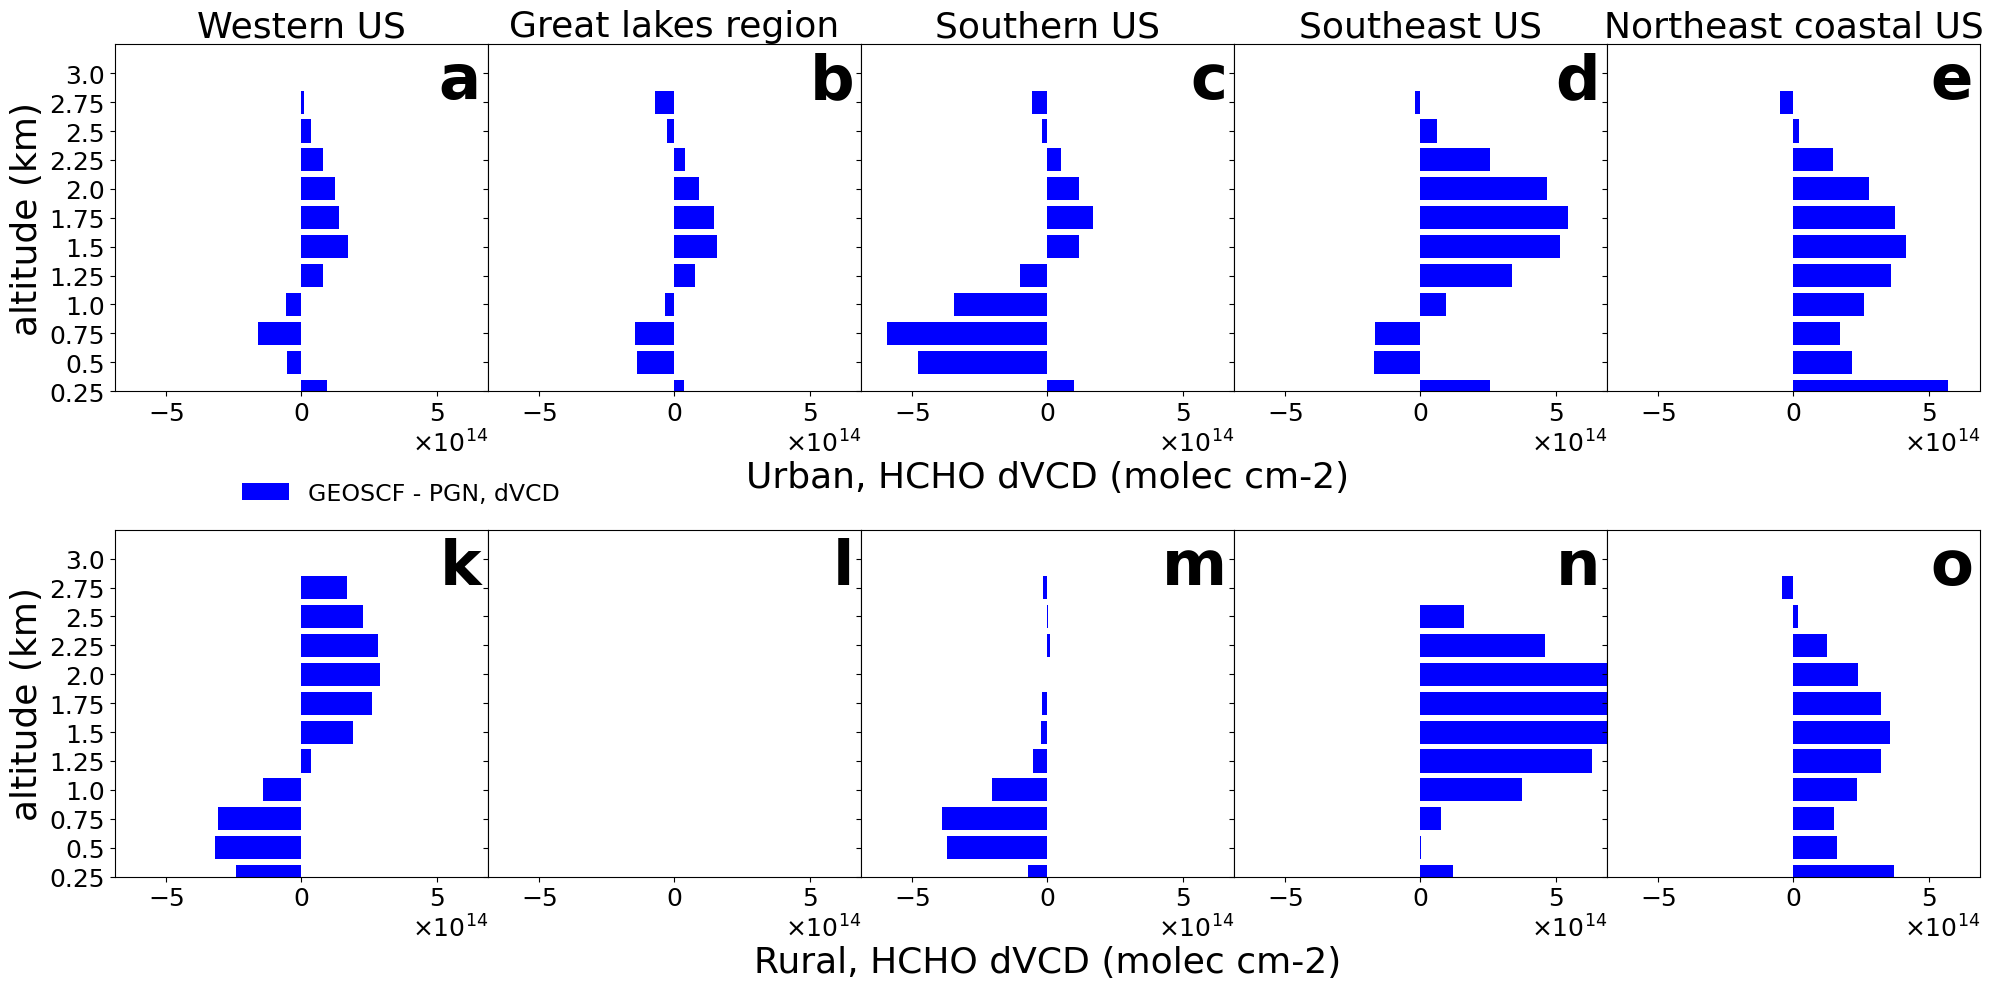

In [71]:
# Plot each dataset in a subplot and set site name as title
USregions = [[urban_rows_MWUS,rural_rows_MWUS],\
             [urban_rows_NEUS,rural_rows_NEUS],\
             [urban_rows_SUS,rural_rows_SUS],\
             [urban_rows_SEUS,rural_rows_SEUS],\
             [urban_rows_EUS,rural_rows_EUS],\
]

USregions_names = ["Western US","Great lakes region", "Southern US", "Southeast US", "Northeast coastal US"]


plot_vp_regions_dVCD( PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal_2d,\
                GEOSCF_HCHOdVCD_v36_2021to2023_warm_diurnal_2d_PGNlev,\
                USregions, USregions_names, [12,13,14,15], data_codes = ['PGN','GEOSCF','GC'])

In [79]:
# 计算底部高度（H_bottom_geoscf）
H_bottom_geoscf = np.zeros_like(H_geoscf)  # 预分配数组
H_bottom_geoscf[:-1] = (H_geoscf[:-1] + H_geoscf[1:]) / 2  # 计算除最低层外的 bottom height
H_bottom_geoscf[-1] = 0  # 确保最低层 bottom = 0

# 计算顶部高度（H_top_geoscf）
H_top_geoscf = np.zeros_like(H_geoscf)  # 预分配数组
H_top_geoscf[1:] = H_bottom_geoscf[:-1]  # 每一层的 top 是下一层的 bottom
H_top_geoscf[0] = H_geoscf[0] + (H_geoscf[0] - H_geoscf[1]) / 2  # 最高层 extrapolate

# 计算 box height（box_height_geoscf）
box_height_geoscf = (H_top_geoscf - H_bottom_geoscf)

In [80]:
factor_geoscf_mr_to_moleccm2_diurnal_2d = (P_geoscf * 1e2 * box_height_geoscf * 1e3 ) / ( 8.3145 * GEOSCF_T_v36_2021to2023_warm_diurnal_2d ) * (6.02e23 )/ (1e4)
GEOSCF_HCHOdVCD_v36_2021to2023_warm_diurnal_2d = factor_geoscf_mr_to_moleccm2_diurnal_2d * GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d

In [81]:
factor_geoscf_mr_to_moleccm2_diurnal = (P_geoscf * 1e2 * box_height_geoscf * 1e3 ) / ( 8.3145 * GEOSCF_T_v36_2021to2023_warm_diurnal ) * (6.02e23 )/ (1e4)
GEOSCF_HCHOdVCD_v36_2021to2023_warm_diurnal= factor_geoscf_mr_to_moleccm2_diurnal * GEOSCF_HCHO_v36_2021to2023_warm_diurnal

In [42]:
#     PGN HCHO
# --------------------------------------------------
# 修改第二维名称函数
def rename_third_dim(obj, new_dim_name):
    if len(obj.dims) > 1:
        return obj.rename({obj.dims[2]: new_dim_name})
    return obj


# Perform linear interpolation
from scipy.interpolate import interp1d
interp_pressure = interp1d(H_geoscf[H_geoscf<=3], P_geoscf[H_geoscf<=3], kind='linear', fill_value='extrapolate')
# Interpolate pressure for the second altitude list
layer_center_P_bins = interp_pressure(PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d.layer_center_height_bins)

# Select levels less than 3
tmp_below3km = GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d.sel(lev=GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d['lev'].where(GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d['lev'] < 3.1, drop=True))
GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d_PGNlev = tmp_below3km.interp(lev=PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d.layer_center_height_bins.values, method='linear')

tmp_below3km = GEOSCF_T_v36_2021to2023_warm_diurnal_2d.sel(lev=GEOSCF_T_v36_2021to2023_warm['lev'].where(GEOSCF_T_v36_2021to2023_warm['lev'] < 3.1, drop=True))
GEOSCF_T_v36_2021to2023_warm_diurnal_2d_PGNlev = tmp_below3km.interp(lev=PGN_fuh_HCHOdVCDprofile_2021to2023_warm_ppbv_diurnal_2d.layer_center_height_bins.values, method='linear')
tmp_facter = (layer_center_P_bins * 1e2 * 250 ) / ( 8.3145 * GEOSCF_T_v36_2021to2023_warm_diurnal_2d_PGNlev ) * (6.02e23 )/ (1e4)
GEOSCF_HCHOdVCD_v36_2021to2023_warm_diurnal_2d_PGNlev = GEOSCF_HCHO_v36_2021to2023_warm_diurnal_2d_PGNlev * tmp_facter    



# Perform linear interpolation
from scipy.interpolate import interp1d
interp_pressure = interp1d(H_geoscf[H_geoscf<=3], P_geoscf[H_geoscf<=3], kind='linear', fill_value='extrapolate')
# Interpolate pressure for the second altitude list
layer_center_P_bins = interp_pressure(PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal.layer_center_height_bins)
#  calculate conversion factor: 
factor_PGN_HCHOvp_ppbv_2021to2023_warm = ( 8.3145 * GEOSCF_T_v36_2021to2023_warm_diurnal_2d_PGNlev ) / (6.02e11 * layer_center_P_bins * 1e-1)
factor_PGN_HCHOvp_ppbv_2021to2023_warm = factor_PGN_HCHOvp_ppbv_2021to2023_warm.map(lambda v: rename_third_dim(v, "layer_center_height_bins"))


In [97]:
import matplotlib.pyplot as plt
import textwrap



def plot_diurnal_regions_direct(PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d,
                         GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_2d,
                         xlims, ylims,
                         xlabels, ylabels
                        ):

    def transpose_func_1(ds, landtype_list):
        sitelist = landtype_list[:, 2]
        your_data_array = ds[sitelist].to_array()
        stacked_data = your_data_array.stack(concat_dim=['variable', 'day'])
        transposed_data = stacked_data.transpose('hour_local', 'concat_dim')
        transposed_data = transposed_data.drop('concat_dim')
        return transposed_data

    def transpose_func_22(ds, landtype_list):
        sitelist = landtype_list[:, 2]
        your_data_array = ds[sitelist].to_array().isel(lev=slice(18, 36))
        stacked_data = your_data_array.stack(concat_dim=['variable', 'day'])
        transposed_data = stacked_data.transpose('hour_local', 'concat_dim','lev')
        transposed_data = transposed_data.drop('concat_dim')
        return transposed_data
        
    # Function to wrap long text
    def wrap_label(label, width=20):
        return '\n'.join(textwrap.wrap(label, width))
    
    
    

    fig, axs = plt.subplots(2, 5, figsize=(16,8))
    
    USregions = [[urban_rows_MWUS, rural_rows_MWUS], [urban_rows_NEUS, rural_rows_NEUS],
                 [urban_rows_SUS, rural_rows_SUS], [urban_rows_SEUS, rural_rows_SEUS],
                 [urban_rows_EUS, rural_rows_EUS]
                 ]

    # USregions = [[urban_rows_AQSO3_MWUS, rural_rows_AQSO3_MWUS], [urban_rows_AQSO3_NEUS, rural_rows_AQSO3_NEUS],
    #              [urban_rows_AQSO3_SUS, rural_rows_AQSO3_SUS], [urban_rows_AQSO3_SEUS, rural_rows_AQSO3_SEUS],
    #              [urban_rows_AQSO3_EUS, rural_rows_AQSO3_EUS]
    #              ]

    
    USregions_names = ["           Western US","Great Lakes region", "Southern US",  "Southeast US", "Northeast Coastal US",
                       "", "", "", "", ""]
    
    ds_list = [
        PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d,
        GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_2d,
    ]
    num_ds = len(ds_list)
    

    # Panel labels
    panel_labels = 'abcdefghij'
    panel_labels = 'fghijfghij'
    urbanrural_index = [0,1]
    

    ipanel_pos = 0
    for i in range(0,2):
        for j, USregion in enumerate(USregions):
            urban_data = transpose_func_1(ds_list[0], USregion[urbanrural_index[i]])
            rural_data = transpose_func_1(ds_list[1], USregion[urbanrural_index[i]])

            urban_median = urban_data.median(dim='concat_dim')
            urban_q25 = urban_data.quantile(0.25, dim='concat_dim')
            urban_q75 = urban_data.quantile(0.75, dim='concat_dim')

            # rural_median = rural_data.median(dim='concat_dim').sum(dim='lev')
            # rural_q25 = rural_data.quantile(0.25, dim='concat_dim').sum(dim='lev')
            # rural_q75 = rural_data.quantile(0.75, dim='concat_dim').sum(dim='lev')
            rural_median = rural_data.median(dim='concat_dim')
            rural_q25 = rural_data.quantile(0.25, dim='concat_dim')
            rural_q75 = rural_data.quantile(0.75, dim='concat_dim')


            
            # 仅保留 urban_data 非 NaN 值的时间点
            urban_mask = urban_median.notnull()
            # 过滤 rural 数据，匹配 urban 数据可用性
            rural_median = rural_median.where(urban_mask, drop=True)
            rural_q25 = rural_q25.where(urban_mask, drop=True)
            rural_q75 = rural_q75.where(urban_mask, drop=True)


            axs[i, j].plot(urban_median['hour_local'], urban_median, color='blue', label='PGN Median')
            axs[i, j].fill_between(urban_median['hour_local'], urban_q25, urban_q75, color='blue', alpha=0.2,
                                    label='PGN 25%-75%')

            axs[i, j].plot(rural_median['hour_local'], rural_median, color='red', label='GEOS-CF Median')
            axs[i, j].fill_between(rural_median['hour_local'], rural_q25, rural_q75, color='orange', alpha=0.2,
                                    label='GEOS-CF 25%-75%')


            axs[i, j].set_ylim(ylims)
            axs[i, j].set_xlim(xlims)
            axs[i, j].set_xticks([8,12,16])
            axs[i, j].set_xticklabels([8,12,16])
            
            if i==0:
                axs[i, j].set_title(USregions_names[j], fontsize=21)         

            if ylims[1] > 1e5 and j == 0:
                axs[i, j].yaxis.get_major_formatter().set_powerlimits((0, 1))
                plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))
                
                # Replace the loop for setting scientific notation with custom formatter        
                import matplotlib.ticker as ticker
                formatter = ticker.ScalarFormatter(useMathText=True)
                formatter.set_powerlimits((-3, 3))  # Set the range for exponent display
                axs[i, j].yaxis.set_major_formatter(formatter)

            axs[i, j].set_aspect('auto')

            if j == 2 and i == 1:
                axs[i, j].set_xlabel(xlabels[urbanrural_index[i]], fontsize=22)

            if j == 0:
                # Wrapping the ylabel
                wrapped_ylabel = wrap_label( ylabels[urbanrural_index[i] ] , width=25)
                axs[i, j].set_ylabel(wrapped_ylabel, fontsize=22)

            # if i == 0 and j == 0:
            #     axs[i, j].legend(fontsize=16,  framealpha=0)
                

            if ipanel_pos in [0]:
                axs[i, j].set_xticklabels([], fontsize=17)
    #             ax.set_yticklabels([], fontsize=18)        
            if ipanel_pos in [1,2,3,4]:
                axs[i, j].set_xticklabels([], fontsize=17)
                axs[i, j].set_yticklabels([], fontsize=17)
            if ipanel_pos in [6,7,8,9]:
    #             ax.set_xticklabels([], fontsize=18)
                axs[i, j].set_yticklabels([], fontsize=17)
                
            # Add panel label
            axs[i, j].annotate(panel_labels[ipanel_pos], xy=(1, 1), xycoords='axes fraction', fontsize=35,
                               xytext=(-5, -5), textcoords='offset points',
                               ha='right', va='top', weight='bold')
            

            
            
            
            ipanel_pos+=1

        
    for ax in axs.flat:
        ax.grid(True, which='both')  # Enable both vertical and horizontal gridlines



#     plt.tight_layout(pad=1.0)  
    fig.tight_layout()#调整整体空白 
    plt.subplots_adjust(wspace =0.0, hspace =0.25)#调整子图间距
#     plt.savefig( '/home/tzhao/my_jupyter_work/newest/EGU24_poster_figs/diurnalcycle_HCHOsurfconc'+'.svg', dpi=300, bbox_inches='tight')
    plt.show()


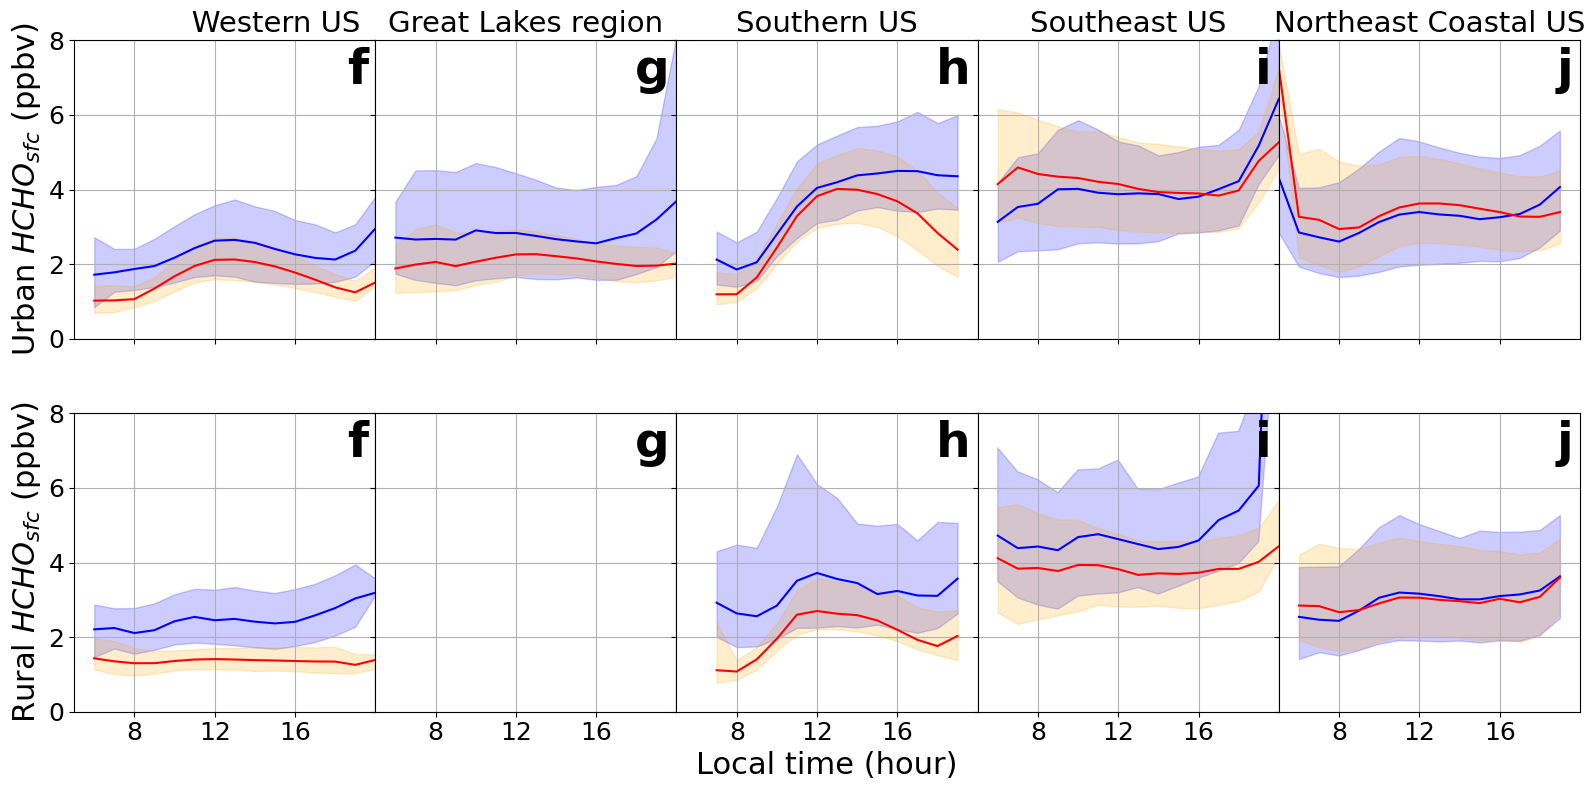

In [98]:

# xlims = [5,20]
# ylims = [0,3e16]
# xlabels = ['Local time (hour)','Local time (hour)']
# ylabels = ["PGN $HCHO_{trop}$ $(molecules$ $cm^{-2})$", "GEOS-CF $HCHO_{trop}$ $(molecules$ $cm^{-2})$"]
# ylabels = ["Urban $HCHO_{trop}$ $(molecules$ $cm^{-2})$", "Rural $HCHO_{trop}$ $(molecules$ $cm^{-2})$"]


# plot_diurnal_regions_direct(PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d,\
# # plot_diurnal_regions_direct( PGN_fuh_HCHOdVCDprofile_2021to2023_warm_dVCD_diurnal_2d,\
#                             # PGN_fuh_HCHOTropVCD_2021to2023_warm_diurnal_2d,\
#                      GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_2d,\
#                      # GEOSCF_HCHOdVCD_v36_2021to2023_warm_diurnal_2d,\
#                      xlims, ylims, xlabels, ylabels
#                     )


xlims = [5,20]
ylims = [0,8]
xlabels = ['Local time (hour)','Local time (hour)']
ylabels = ["Urban $HCHO_{sfc}$ (ppbv)", "Rural $HCHO_{sfc}$ (ppbv)"]

plot_diurnal_regions_direct(PGN_fuh_HCHOSurfConc_2021to2023_warm_diurnal_2d,\
                     GEOSCF_HCHO_2021to2023_warm_diurnal_2d * 1e-9,\
                     xlims, ylims, xlabels, ylabels
                    )



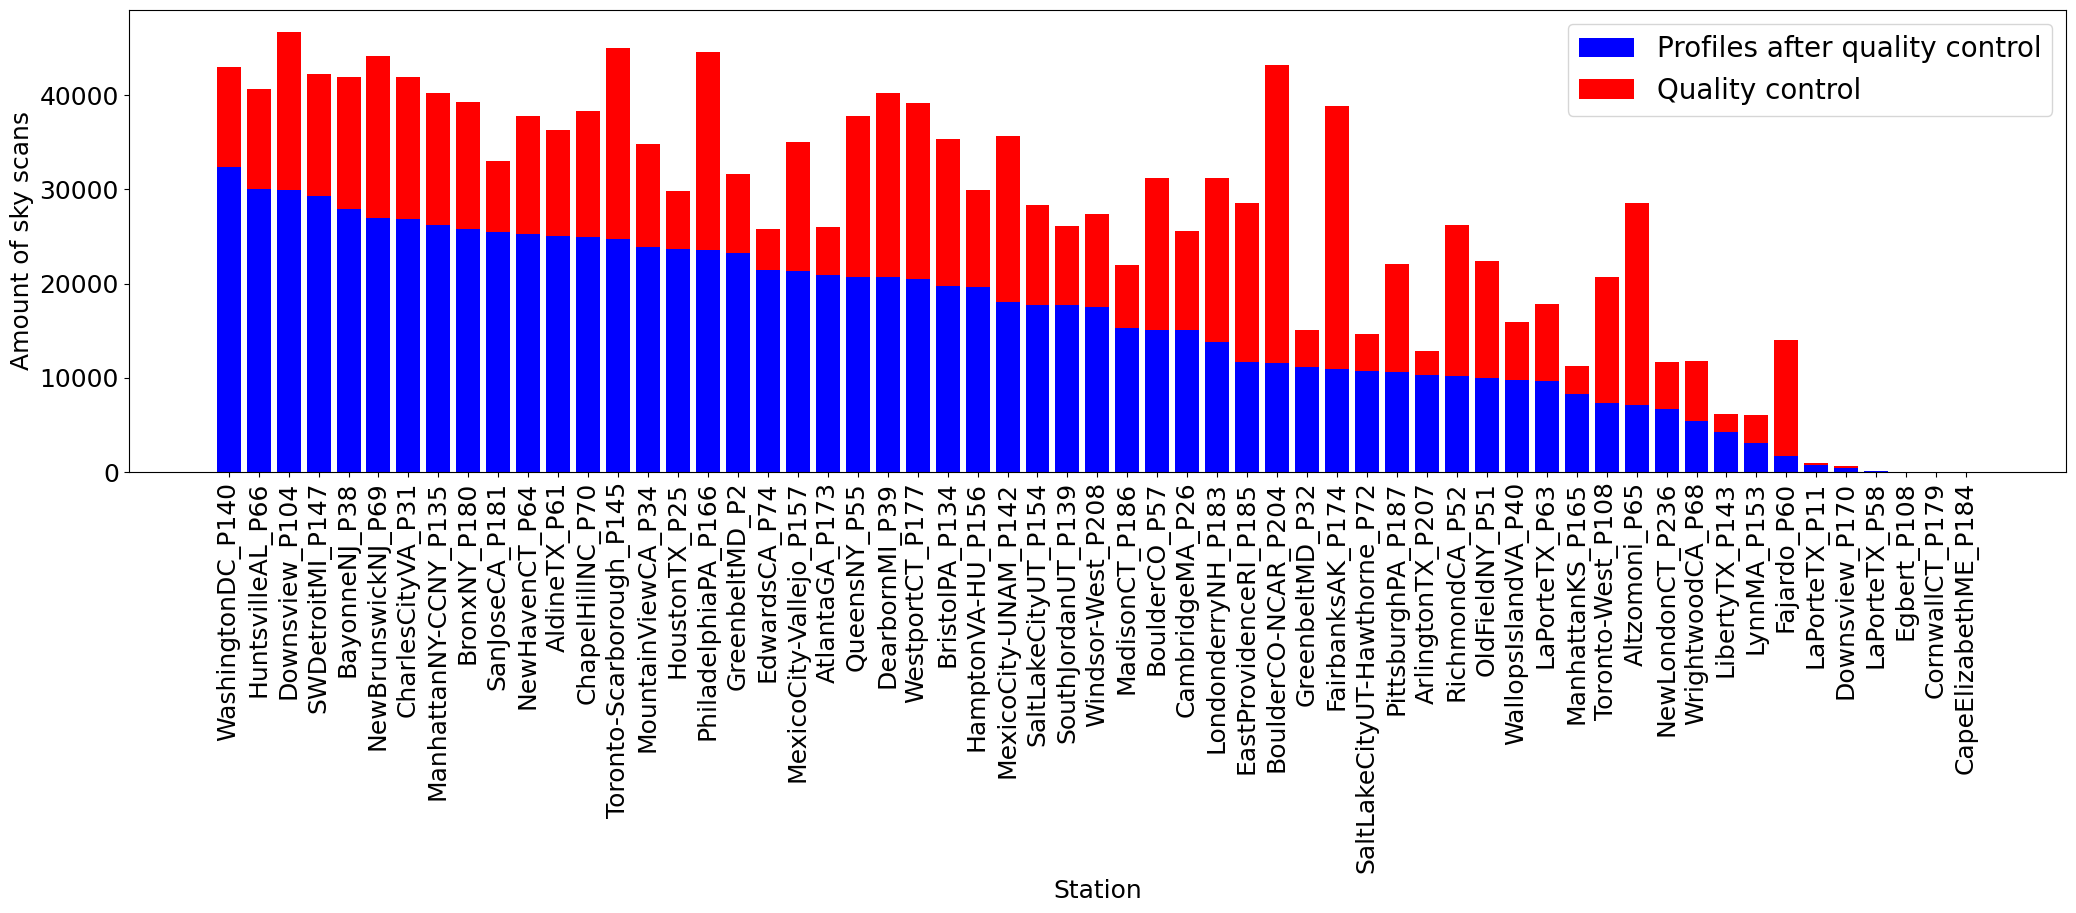

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 计算每个站点的总值
raw_totals = PGN_fuh_profile_count_raw_df_2021to2023_warm_diurnal_2d[urbanrural_rows_NA[:, 2]].sum()
qc1_totals = PGN_fuh_profile_count_QC1_df_2021to2023_warm_diurnal_2d[urbanrural_rows_NA[:, 2]].sum()
qc2_totals = PGN_fuh_profile_count_QC2_df_2021to2023_warm_diurnal_2d[urbanrural_rows_NA[:, 2]].sum()

# 计算过滤掉的部分
filtered_qc1 = raw_totals - qc1_totals  # 第一次 QC 过滤掉的数据
filtered_qc2 = qc1_totals - qc2_totals  # 第二次 QC 过滤掉的数据
remaining_qc2 = qc2_totals  # 最终保留的数据

# 转换为 DataArray
remaining_qc2_da = remaining_qc2.to_array(dim="station")
filtered_qc1_da = filtered_qc1.to_array(dim="station")
filtered_qc2_da = filtered_qc2.to_array(dim="station")

# 获取站点名称
stations = remaining_qc2_da["station"].values

# 按最终 QC2 数据进行降序排序
sorted_indices = remaining_qc2_da.argsort()[::-1]

# 重新排序数据
sorted_stations = stations[sorted_indices]
sorted_remaining_qc2 = remaining_qc2_da.values[sorted_indices]
sorted_filtered_qc1 = filtered_qc1_da.values[sorted_indices]
sorted_filtered_qc2 = filtered_qc2_da.values[sorted_indices]

# 画柱状图
fig, ax = plt.subplots(figsize=(25, 6))
bar_width = 0.8  # 柱子宽度

# 画柱状图，堆叠不同 QC 过滤的数据
ax.bar(sorted_stations, sorted_remaining_qc2, width=bar_width, label="Profiles after quality control", color="blue")
# ax.bar(sorted_stations, sorted_filtered_qc2, width=bar_width, bottom=sorted_remaining_qc2, label="Non-monotonic QC", color="cyan")
# ax.bar(sorted_stations, sorted_filtered_qc1, width=bar_width, bottom=sorted_remaining_qc2 + sorted_filtered_qc2, label="Basic QC", color="red")
ax.bar(sorted_stations, sorted_filtered_qc1 + sorted_filtered_qc2, width=bar_width, bottom=sorted_remaining_qc2, label="Quality control", color="red")



# 旋转 x 轴标签以便更好地显示
plt.xticks(rotation=90)
plt.ylabel("Amount of sky scans")
plt.xlabel("Station")
# plt.title("Comparison of Raw and QC-filtered Data (Sorted by QC2 Totals)")
plt.legend( fontsize=20 )

# 显示图表
plt.show()


In [161]:
# Define the lists
regionlist = ['EUS', 'NEUS', 'SEUS', 'SUS', 'WUS']
timelist = ['202205_08']
directory = "/import/GREENING/tzhao/PGN_Global_02503125_v1411_fiveUSdomains/data_merged_by_cdo"  # Replace with your directory
variable_namelist = [
    'BudgetConvectionTrop_CH2O','BudgetTransportTrop_CH2O','BudgetChemistryTrop_CH2O',\
    # 'BudgetEmisDryDepTrop_CH2O',
    'BudgetMixingTrop_CH2O',
    # 'BudgetWetDepTrop_CH2O',\
#     'Prod_CH2O',\
#     'Loss_CH2O',\
#     'OHconcAfterChem'
]


# Loop over the lists
for variable_name in variable_namelist:
    for itime in timelist:

        wholeUS_datasets = []

        for iregion in regionlist:
        

            file_pattern = f"{variable_name}_{iregion}_{itime}.nc"
            file_path = f"{directory}/{file_pattern}"
            
            
            # Step 1: read the merged file
            merged_dataarray = xr.open_dataset(file_path, engine='netcdf4')[variable_name]
            
            # Define the region-specific dataframe (you need to replace this with the actual dataframes for each region)
            if iregion == "EUS":
                region_df = urbanrural_rows_EUS_df
            elif iregion == "NEUS":
                region_df = urbanrural_rows_NEUS_df
            elif iregion == "SEUS":
                region_df = urbanrural_rows_SEUS_df
            elif iregion == "SUS":
                region_df = urbanrural_rows_SUS_df
            elif iregion == "WUS":
                region_df = urbanrural_rows_WUS_df
            
            # Step 2: Extract and combine site data
            extracted_data = extract_site_data(merged_dataarray, region_df)
            
            # Save the dataset with a unique name
            dataset_name = f"{variable_name}_{iregion}_{itime}"
            locals()[dataset_name] = extracted_data
            
            wholeUS_datasets.append(extracted_data)
            
        wholeUS_datasets_merged =  xr.merge(wholeUS_datasets, compat='override')
        locals()[f"{variable_name}_{itime}_sites"] = wholeUS_datasets_merged.copy()

In [162]:
# Export to netcdf files for the processed diurnal data 
processed_variable_names = [
    'BudgetConvectionTrop_CH2O_202205_08_sites',\
    'BudgetTransportTrop_CH2O_202205_08_sites',\
    'BudgetChemistryTrop_CH2O_202205_08_sites',\
    # 'BudgetEmisDryDepTrop_CH2O_202205_08_sites',\
    'BudgetMixingTrop_CH2O_202205_08_sites',\
    # 'BudgetWetDepTrop_CH2O_202205_08_sites',\
    # 'Prod_CH2O_202205_08_sites'\
    # 'Loss_CH2O_202205_08_sites',\
    # 'OHconcAfterChem_202205_08_sites',\
]

# Loop over each variable name
for varname in processed_variable_names:
    # Access the variable directly from memory
    data = locals()[varname]

    # Save the dataset or data array to a .nc file
    # Replace `path_to_save` with the directory where you want to save the .nc files
    data.to_netcdf(f"/import/GREENING/tzhao/jndata/paper4_data/{varname}.nc", engine='netcdf4')
    print(f"Saved to /import/GREENING/tzhao/jndata/paper4_data/{varname}.nc")


Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetConvectionTrop_CH2O_202205_08_sites.nc
Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetTransportTrop_CH2O_202205_08_sites.nc
Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetChemistryTrop_CH2O_202205_08_sites.nc
Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetMixingTrop_CH2O_202205_08_sites.nc


In [163]:
# --------------------------------------------------
#                 Import diurnal data
# --------------------------------------------------


processed_variable_names = [
    'BudgetConvectionTrop_CH2O_202205_08_sites',\
    'BudgetTransportTrop_CH2O_202205_08_sites',\
    'BudgetChemistryTrop_CH2O_202205_08_sites',\
    # 'BudgetEmisDryDepTrop_CH2O_202205_08_sites',\
    'BudgetMixingTrop_CH2O_202205_08_sites',\
    # 'BudgetWetDepTrop_CH2O_202205_08_sites',\
    'Prod_CH2O_202205_08_sites',\
    'Loss_CH2O_202205_08_sites',\
    'OHconcAfterChem_202205_08_sites',\
]

# Loop over each file name
for filename in processed_variable_names:
    # Load the dataset from the NetCDF file
    data = xr.open_dataset(f"/import/GREENING/tzhao/jndata/paper4_data/{filename}.nc")

    # Assign the loaded data to a variable with the same name as the file (without the ".nc" extension)
    locals()[filename] = data

    # Print confirmation
    print(f"Loaded variable   {filename}")

    # Close the dataset
    data.close()

Loaded variable   BudgetConvectionTrop_CH2O_202205_08_sites
Loaded variable   BudgetTransportTrop_CH2O_202205_08_sites
Loaded variable   BudgetChemistryTrop_CH2O_202205_08_sites
Loaded variable   BudgetMixingTrop_CH2O_202205_08_sites
Loaded variable   Prod_CH2O_202205_08_sites
Loaded variable   Loss_CH2O_202205_08_sites
Loaded variable   OHconcAfterChem_202205_08_sites


In [164]:
year = 2022
months = [5,8]


BudgetConvectionTrop_CH2O_202205_08_diurnal = {}
BudgetTransportTrop_CH2O_202205_08_diurnal = {}
BudgetChemistryTrop_CH2O_202205_08_diurnal = {}
# BudgetEmisDryDepTrop_CH2O_202205_08_diurnal = {}
BudgetMixingTrop_CH2O_202205_08_diurnal = {}
# BudgetWetDepTrop_CH2O_202205_08_diurnal = {}

BudgetConvectionTrop_CH2O_202205_08_diurnal_2d = {}
BudgetTransportTrop_CH2O_202205_08_diurnal_2d = {}
BudgetChemistryTrop_CH2O_202205_08_diurnal_2d = {}
# BudgetEmisDryDepTrop_CH2O_202205_08_diurnal_2d = {}
BudgetMixingTrop_CH2O_202205_08_diurnal_2d = {}
# BudgetWetDepTrop_CH2O_202205_08_diurnal_2d = {}

info_fush_union_CONUS_df = pd.concat([urbanrural_rows_EUS_df,\
                                      urbanrural_rows_SUS_df,\
                                      urbanrural_rows_NEUS_df,\
                                      urbanrural_rows_SEUS_df,\
                                      urbanrural_rows_WUS_df])

for i, (lat, lon, sitename) in enumerate(info_fush_union_CONUS_df[['lat','lon','sitename_PID']].values ):
    
    lat = float(lat)
    lon = float(lon)

    # Select the data for the current site from the datasets
    geoscf_data = BudgetConvectionTrop_CH2O_202205_08_sites[ sitename ]
    geoscf_data_diurnal,geoscf_data_diurnal_std, geoscf_data_diurnal_count, geoscf_data_diurnal_2d = calculate_diurnal_cycle_GC_YYYYMM(geoscf_data, lat, lon, year, months)[0:4]
    BudgetConvectionTrop_CH2O_202205_08_diurnal[sitename] =  geoscf_data_diurnal
    BudgetConvectionTrop_CH2O_202205_08_diurnal_2d[sitename] =  geoscf_data_diurnal_2d
    
    # Select the data for the current site from the datasets
    geoscf_data = BudgetTransportTrop_CH2O_202205_08_sites[ sitename ]
    geoscf_data_diurnal,geoscf_data_diurnal_std, geoscf_data_diurnal_count, geoscf_data_diurnal_2d = calculate_diurnal_cycle_GC_YYYYMM(geoscf_data, lat, lon, year, months)[0:4]
    BudgetTransportTrop_CH2O_202205_08_diurnal[sitename] =  geoscf_data_diurnal
    BudgetTransportTrop_CH2O_202205_08_diurnal_2d[sitename] =  geoscf_data_diurnal_2d
    
    # Select the data for the current site from the datasets
    geoscf_data = BudgetChemistryTrop_CH2O_202205_08_sites[ sitename ]
    geoscf_data_diurnal,geoscf_data_diurnal_std, geoscf_data_diurnal_count, geoscf_data_diurnal_2d = calculate_diurnal_cycle_GC_YYYYMM(geoscf_data, lat, lon, year, months)[0:4]
    BudgetChemistryTrop_CH2O_202205_08_diurnal[sitename] =  geoscf_data_diurnal
    BudgetChemistryTrop_CH2O_202205_08_diurnal_2d[sitename] =  geoscf_data_diurnal_2d

    # # Select the data for the current site from the datasets
    # geoscf_data = BudgetEmisDryDepTrop_CH2O_202205_08_sites[ sitename ]
    # geoscf_data_diurnal,geoscf_data_diurnal_std, geoscf_data_diurnal_count, geoscf_data_diurnal_2d = calculate_diurnal_cycle_GC_YYYYMM(geoscf_data, lat, lon, year, months)[0:4]
    # BudgetEmisDryDepTrop_CH2O_202205_08_diurnal[sitename] =  geoscf_data_diurnal
    # BudgetEmisDryDepTrop_CH2O_202205_08_diurnal_2d[sitename] =  geoscf_data_diurnal_2d
    
    # Select the data for the current site from the datasets
    geoscf_data = BudgetMixingTrop_CH2O_202205_08_sites[ sitename ]
    geoscf_data_diurnal,geoscf_data_diurnal_std, geoscf_data_diurnal_count, geoscf_data_diurnal_2d = calculate_diurnal_cycle_GC_YYYYMM(geoscf_data, lat, lon, year, months)[0:4]
    BudgetMixingTrop_CH2O_202205_08_diurnal[sitename] =  geoscf_data_diurnal
    BudgetMixingTrop_CH2O_202205_08_diurnal_2d[sitename] =  geoscf_data_diurnal_2d

    # # Select the data for the current site from the datasets
    # geoscf_data = BudgetWetDepTrop_CH2O_202205_08_sites[ sitename ]
    # geoscf_data_diurnal,geoscf_data_diurnal_std, geoscf_data_diurnal_count, geoscf_data_diurnal_2d = calculate_diurnal_cycle_GC_YYYYMM(geoscf_data, lat, lon, year, months)[0:4]
    # BudgetWetDepTrop_CH2O_202205_08_diurnal[sitename] =  geoscf_data_diurnal
    # BudgetWetDepTrop_CH2O_202205_08_diurnal_2d[sitename] =  geoscf_data_diurnal_2d



BudgetConvectionTrop_CH2O_202205_08_diurnal = xr.Dataset(BudgetConvectionTrop_CH2O_202205_08_diurnal)
BudgetTransportTrop_CH2O_202205_08_diurnal = xr.Dataset(BudgetTransportTrop_CH2O_202205_08_diurnal)
BudgetChemistryTrop_CH2O_202205_08_diurnal = xr.Dataset(BudgetChemistryTrop_CH2O_202205_08_diurnal)
# BudgetEmisDryDepTrop_CH2O_202205_08_diurnal = xr.Dataset(BudgetEmisDryDepTrop_CH2O_202205_08_diurnal)
BudgetMixingTrop_CH2O_202205_08_diurnal = xr.Dataset(BudgetMixingTrop_CH2O_202205_08_diurnal)
# BudgetWetDepTrop_CH2O_202205_08_diurnal = xr.Dataset(BudgetWetDepTrop_CH2O_202205_08_diurnal)


BudgetConvectionTrop_CH2O_202205_08_diurnal_2d = xr.Dataset(BudgetConvectionTrop_CH2O_202205_08_diurnal_2d)
BudgetTransportTrop_CH2O_202205_08_diurnal_2d = xr.Dataset(BudgetTransportTrop_CH2O_202205_08_diurnal_2d)
BudgetChemistryTrop_CH2O_202205_08_diurnal_2d = xr.Dataset(BudgetChemistryTrop_CH2O_202205_08_diurnal_2d)
# BudgetEmisDryDepTrop_CH2O_202205_08_diurnal_2d = xr.Dataset(BudgetEmisDryDepTrop_CH2O_202205_08_diurnal_2d)
BudgetMixingTrop_CH2O_202205_08_diurnal_2d = xr.Dataset(BudgetMixingTrop_CH2O_202205_08_diurnal_2d)
# BudgetWetDepTrop_CH2O_202205_08_diurnal_2d = xr.Dataset(BudgetWetDepTrop_CH2O_202205_08_diurnal_2d)


missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day
missed 1 day

In [170]:
processed_variable_names = [
# "OHconcAfterChem_202205_08_diurnal",
# "OHconcAfterChem_202205_08_diurnal_std",
# "OHconcAfterChem_202205_08_diurnal_2d",
# "Loss_CH2O_202205_08_diurnal",
# "Loss_CH2O_202205_08_diurnal_std",
# "Loss_CH2O_202205_08_diurnal_2d",
# "Prod_CH2O_202205_08_diurnal",
# "Prod_CH2O_202205_08_diurnal_std",
# "Prod_CH2O_202205_08_diurnal_2d",
"BudgetConvectionTrop_CH2O_202205_08_diurnal",
"BudgetTransportTrop_CH2O_202205_08_diurnal",
"BudgetChemistryTrop_CH2O_202205_08_diurnal",
# "BudgetEmisDryDepTrop_CH2O_202205_08_diurnal",
"BudgetMixingTrop_CH2O_202205_08_diurnal",
# "BudgetWetDepTrop_CH2O_202205_08_diurnal",
"BudgetConvectionTrop_CH2O_202205_08_diurnal_2d",
"BudgetTransportTrop_CH2O_202205_08_diurnal_2d",
"BudgetChemistryTrop_CH2O_202205_08_diurnal_2d",
# "BudgetEmisDryDepTrop_CH2O_202205_08_diurnal_2d",
"BudgetMixingTrop_CH2O_202205_08_diurnal_2d",
# "BudgetWetDepTrop_CH2O_202205_08_diurnal_2d",
]


# Loop over each variable name
for varname in processed_variable_names:
    # Access the variable directly from memory
    data = locals()[varname]

    # Save the dataset or data array to a .nc file
    # Replace `path_to_save` with the directory where you want to save the .nc files
    
    data.to_netcdf(f"/import/GREENING/tzhao/jndata/PGN_GEOSCHEM/02503125/{varname}.nc", engine='netcdf4')
    print(f"Saved to /import/GREENING/tzhao/jndata/PGN_GEOSCHEM/02503125/{varname}.nc")


Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetConvectionTrop_CH2O_202205_08_diurnal.nc
Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetTransportTrop_CH2O_202205_08_diurnal.nc
Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetChemistryTrop_CH2O_202205_08_diurnal.nc
Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetMixingTrop_CH2O_202205_08_diurnal.nc
Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetConvectionTrop_CH2O_202205_08_diurnal_2d.nc
Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetTransportTrop_CH2O_202205_08_diurnal_2d.nc
Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetChemistryTrop_CH2O_202205_08_diurnal_2d.nc
Saved to /import/GREENING/tzhao/jndata/paper4_data/BudgetMixingTrop_CH2O_202205_08_diurnal_2d.nc


In [174]:
# --------------------------------------------------
#                 Import diurnal data
# --------------------------------------------------


processed_variable_names = [
    "OHconcAfterChem_202205_08_diurnal",
    "OHconcAfterChem_202205_08_diurnal_std",
    "OHconcAfterChem_202205_08_diurnal_2d",
    "Loss_CH2O_202205_08_diurnal",
    "Loss_CH2O_202205_08_diurnal_std",
    "Loss_CH2O_202205_08_diurnal_2d",
    "Prod_CH2O_202205_08_diurnal",
    "Prod_CH2O_202205_08_diurnal_std",
    "Prod_CH2O_202205_08_diurnal_2d",
    "BudgetConvectionTrop_CH2O_202205_08_diurnal",
    "BudgetTransportTrop_CH2O_202205_08_diurnal",
    "BudgetChemistryTrop_CH2O_202205_08_diurnal",
    # "BudgetEmisDryDepTrop_CH2O_202205_08_diurnal",
    "BudgetMixingTrop_CH2O_202205_08_diurnal",
    # "BudgetWetDepTrop_CH2O_202205_08_diurnal",
    "BudgetConvectionTrop_CH2O_202205_08_diurnal_2d",
    "BudgetTransportTrop_CH2O_202205_08_diurnal_2d",
    "BudgetChemistryTrop_CH2O_202205_08_diurnal_2d",
    # "BudgetEmisDryDepTrop_CH2O_202205_08_diurnal_2d",
    "BudgetMixingTrop_CH2O_202205_08_diurnal_2d",
    # "BudgetWetDepTrop_CH2O_202205_08_diurnal_2d",

    "Met_BXHEIGHT_sites"
]

# Loop over each file name
for filename in processed_variable_names:
    # Load the dataset from the NetCDF file
    data = xr.open_dataset(f"/import/GREENING/tzhao/jndata/PGN_GEOSCHEM/02503125/{filename}.nc")

    # Assign the loaded data to a variable with the same name as the file (without the ".nc" extension)
    locals()[filename] = data

    # Print confirmation
    print(f"Loaded variable   {filename}")

    # Close the dataset
    data.close()

Loaded variable   OHconcAfterChem_202205_08_diurnal
Loaded variable   OHconcAfterChem_202205_08_diurnal_std
Loaded variable   OHconcAfterChem_202205_08_diurnal_2d
Loaded variable   Loss_CH2O_202205_08_diurnal
Loaded variable   Loss_CH2O_202205_08_diurnal_std
Loaded variable   Loss_CH2O_202205_08_diurnal_2d
Loaded variable   Prod_CH2O_202205_08_diurnal
Loaded variable   Prod_CH2O_202205_08_diurnal_std
Loaded variable   Prod_CH2O_202205_08_diurnal_2d
Loaded variable   BudgetConvectionTrop_CH2O_202205_08_diurnal
Loaded variable   BudgetTransportTrop_CH2O_202205_08_diurnal
Loaded variable   BudgetChemistryTrop_CH2O_202205_08_diurnal
Loaded variable   BudgetMixingTrop_CH2O_202205_08_diurnal
Loaded variable   BudgetConvectionTrop_CH2O_202205_08_diurnal_2d
Loaded variable   BudgetTransportTrop_CH2O_202205_08_diurnal_2d
Loaded variable   BudgetChemistryTrop_CH2O_202205_08_diurnal_2d
Loaded variable   BudgetMixingTrop_CH2O_202205_08_diurnal_2d
Loaded variable   Met_BXHEIGHT_sites


In [195]:
import matplotlib.pyplot as plt

def plot_diurnal_regions_1budget_trop(
    BudgetConvectionTrop_CH2O_202205_08_diurnal_2d,
    BudgetTransportTrop_CH2O_202205_08_diurnal_2d,
    BudgetChemistryTrop_CH2O_202205_08_diurnal_2d,
    # BudgetEmisDryDepTrop_CH2O_202205_08_diurnal_2d,
    BudgetMixingTrop_CH2O_202205_08_diurnal_2d,
    # BudgetWetDepTrop_CH2O_202205_08_diurnal_2d,
    prod_ch2o_diurnal_2d,
    loss_ch2o_diurnal_2d,
    xlims, ylims,
    xlabels, ylabels
    ):

    # Function to wrap long text
    def wrap_label(label, width=20):
        return '\n'.join(textwrap.wrap(label, width))
    
    def transpose_func_1(ds, landtype_list):
        sitelist = landtype_list[:, 2]
        your_data_array = ds[sitelist].to_array()
        stacked_data = your_data_array.stack(concat_dim=['variable', 'day'])
        transposed_data = stacked_data.transpose('hour_local', 'concat_dim')
        transposed_data = transposed_data.drop('concat_dim')
        return transposed_data

    fig, axs = plt.subplots(2, 5, figsize=(20,12))
    
    USregions = [[urban_rows_MWUS, rural_rows_MWUS], [urban_rows_NEUS, rural_rows_NEUS],
                 [urban_rows_SUS, rural_rows_SUS], [urban_rows_SEUS, rural_rows_SEUS],
                 [urban_rows_EUS, rural_rows_EUS]
                 ]
    USregions_names = ["     Western US","Great Lakes region", "Southern US",  "Southeast US", "Northeast Coastal US",
                       "", "", "", "", ""]
    color_budgetvar = ["red", "blue", "green",'black']
#     var_names = ['Convection','Transport','Chemistry','Emission+Dry Deposition','Mixing','Wet Deposition','Net']
    var_names = ['Chemical Production','Chemical Loss','Transport','Net']
    
    
    ds_list = [
        prod_ch2o_diurnal_2d,
        loss_ch2o_diurnal_2d,
        # BudgetConvectionTrop_CH2O_202205_08_diurnal_2d,
        BudgetTransportTrop_CH2O_202205_08_diurnal_2d,
#         BudgetChemistryTrop_CH2O_202205_08_diurnal_2d,
#         BudgetEmisDryDepTrop_CH2O_202205_08_diurnal_2d,
        # BudgetMixingTrop_CH2O_202205_08_diurnal_2d,
#         BudgetWetDepTrop_CH2O_202205_08_diurnal_2d,
        # BudgetConvectionTrop_CH2O_202205_08_diurnal_2d + BudgetTransportTrop_CH2O_202205_08_diurnal_2d + BudgetChemistryTrop_CH2O_202205_08_diurnal_2d + BudgetEmisDryDepTrop_CH2O_202205_08_diurnal_2d + BudgetMixingTrop_CH2O_202205_08_diurnal_2d + BudgetWetDepTrop_CH2O_202205_08_diurnal_2d
        BudgetConvectionTrop_CH2O_202205_08_diurnal_2d + BudgetTransportTrop_CH2O_202205_08_diurnal_2d + BudgetChemistryTrop_CH2O_202205_08_diurnal_2d + BudgetMixingTrop_CH2O_202205_08_diurnal_2d

    ]
    num_ds = len(ds_list)
    
    panel_labels = 'abcdefghijk'

    ipanel_pos = 0
    for i in range(0,2):
        for j, USregion in enumerate(USregions):
            
            for k, ds in enumerate(ds_list):
#                 urban_data = transpose_func_1(ds, USregion[i])
                urban_data = transpose_func_1(ds, USregion[i])

                urban_median = urban_data.median(dim='concat_dim')
                urban_q25 = urban_data.quantile(0.25, dim='concat_dim')
                urban_q75 = urban_data.quantile(0.75, dim='concat_dim')

#                 rural_median = rural_data.median(dim='concat_dim')
#                 rural_q25 = rural_data.quantile(0.25, dim='concat_dim')
#                 rural_q75 = rural_data.quantile(0.75, dim='concat_dim')

#                 axs[i, j].plot(rural_median['hour_local'], rural_median, color='green', label='Rural Median')
#                 axs[i, j].fill_between(rural_median['hour_local'], rural_q25, rural_q75, color='green', alpha=0.2,
#                                         label='Rural 25%-75%')

                if k==3:
                    axs[i, j].plot(urban_median['hour_local'], urban_median, color=color_budgetvar[k], linewidth=5.5, label='Urban Median', alpha=1)
#                     axs[i, j].fill_between(urban_median['hour_local'], urban_q25, urban_q75, color=color_budgetvar[k], alpha=0.2,
#                                             label='Urban 25%-75%', linewidth=4)
                else:
                    axs[i, j].plot(urban_median['hour_local'], urban_median, color=color_budgetvar[k], linewidth=2.5, label='Urban Median')
#                     axs[i, j].fill_between(urban_median['hour_local'], urban_q25, urban_q75, color=color_budgetvar[k], alpha=0.2,
#                                             label='Urban 25%-75%', linewidth=1)

                if i==0:
                    axs[i, j].set_title(USregions_names[j], fontsize=20)
                axs[i, j].set_ylim(ylims)
                axs[i, j].set_xlim(xlims)
                axs[i, j].set_xticks([8,12,16])
                axs[i, j].set_xticklabels([8,12,16])

                if i==2:
                    axs[i, j].set_ylim([ylims[0], ylims[1]* 0.5])            

                if ylims[1] > 1e5 and j == 0:
    #                 axs[i, j].yaxis.get_major_formatter().set_powerlimits((0, 1))
    #                 plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))

                    # Replace the loop for setting scientific notation with custom formatter        
                    import matplotlib.ticker as ticker
                    formatter = ticker.ScalarFormatter(useMathText=True)
                    formatter.set_powerlimits((-3, 3))  # Set the range for exponent display
                    axs[i, j].yaxis.set_major_formatter(formatter)

                axs[i, j].set_aspect('auto')

                if j == 2:
                    axs[i, j].set_xlabel(xlabels, fontsize=22)

                if i == 0 and j==0:
                    
                    # Wrapping the ylabel
                    wrapped_isitename = wrap_label( ylabels , width=36)     
                    axs[i, j].set_ylabel(wrapped_isitename, fontsize=22)

                if ipanel_pos == 9:
                    print(var_names)
                    axs[i,j].legend(var_names, fontsize=20, bbox_to_anchor=(2.4, 2))


                # if ipanel_pos in [0]:
                    # axs[i, j].set_xticklabels([], fontsize=20)
        #             ax.set_yticklabels([], fontsize=18)        
                if ipanel_pos in [1,2,3,4]:
                    # axs[i, j].set_xticklabels([], fontsize=20)
                    axs[i, j].set_yticklabels([], fontsize=20)
                if ipanel_pos in [6,7,8,9]:
#                     axs[i,j].set_xticklabels([], fontsize=17)
                    axs[i, j].set_yticklabels([], fontsize=20)
                if ipanel_pos in [11,12,13,14]:
        #             ax.set_xticklabels([], fontsize=18)
                    axs[i, j].set_yticklabels([], fontsize=20)
            
                # Add panel label
                axs[i, j].annotate(panel_labels[ipanel_pos], xy=(1, 1), xycoords='axes fraction', fontsize=40,
                                   xytext=(-5, -5), textcoords='offset points',
                                   ha='right', va='top', weight='bold')

            ipanel_pos+=1

        
    for ax in axs.flat:
        ax.grid(True, which='both')  # Enable both vertical and horizontal gridlines



#     plt.tight_layout(pad=1.0)  
    fig.tight_layout()#调整整体空白 
    plt.subplots_adjust(wspace =0.0, hspace =0.25)#调整子图间距
#     plt.savefig( '/home/tzhao/my_jupyter_work/newest/EGU24_poster_figs/diurnalcycle_HCHOsurfconc'+'.svg', dpi=300, bbox_inches='tight')
    plt.show()

    


In [196]:
import math

def calculate_grid_area(latitude, lat_resolution=0.25, lon_resolution=0.3125, earth_radius=6371):
    """
    Calculate the area of a grid cell given the latitude and resolution.

    Parameters:
    - latitude: Latitude in degrees.
    - lat_resolution: Latitude resolution in degrees (default 0.25).
    - lon_resolution: Longitude resolution in degrees (default 0.3125).
    - earth_radius: Radius of the Earth in kilometers (default 6371 km).

    Returns:
    - Area of the grid cell in square meters.
    """
    # Convert degrees to radians
    lat_resolution_rad = math.radians(lat_resolution)
    lon_resolution_rad = math.radians(lon_resolution)
    latitude_rad = math.radians(latitude)

    # Calculate distances in the latitude and longitude directions
    distance_lat = earth_radius * lat_resolution_rad
    distance_lon = earth_radius * lon_resolution_rad * math.cos(latitude_rad)

    # Calculate the area of the grid cell
    area = distance_lat * 1e3 * distance_lon * 1e3

    return area


['Chemical Production', 'Chemical Loss', 'Transport', 'Net']
['Chemical Production', 'Chemical Loss', 'Transport', 'Net']
['Chemical Production', 'Chemical Loss', 'Transport', 'Net']
['Chemical Production', 'Chemical Loss', 'Transport', 'Net']


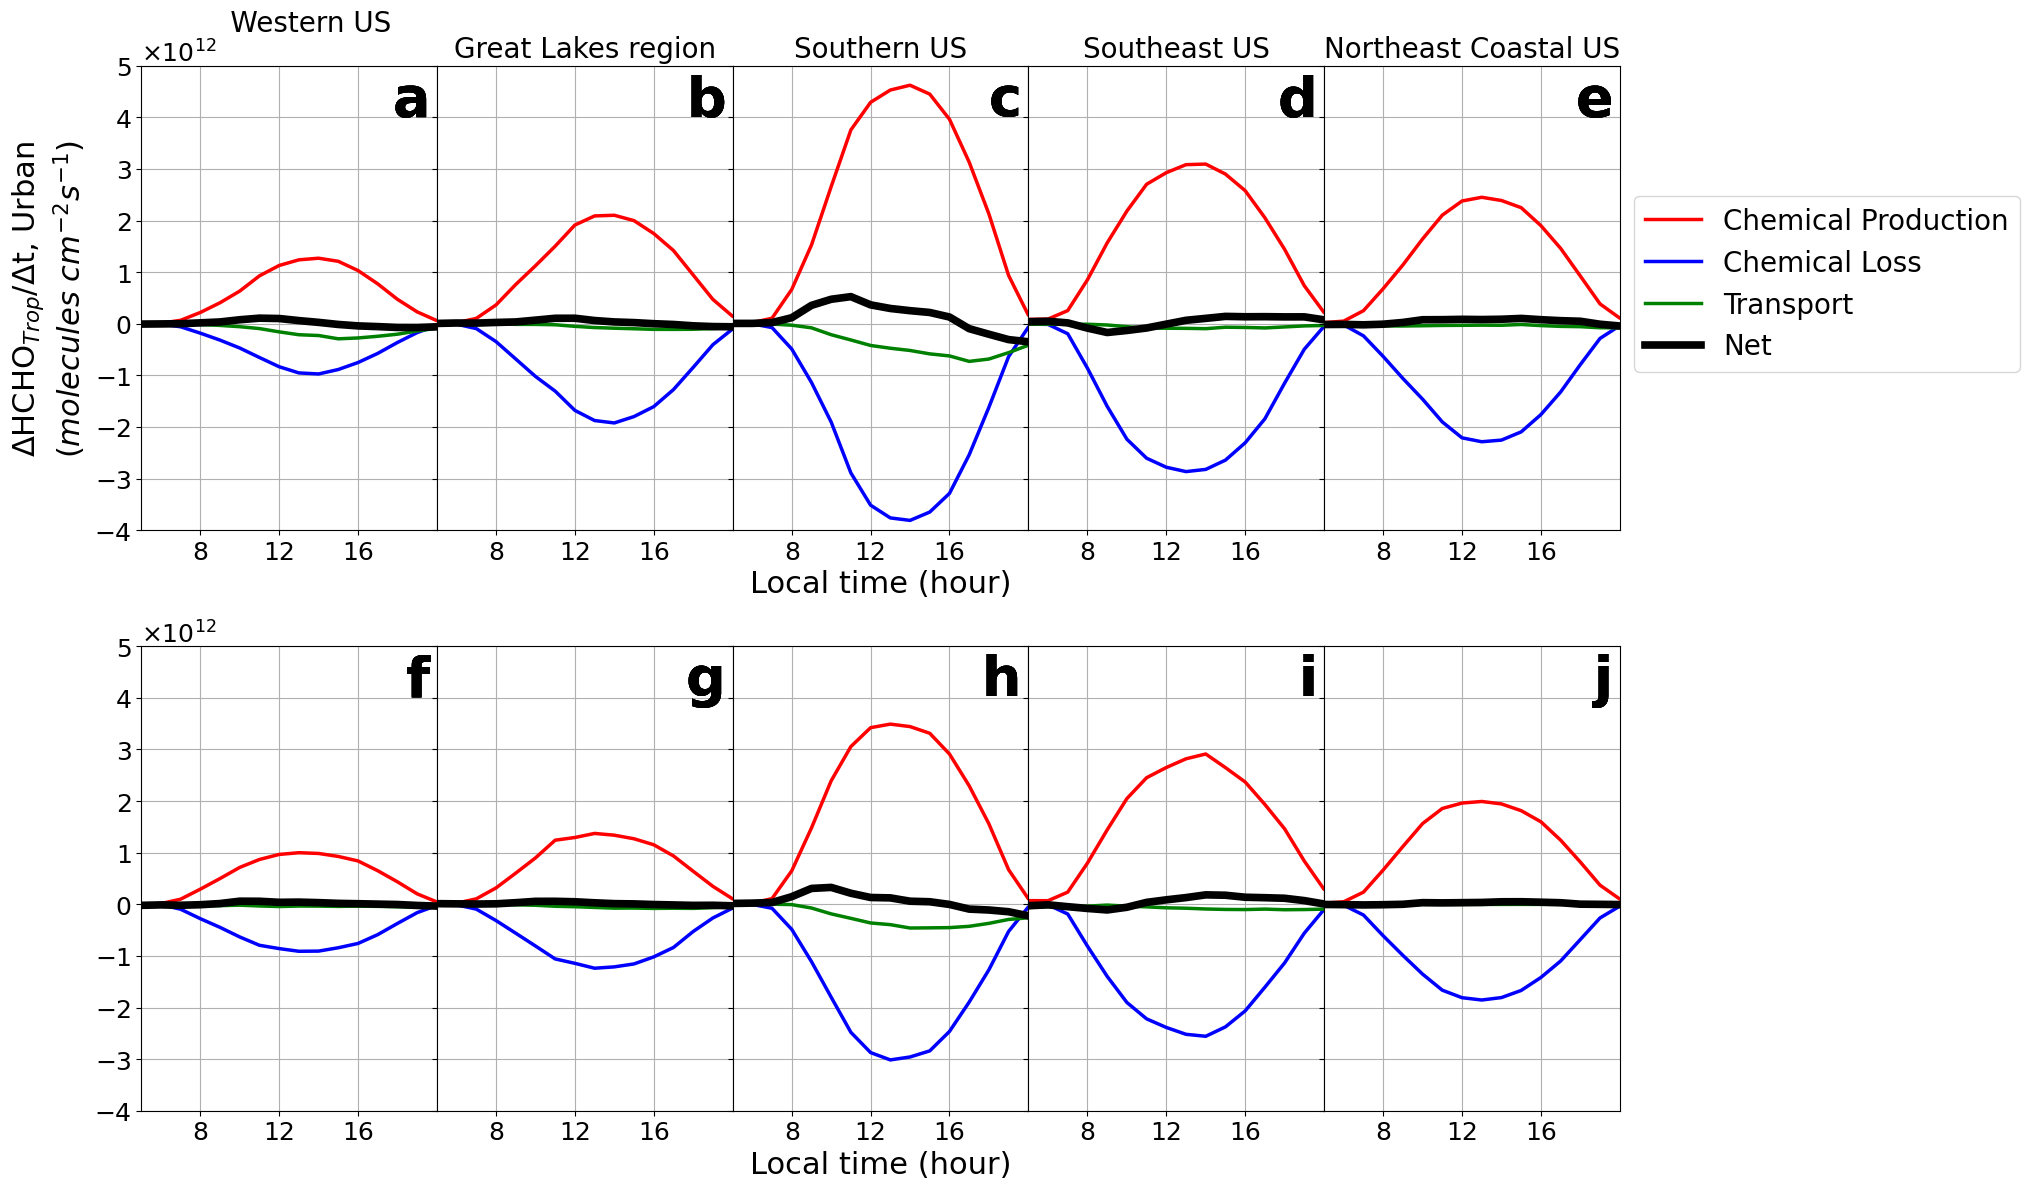

In [199]:

xlims = [5,20]
ylims = [-4e12,5e12]
xlabels = 'Local time (hour)'
# ylabels = "HCHO$_{Tropcol}$ budget tendency, urban ($molecules$ $cm^{-2} s^{-1}$)"
ylabels = "ΔHCHO$_{Trop}$/Δt, Urban  ($molecules$ $cm^{-2} s^{-1}$)"

convert_kg_to_moleccm2 = 1e3 / 30 * 6.02e23 / (calculate_grid_area( 40 ) * 1e4 )
# PGN_availability = (GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_2d / GEOSCF_TROPCOL_HCHO_2021to2023_warm_diurnal_2d)
PGN_availability = 1


plot_diurnal_regions_1budget_trop(    BudgetConvectionTrop_CH2O_202205_08_diurnal_2d * convert_kg_to_moleccm2,
    BudgetTransportTrop_CH2O_202205_08_diurnal_2d * convert_kg_to_moleccm2 * PGN_availability,
    BudgetChemistryTrop_CH2O_202205_08_diurnal_2d * convert_kg_to_moleccm2 * PGN_availability,
    # BudgetEmisDryDepTrop_CH2O_202205_08_diurnal_2d * convert_kg_to_moleccm2 * PGN_availability,
    BudgetMixingTrop_CH2O_202205_08_diurnal_2d * convert_kg_to_moleccm2 * PGN_availability,
    # BudgetWetDepTrop_CH2O_202205_08_diurnal_2d * convert_kg_to_moleccm2 * PGN_availability,
    (Prod_CH2O_202205_08_diurnal_2d * Met_BXHEIGHT_sites['BronxNY_P180'].median(dim='time') * 1e2 ).isel(lev=slice(0,47)).sum(dim='lev') * PGN_availability,
    (-Loss_CH2O_202205_08_diurnal_2d * Met_BXHEIGHT_sites['BronxNY_P180'].median(dim='time') * 1e2 ).isel(lev=slice(0,47)).sum(dim='lev') * PGN_availability,
    
    xlims, ylims, xlabels, ylabels
                    )